### Parametros con valores categoricos:

### Extaer variable categoricas

In [2]:
import pandas as pd
import numpy as np
from eliana.datasets import ParlogsObservations
INSTRUMENT='MATISSE'
RANGE='6m'
logs = ParlogsObservations(period=RANGE, source="Instrument", system=INSTRUMENT)
df_meta = logs.meta
df_traces = logs.traces()
TPL_IDs = logs.meta['TPL_ID'].value_counts()
TPL_IDs_Error=df_meta[df_meta['ERROR'] == True]
TPL_IDs_Error['TPL_ID'].value_counts()
TPL = set(TPL_IDs.index) & set(TPL_IDs_Error['TPL_ID'])
print(TPL)

{'MATISSE_gen_cal_det_aq', 'MATISSE_img_acq_ft', 'MATISSE_gen_cal_transfunc', 'MATISSE_gen_tec_opd', 'MATISSE_gen_cal_shift', 'MATISSE_gen_cal_imbasic', 'MATISSE_img_acq', 'MATISSE_gen_cal_kappa', 'errseverity', 'MATISSE_gen_tec_piezos', 'MATISSE_gen_cal_det_h2', 'MATISSE_gen_tec_check_fringes', 'MATISSE_gen_tec_ali', 'MATISSE_gen_cal_bias', 'MATISSE_hyb_obs'}


In [3]:
def extract_params(df_original):
    # df is a copy fo df_original
    df = df_original.copy()
    
    # Filter rows where @timestamp are the first 3 seconds of the whole df
    df = df[df['@timestamp'] < df['@timestamp'].min() + pd.Timedelta(seconds=3)]
    
    # Filter where column logtext has the form (any string)' = '(anystring), and exactly one = sign
    df = df[df['logtext'].str.contains(r"^.* = .*$")] 
    
    # Create column "param" with left part of ' = ', and column "value" with right part of ' = '
    df['param'] = df['logtext'].str.split(' = ').str[0]
    df['value'] = df['logtext'].str.split(' = ').str[1]
    
    # Restrict to columns param and value
    df = df[['param', 'value']]
    
    # Replace spaces by dot in param
    df['param'] = df['param'].str.replace(" ", ".")

    # Remove extra ' enclosing value
    df['value'] = df['value'].str.replace("'", "")
    
    # Create a column numval with the numeric value of value, if possible, otherwise NaN
    df['numval'] = pd.to_numeric(df['value'], errors='coerce')
    
    # Create column strval if numval is NaN, otherwise empty string
    df['strval'] = df['value'].where(df['numval'].isna(), "")
    
    # Remove column value-
    df = df.drop(columns=['value']) 

    # Set param as the index
    df = df.set_index('param')

    df = df.sort_index()  
    return df


In [4]:
df_meta_Error= df_meta[df_meta['ERROR'] == True]
df_meta_2 = df_meta[~df_meta['START'].isin(df_meta_Error['START'])]

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('default')
plt.rcParams['font.size'] = 10

def graficos_dispersion(df_sin_error, df_con_error):
    columnas_parametros = df_sin_error.columns.intersection(df_con_error.columns)
    columnas_parametros = [col for col in columnas_parametros if col != 'param']

    print(f"Creando gráficos para {len(columnas_parametros)} parámetros...")
    print(f"Observaciones sin error: {len(df_sin_error)}")
    print(f"Observaciones con error: {len(df_con_error)}")

    if not columnas_parametros:
        print("No hay columnas comunes para graficar.")
        return

    n_params = len(columnas_parametros)
    cols = 3
    rows = (n_params + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
    fig.suptitle('Dispersión de Parámetros\nRojo: Con Error | Azul: Sin Error',
                 fontsize=18, fontweight='bold', y=0.995)

    axes_flat = axes.flatten() if isinstance(axes, (list, np.ndarray)) else [axes]

    for i, param in enumerate(columnas_parametros):
        y_sin_error = df_sin_error[param]
        y_con_error = df_con_error[param]

        if y_sin_error.dropna().empty and y_con_error.dropna().empty:
            print(f"Columna vacía: {param}. Se omite.")
            continue

        ax = axes_flat[i]
        x_sin_error = range(len(y_sin_error))
        x_con_error = range(len(y_con_error))

        ax.scatter(x_sin_error, y_sin_error, c='blue', alpha=0.6, s=20,
                   label=f'Sin error (n={len(y_sin_error)})', edgecolors='darkred', linewidth=0.3)

        ax.scatter(x_con_error, y_con_error, c='red', alpha=0.6, s=20,
                   label=f'Con error (n={len(y_con_error)})', edgecolors='darkblue', linewidth=0.3)

        ax.set_title(param, fontweight='bold', fontsize=11)
        ax.set_xlabel('Índice de Observación')
        ax.set_ylabel('Valor del Parámetro')
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=8)

        if (y_sin_error.nunique(dropna=True) <= 1) and (y_con_error.nunique(dropna=True) <= 1):
            ax.text(0.5, 0.5, 'VALORES\nCONSTANTES', transform=ax.transAxes,
                    ha='center', va='center', fontsize=12, fontweight='bold',
                    bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.7))

    for j in range(i + 1, len(axes_flat)):
        axes_flat[j].set_visible(False)

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()


In [1]:
import matplotlib.pyplot as plt
plt.style.use('default')
plt.rcParams['font.size'] = 10

def graficos_dispersion_por_columna(df_sin_error, df_con_error):
    columnas_parametros = [col for col in df_sin_error.columns if col != 'param']
    parametros_constantes = []

    # Filtrar solo parámetros no constantes
    columnas_validas = []
    for col in columnas_parametros:
        std_ok = df_sin_error[col].std()
        std_err = df_con_error[col].std()
        if std_ok == 0 and std_err == 0:
            parametros_constantes.append(col)
        else:
            columnas_validas.append(col)

    print(f"Creando gráficos para {len(columnas_validas)} parámetros NO constantes...")
    print(f"Parámetros constantes (omitidos): {parametros_constantes}")
    print(f"Observaciones sin error: {len(df_sin_error)}")
    print(f"Observaciones con error: {len(df_con_error)}")

    n_params = len(columnas_validas)
    if n_params == 0:
        print("Todos los parámetros son constantes. No se generarán gráficos.")
        return parametros_constantes

    cols = 3
    rows = (n_params + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(15, 5*rows))
    fig.suptitle('Dispersión de Parámetros\nRojo: Con Error | Azul: Sin Error', 
                 fontsize=18, fontweight='bold', y=0.995)

    if rows == 1:
        axes = axes.reshape(1, -1)
    elif cols == 1:
        axes = axes.reshape(-1, 1)

    axes_flat = axes.flatten()

    for i, param in enumerate(columnas_validas):
        ax = axes_flat[i]
        x_sin_error = range(len(df_sin_error))
        x_con_error = range(len(df_con_error))
        y_sin_error = df_sin_error[param]
        y_con_error = df_con_error[param]

        ax.scatter(x_sin_error, y_sin_error, c='blue', alpha=0.6, s=20,
                   label=f'Sin error (n={len(df_sin_error)})', edgecolors='darkred', linewidth=0.3)

        ax.scatter(x_con_error, y_con_error, c='red', alpha=0.6, s=20,
                   label=f'Con error (n={len(df_con_error)})', edgecolors='darkblue', linewidth=0.3)

        ax.set_title(param, fontweight='bold', fontsize=11)
        ax.set_xlabel('Índice de Observación')
        ax.set_ylabel('Valor del Parámetro')
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=8)

    for i in range(len(columnas_validas), len(axes_flat)):
        axes_flat[i].set_visible(False)

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

    return parametros_constantes



In [ ]:
def extract_trace_categoricals(df_meta, df_traces, extract_params, tpl_id='MATISSE_img_acq'):
    """
    Extrae parámetros categóricos (strval) de trazas desde un DataFrame de trazas filtrado por un TPL_ID específico.

    Args:
        df_meta (pd.DataFrame): DataFrame que contiene información de metadatos con columna 'TPL_ID'.
        df_traces (pd.DataFrame): DataFrame que contiene las trazas, con columna 'trace_id'.
        extract_params (function): Función que toma un DataFrame de una traza y devuelve un DataFrame con parámetros.
        tpl_id (str): Valor de TPL_ID por el cual se desea filtrar (por defecto 'MATISSE_img_acq').

    Returns:
        pd.DataFrame: DataFrame con los parámetros categóricos (strval) por cada trace_id.
    """
    tpl_indices = df_meta[df_meta['TPL_ID'] == tpl_id].index

    df_filtered = df_traces[df_traces['trace_id'].isin(tpl_indices)]

    params_dict = {}
    for trace_id in df_filtered['trace_id'].unique():
        df_trace = df_filtered[df_filtered['trace_id'] == trace_id]
        params = extract_params(df_trace)

        params = params[~params.index.duplicated(keep='first')]
        params_dict[trace_id] = params

    strval_df = pd.concat(
        {trace_id: df['strval'] for trace_id, df in params_dict.items()},
        axis=1).T

    strval_df = strval_df.sort_index(axis=1)
    strval_df = strval_df.dropna(how='all')        
    strval_df = strval_df.dropna(axis=1, how='all') 

    return strval_df


In [ ]:
import os

output_dir_strval = "params_tpl_strval"
os.makedirs(output_dir_strval, exist_ok=True)

tpl_strval_dict = {}

for tpl_id in TPL:
    print(f"Procesando TPL_ID: {tpl_id} (strval)")

    strval_df = extract_trace_categoricals(df_meta_2, df_traces, extract_params, tpl_id=tpl_id) 
       
    if not strval_df.empty:
        tpl_strval_dict[tpl_id] = strval_df
        safe_tpl_id = str(tpl_id).replace("/", "_").replace(" ", "_")
        filename = os.path.join(output_dir_strval, f"params_strval_{safe_tpl_id}.csv")

        strval_df.to_csv(filename)
        print(f"Guardado: {filename}")
    else:
        print(f"No se guardó {tpl_id} porque el DataFrame (strval) está vacío después del filtrado.")


Procesando TPL_ID: MATISSE_gen_cal_det_aq (strval)
Guardado: params_tpl_strval\params_strval_MATISSE_gen_cal_det_aq.csv
Procesando TPL_ID: MATISSE_img_acq_ft (strval)
Guardado: params_tpl_strval\params_strval_MATISSE_img_acq_ft.csv
Procesando TPL_ID: MATISSE_gen_cal_transfunc (strval)
Guardado: params_tpl_strval\params_strval_MATISSE_gen_cal_transfunc.csv
Procesando TPL_ID: MATISSE_gen_tec_opd (strval)
Guardado: params_tpl_strval\params_strval_MATISSE_gen_tec_opd.csv
Procesando TPL_ID: MATISSE_gen_cal_shift (strval)
Guardado: params_tpl_strval\params_strval_MATISSE_gen_cal_shift.csv
Procesando TPL_ID: MATISSE_gen_cal_imbasic (strval)
Guardado: params_tpl_strval\params_strval_MATISSE_gen_cal_imbasic.csv
Procesando TPL_ID: MATISSE_img_acq (strval)
Guardado: params_tpl_strval\params_strval_MATISSE_img_acq.csv
Procesando TPL_ID: MATISSE_gen_cal_kappa (strval)
Guardado: params_tpl_strval\params_strval_MATISSE_gen_cal_kappa.csv
Procesando TPL_ID: errseverity (strval)
Guardado: params_tpl_str

In [ ]:
import os

output_dir_strval_err = "params_por_tpl_Error_strval"
os.makedirs(output_dir_strval_err, exist_ok=True)

tpl_strval_err_dict = {}

for tpl_id in TPL:
    print(f"Procesando TPL_ID (Error, strval): {tpl_id}")
    
    strval_df = extract_trace_categoricals(
        df_meta_Error,
        df_traces,
        extract_params,
        tpl_id=tpl_id
    )
    
    if not strval_df.empty:
        tpl_strval_err_dict[tpl_id] = strval_df
        
        safe_tpl_id = str(tpl_id).replace("/", "_").replace(" ", "_")
        filename = os.path.join(output_dir_strval_err, f"params_strval_{safe_tpl_id}.csv")
        
        strval_df.to_csv(filename)
        print(f"Guardado: {filename}")
    else:
        print(f"No se guardó {tpl_id} porque el DataFrame (strval) está vacío después del filtrado.")


Procesando TPL_ID (Error, strval): MATISSE_gen_cal_det_aq
Guardado: params_por_tpl_Error_strval\params_strval_MATISSE_gen_cal_det_aq.csv
Procesando TPL_ID (Error, strval): MATISSE_img_acq_ft
Guardado: params_por_tpl_Error_strval\params_strval_MATISSE_img_acq_ft.csv
Procesando TPL_ID (Error, strval): MATISSE_gen_cal_transfunc
Guardado: params_por_tpl_Error_strval\params_strval_MATISSE_gen_cal_transfunc.csv
Procesando TPL_ID (Error, strval): MATISSE_gen_tec_opd
Guardado: params_por_tpl_Error_strval\params_strval_MATISSE_gen_tec_opd.csv
Procesando TPL_ID (Error, strval): MATISSE_gen_cal_shift
Guardado: params_por_tpl_Error_strval\params_strval_MATISSE_gen_cal_shift.csv
Procesando TPL_ID (Error, strval): MATISSE_gen_cal_imbasic
Guardado: params_por_tpl_Error_strval\params_strval_MATISSE_gen_cal_imbasic.csv
Procesando TPL_ID (Error, strval): MATISSE_img_acq
Guardado: params_por_tpl_Error_strval\params_strval_MATISSE_img_acq.csv
Procesando TPL_ID (Error, strval): MATISSE_gen_cal_kappa
Guarda

In [13]:
import os
import pandas as pd
import json

def codificar_categoricas_por_columna(df_categorico):
    """
    Codifica valores categóricos columna por columna, asignando enteros desde 1 en orden alfabético.
    """
    columnas_codificadas = {}
    codificadores = {}

    for col in df_categorico.columns:
        categorias = sorted(df_categorico[col].dropna().unique())
        mapa = {cat: i + 1 for i, cat in enumerate(categorias)}
        columnas_codificadas[col] = df_categorico[col].map(mapa)
        codificadores[col] = mapa

    df_codificado = pd.DataFrame(columnas_codificadas, index=df_categorico.index).copy()
    return df_codificado, codificadores


In [16]:
def procesar_carpeta_strval(input_dir, output_dir, diccionario_json_path):
    os.makedirs(output_dir, exist_ok=True)
    diccionario_global = {}

    for filename in os.listdir(input_dir):
        if filename.endswith(".csv"):
            file_path = os.path.join(input_dir, filename)
            
            df = pd.read_csv(file_path, index_col=0)

            if df.empty:
                print(f"Archivo vacío: {filename}")
                continue

            df_codificado, mapas = codificar_categoricas_por_columna(df)
            diccionario_global[filename] = mapas

            output_path = os.path.join(output_dir, filename)
            df_codificado.to_csv(output_path)

    with open(diccionario_json_path, "w", encoding='utf-8') as f:
        json.dump(diccionario_global, f, ensure_ascii=False, indent=2)

    print(f"Diccionario guardado: {diccionario_json_path}")

In [ ]:
procesar_carpeta_strval(
    input_dir="params_tpl_strval",
    output_dir="params_tpl_strval_codificados",
    diccionario_json_path="diccionario_codificacion_tpl_strval.json"
)

procesar_carpeta_strval(
    input_dir="params_por_tpl_Error_strval",
    output_dir="params_por_tpl_Error_strval_codificados",
    diccionario_json_path="diccionario_codificacion_tpl_Error_strval.json"
)


Diccionario guardado: diccionario_codificacion_tpl_strval.json
Diccionario guardado: diccionario_codificacion_tpl_Error_strval.json



Graficando: params_strval_MATISSE_gen_cal_bias.csv
Creando gráficos para 11 parámetros...
Observaciones sin error: 715
Observaciones con error: 9


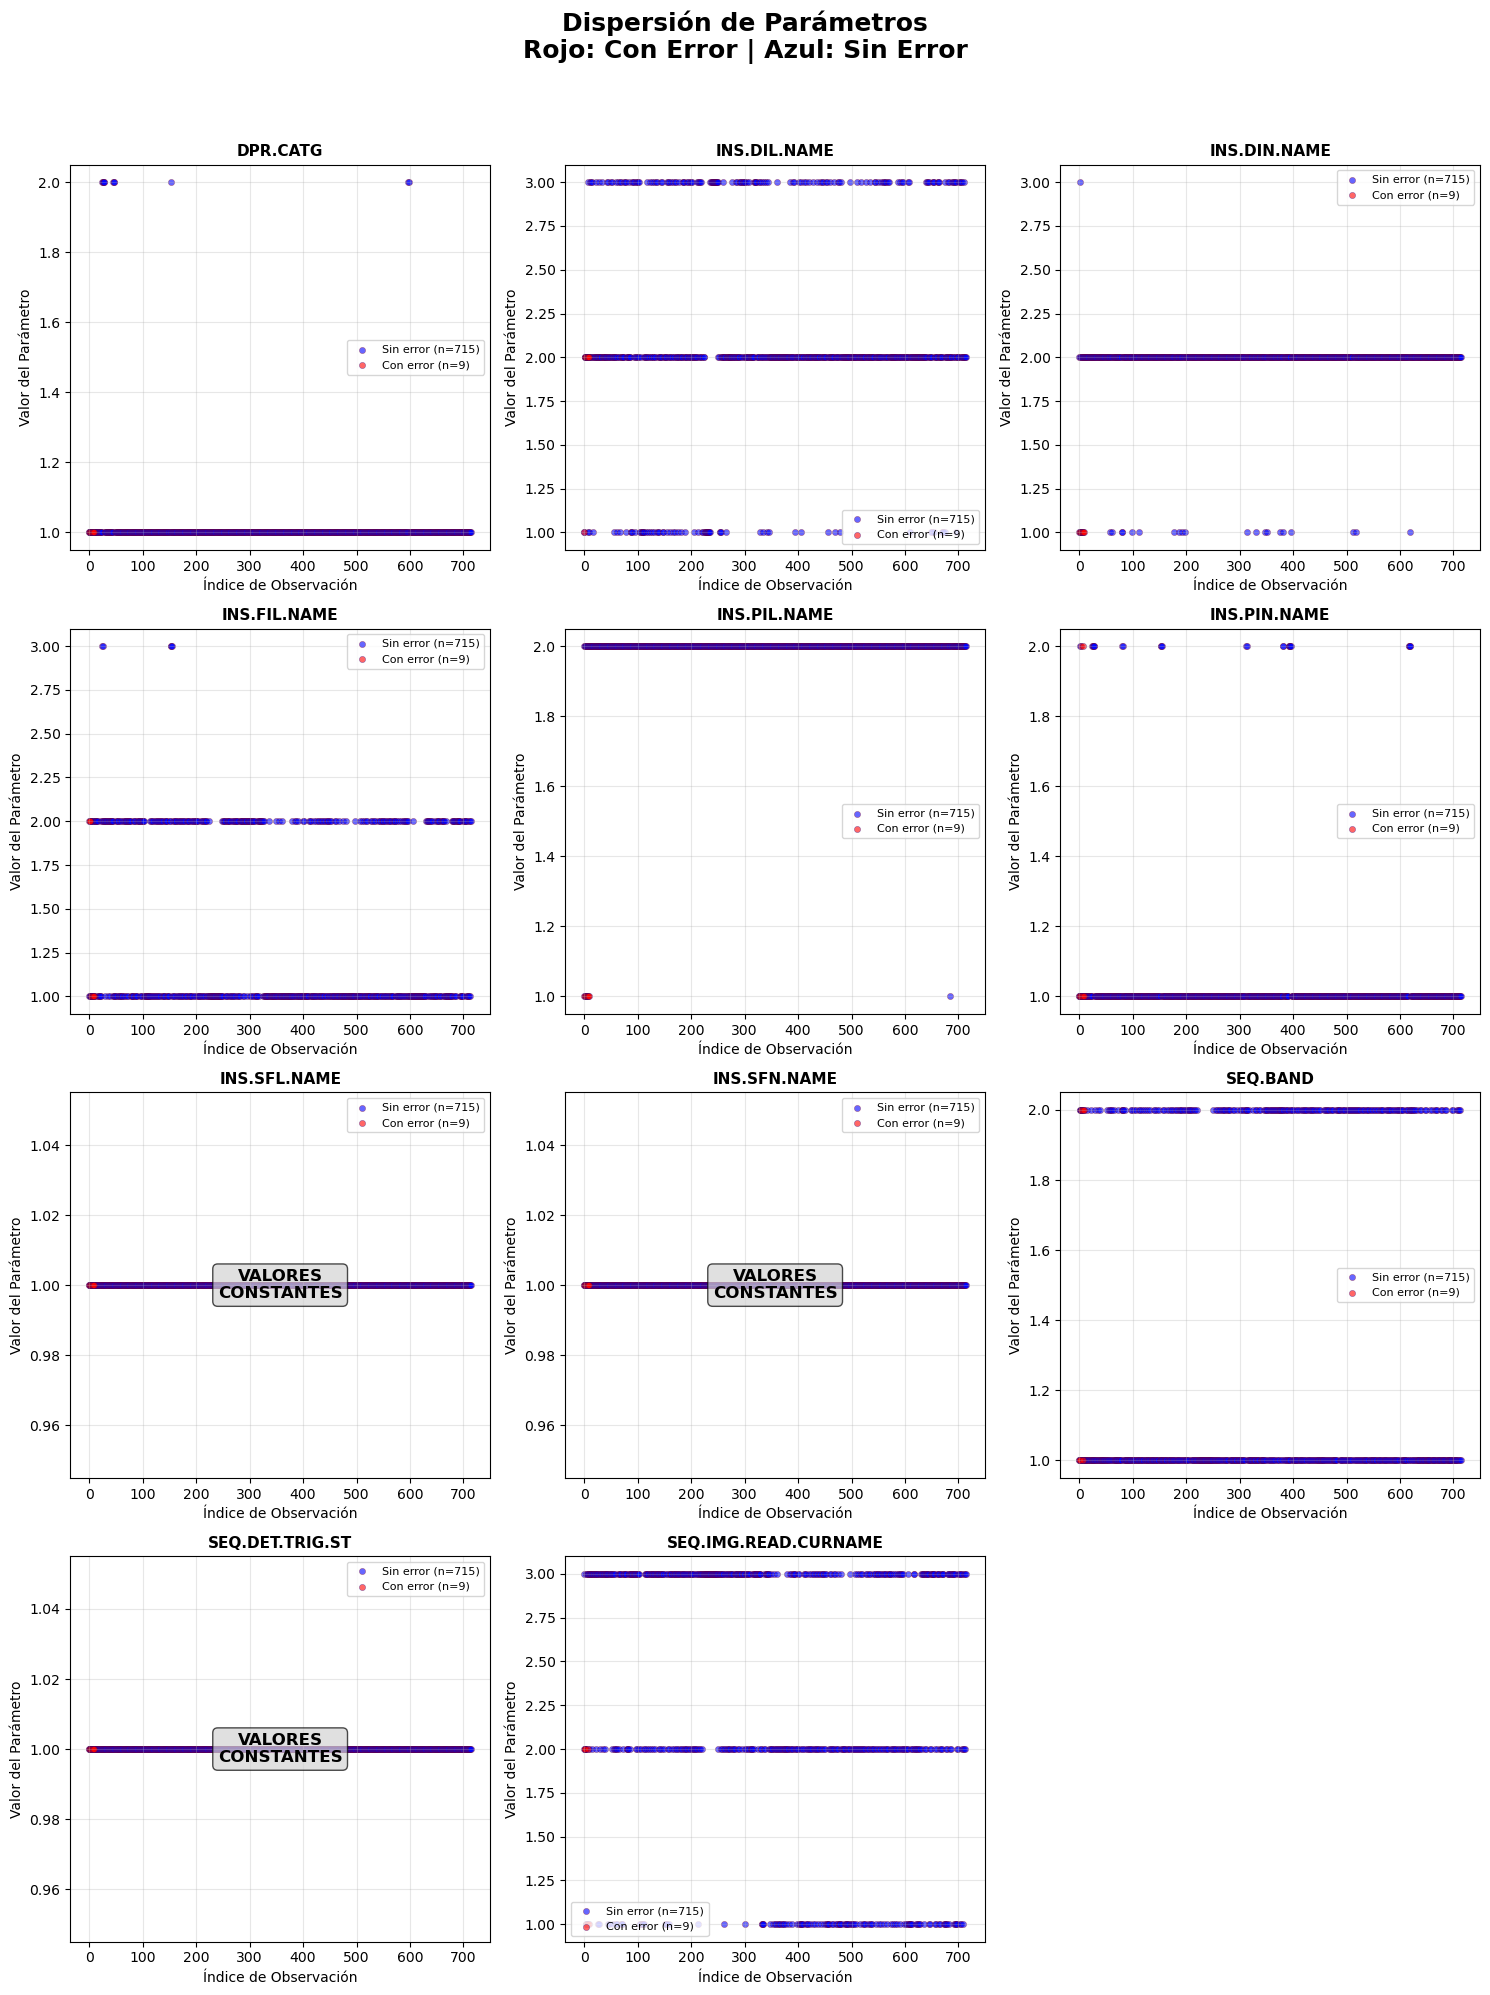


Graficando: params_strval_MATISSE_gen_cal_det_aq.csv
Creando gráficos para 12 parámetros...
Observaciones sin error: 7
Observaciones con error: 15


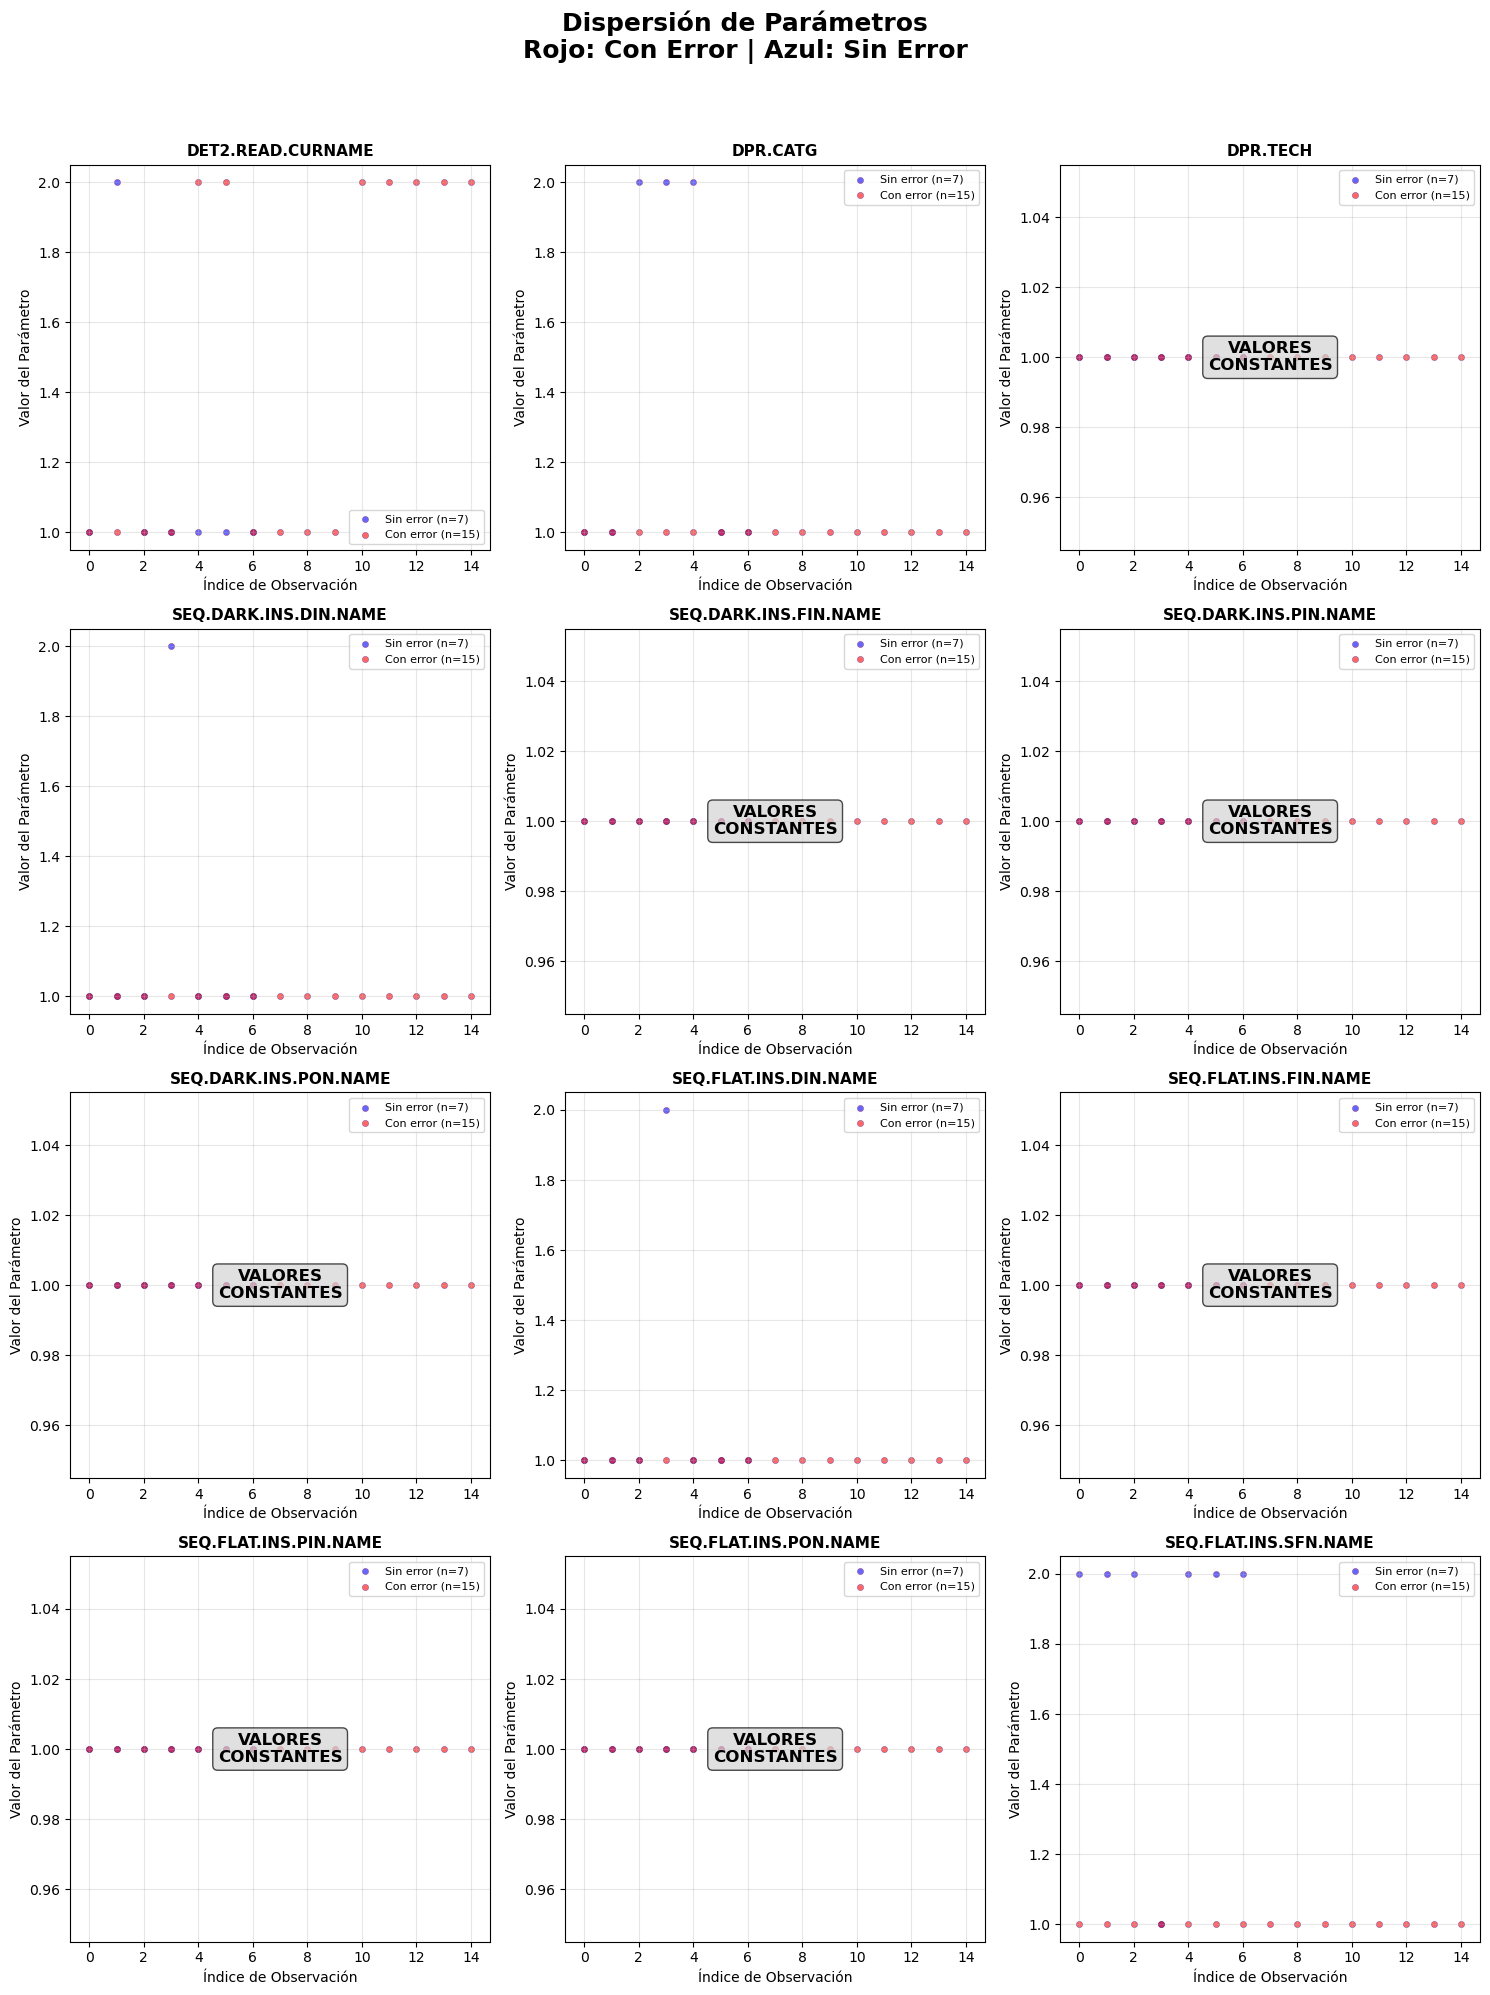


Graficando: params_strval_MATISSE_gen_cal_det_h2.csv
Creando gráficos para 12 parámetros...
Observaciones sin error: 18
Observaciones con error: 3


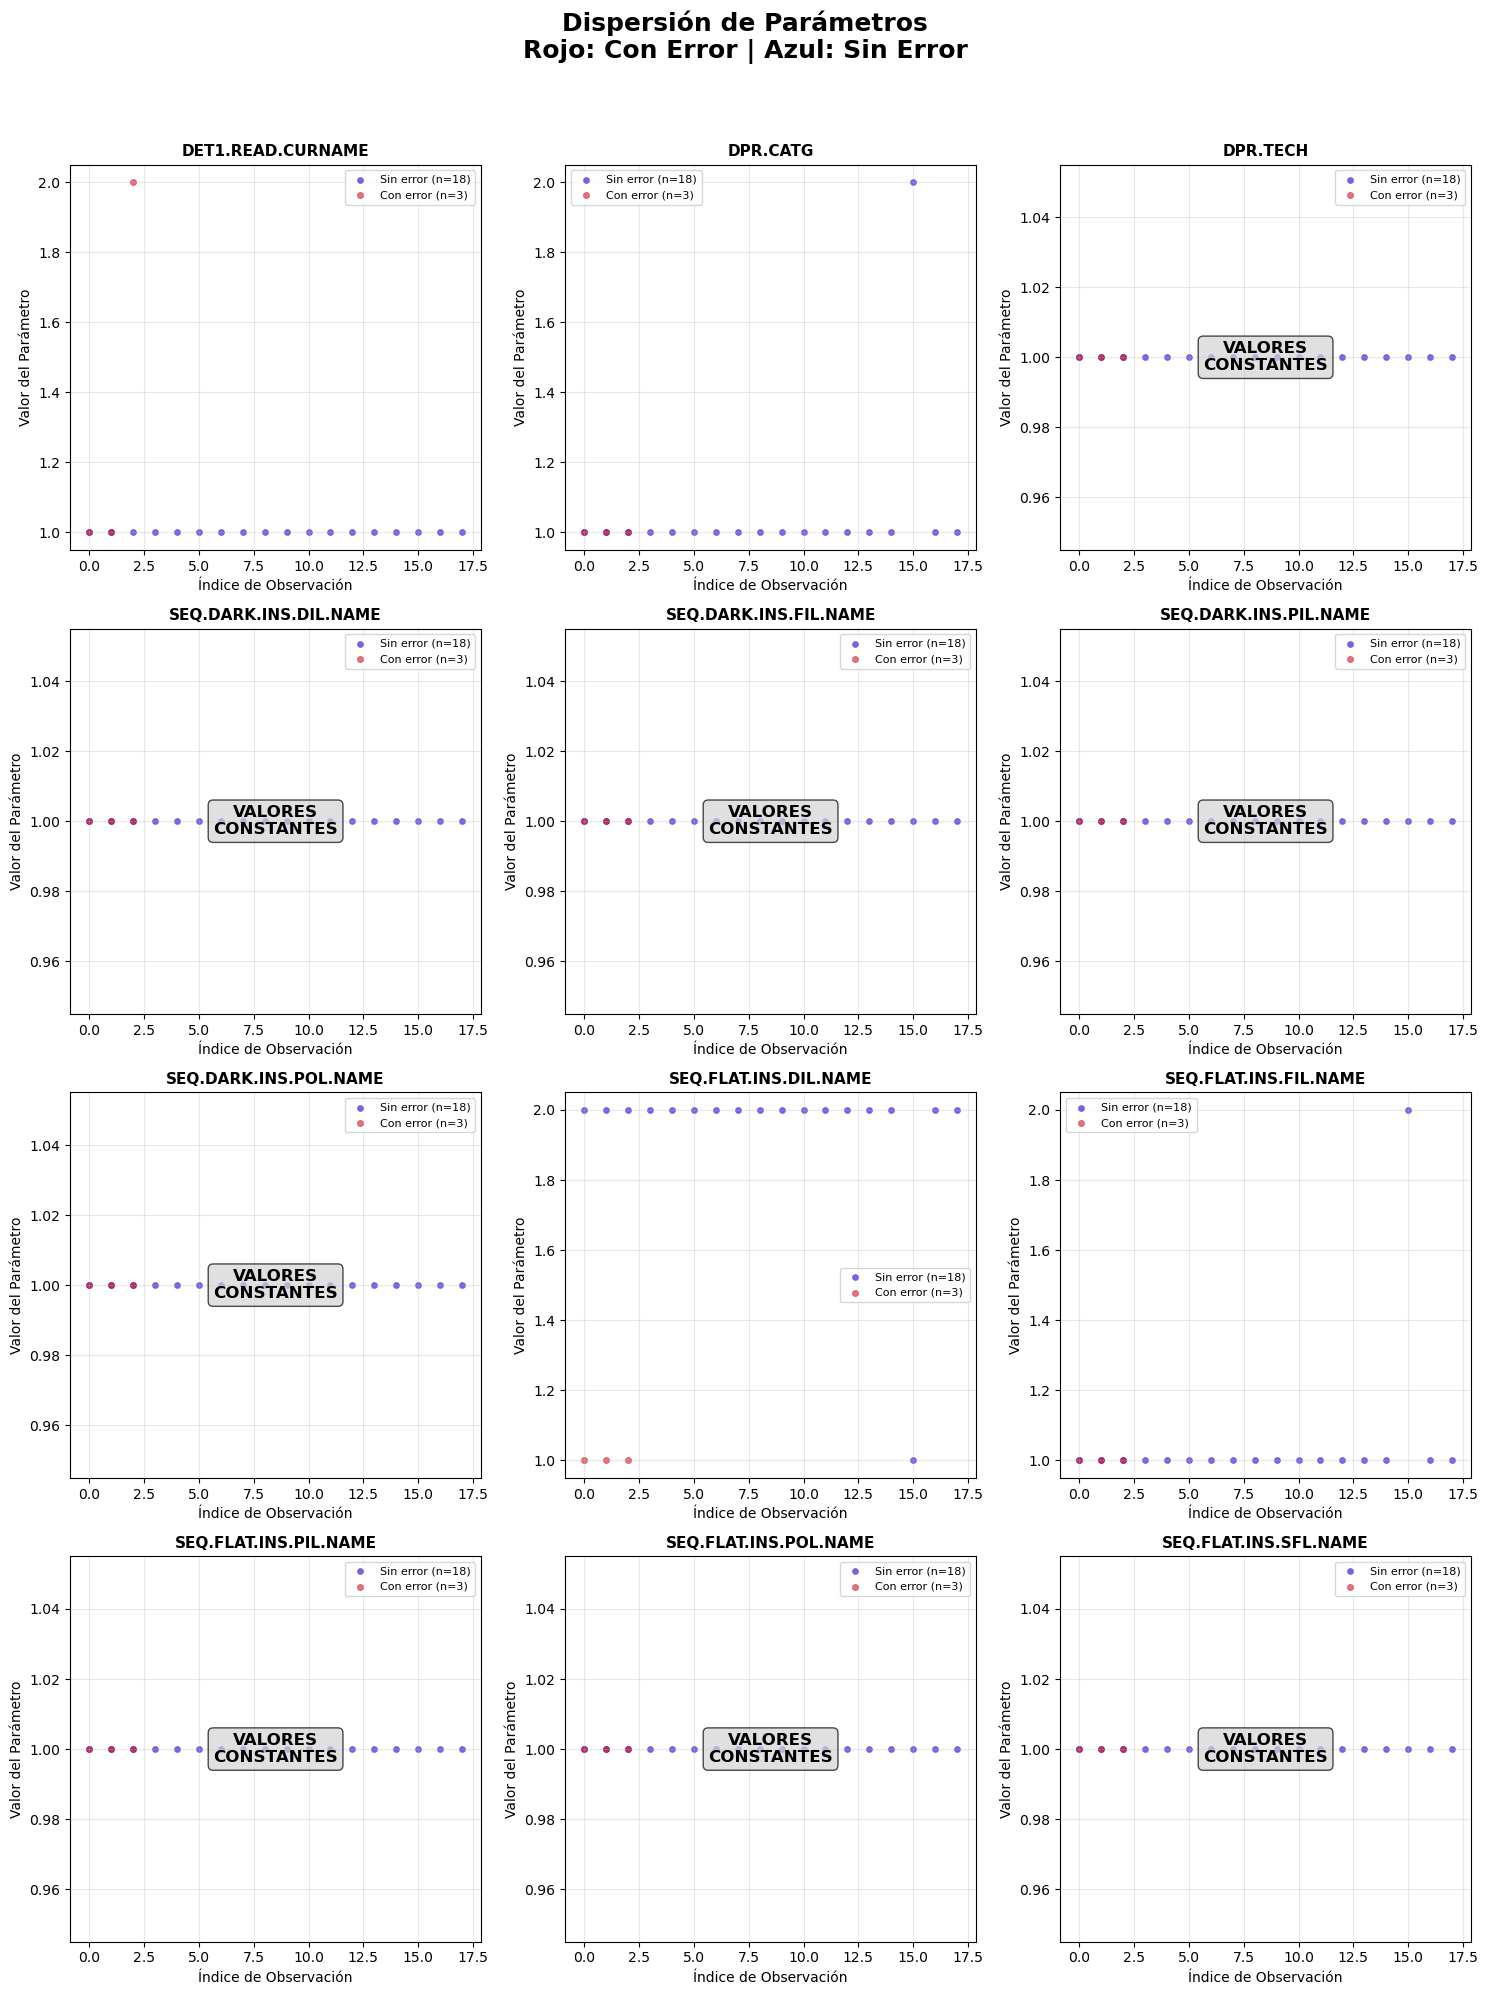


Graficando: params_strval_MATISSE_gen_cal_imbasic.csv
Creando gráficos para 17 parámetros...
Observaciones sin error: 393
Observaciones con error: 6


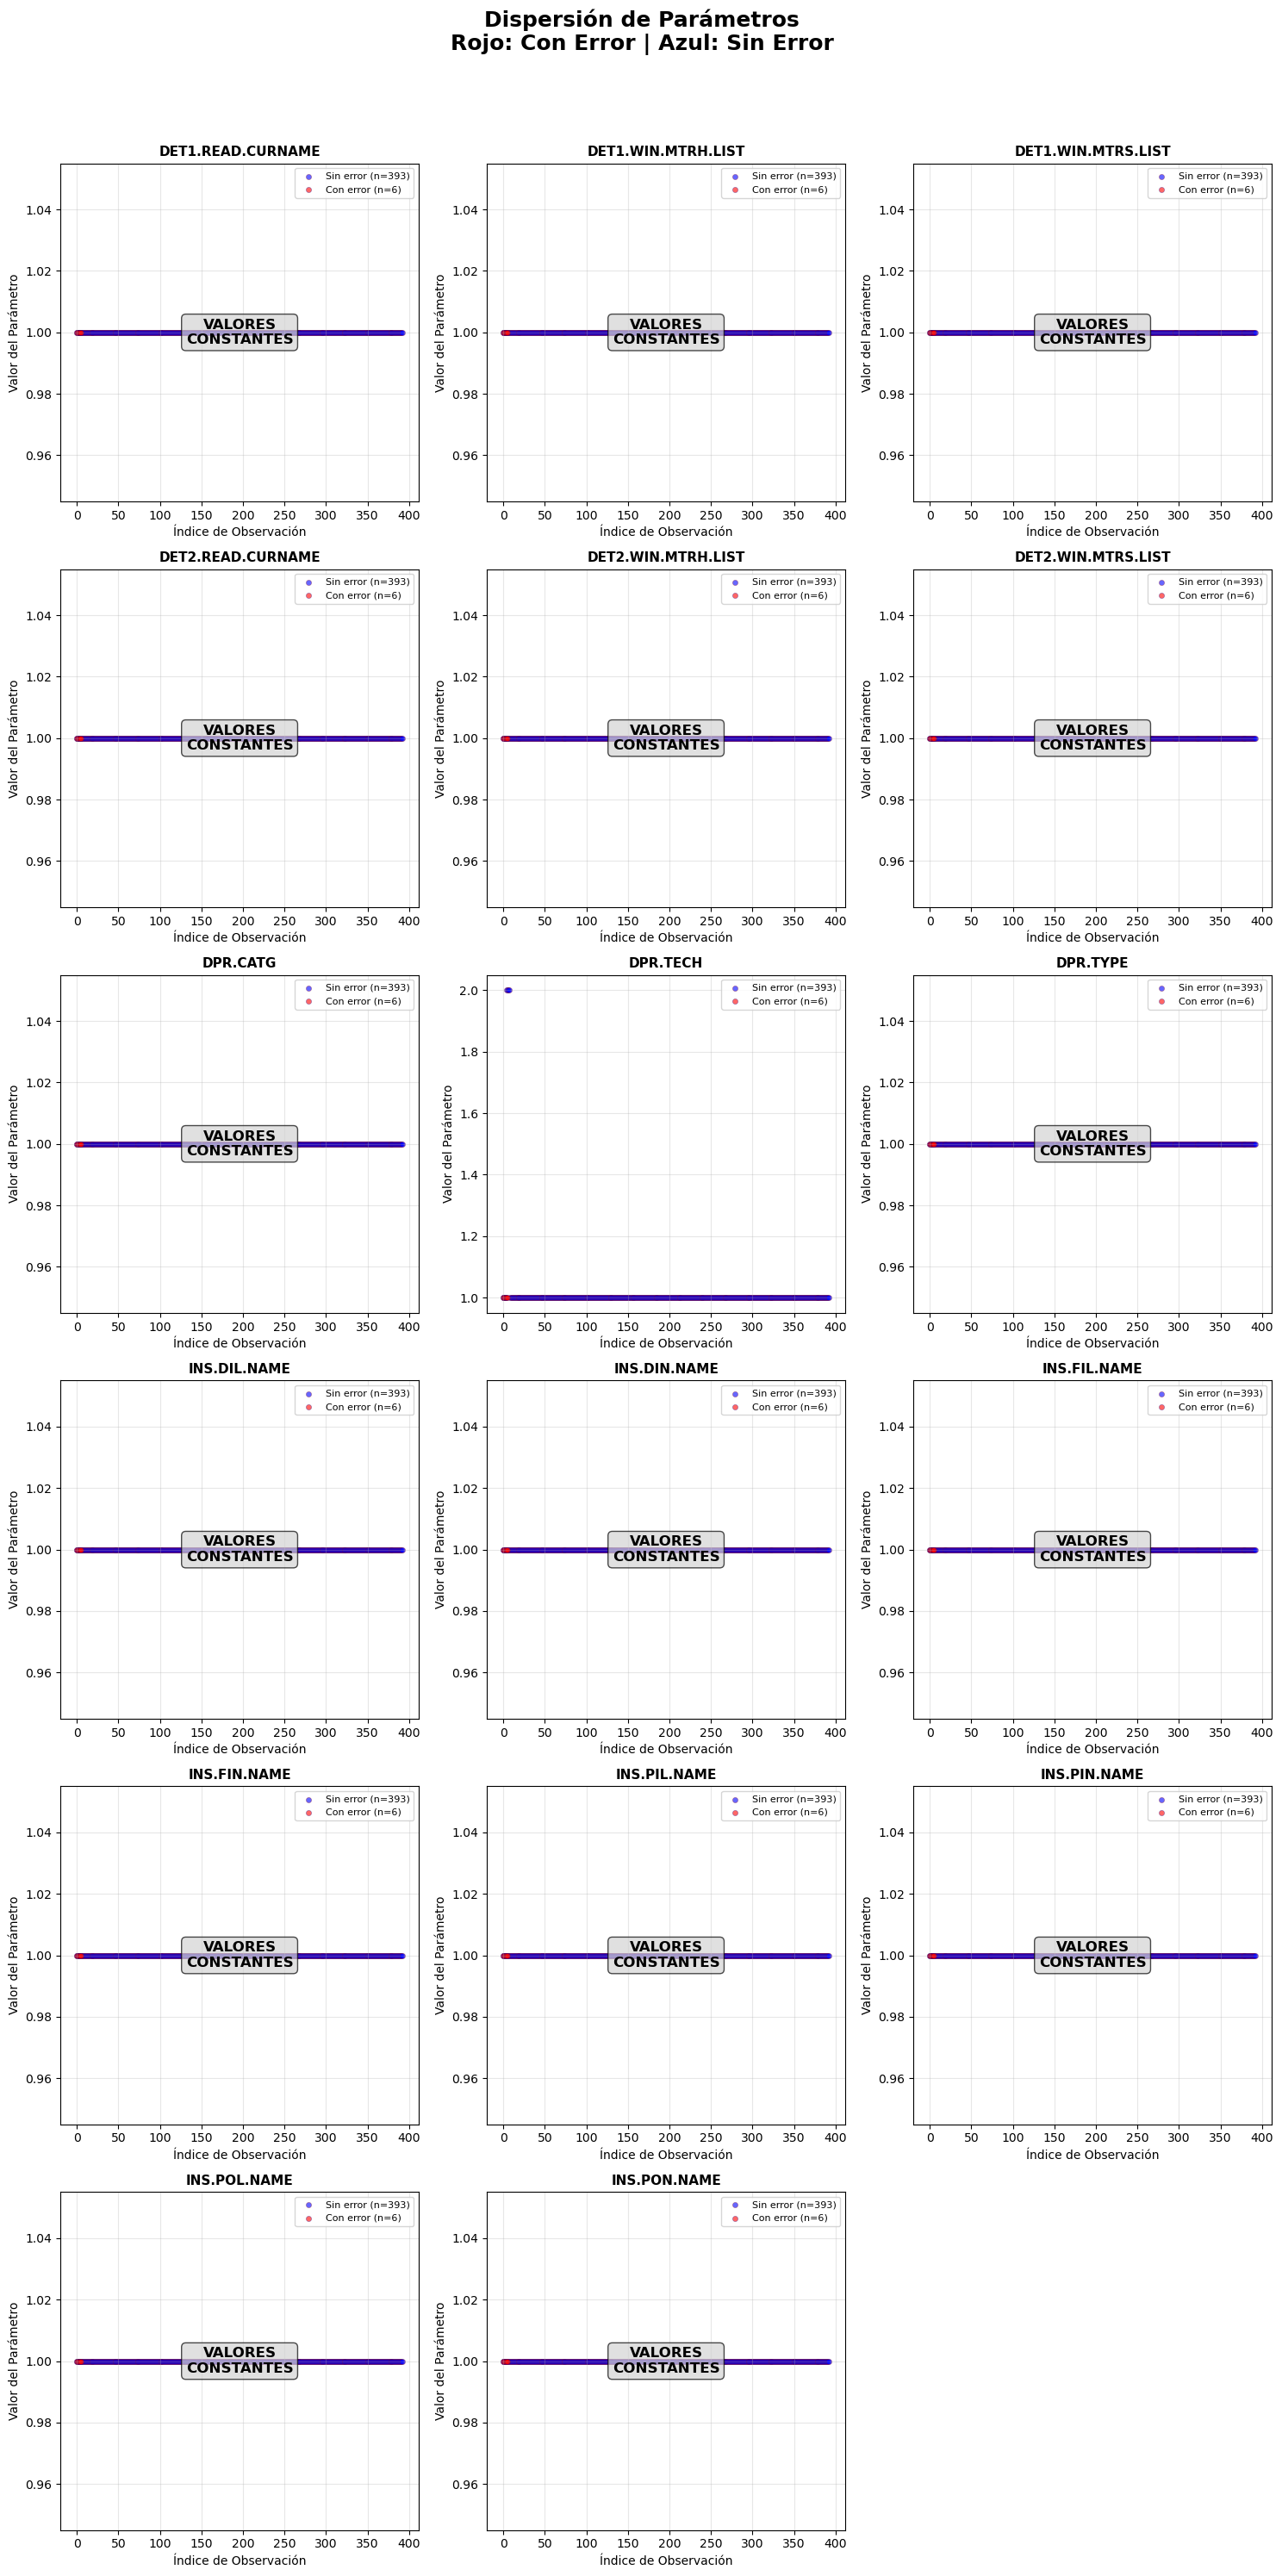


Graficando: params_strval_MATISSE_gen_cal_kappa.csv
Creando gráficos para 14 parámetros...
Observaciones sin error: 54
Observaciones con error: 2


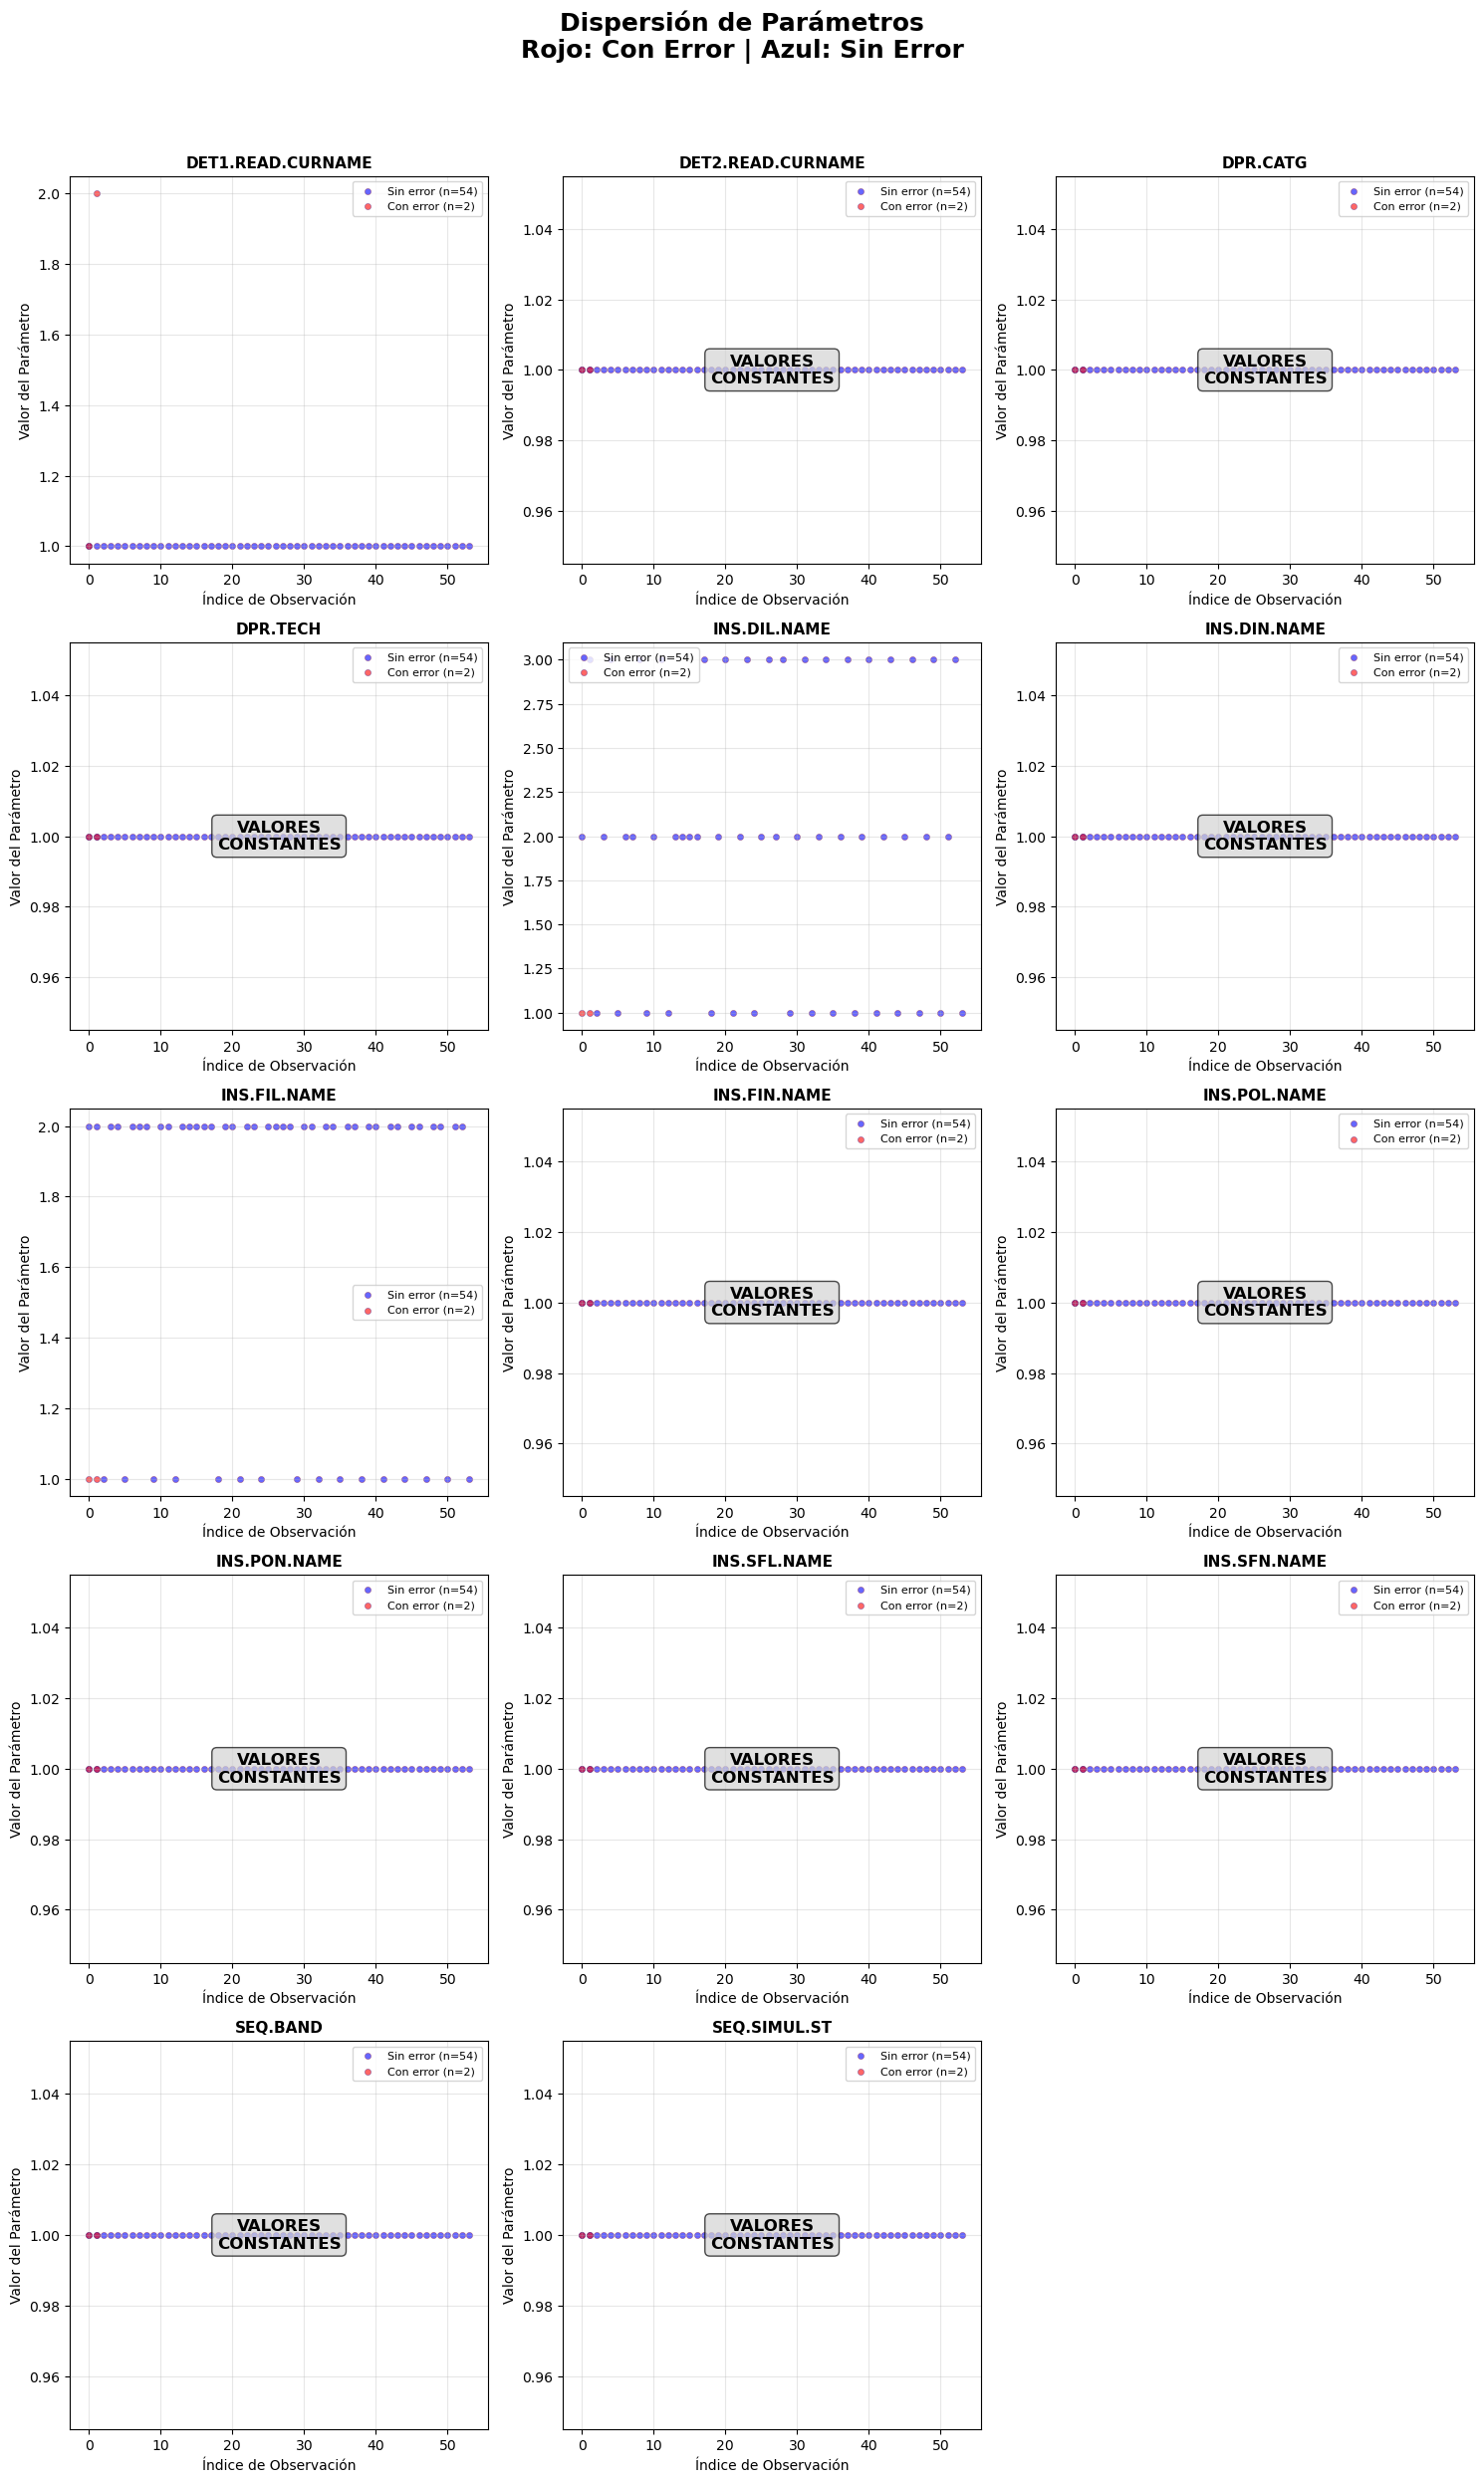


Graficando: params_strval_MATISSE_gen_cal_shift.csv
Creando gráficos para 10 parámetros...
Observaciones sin error: 47
Observaciones con error: 3


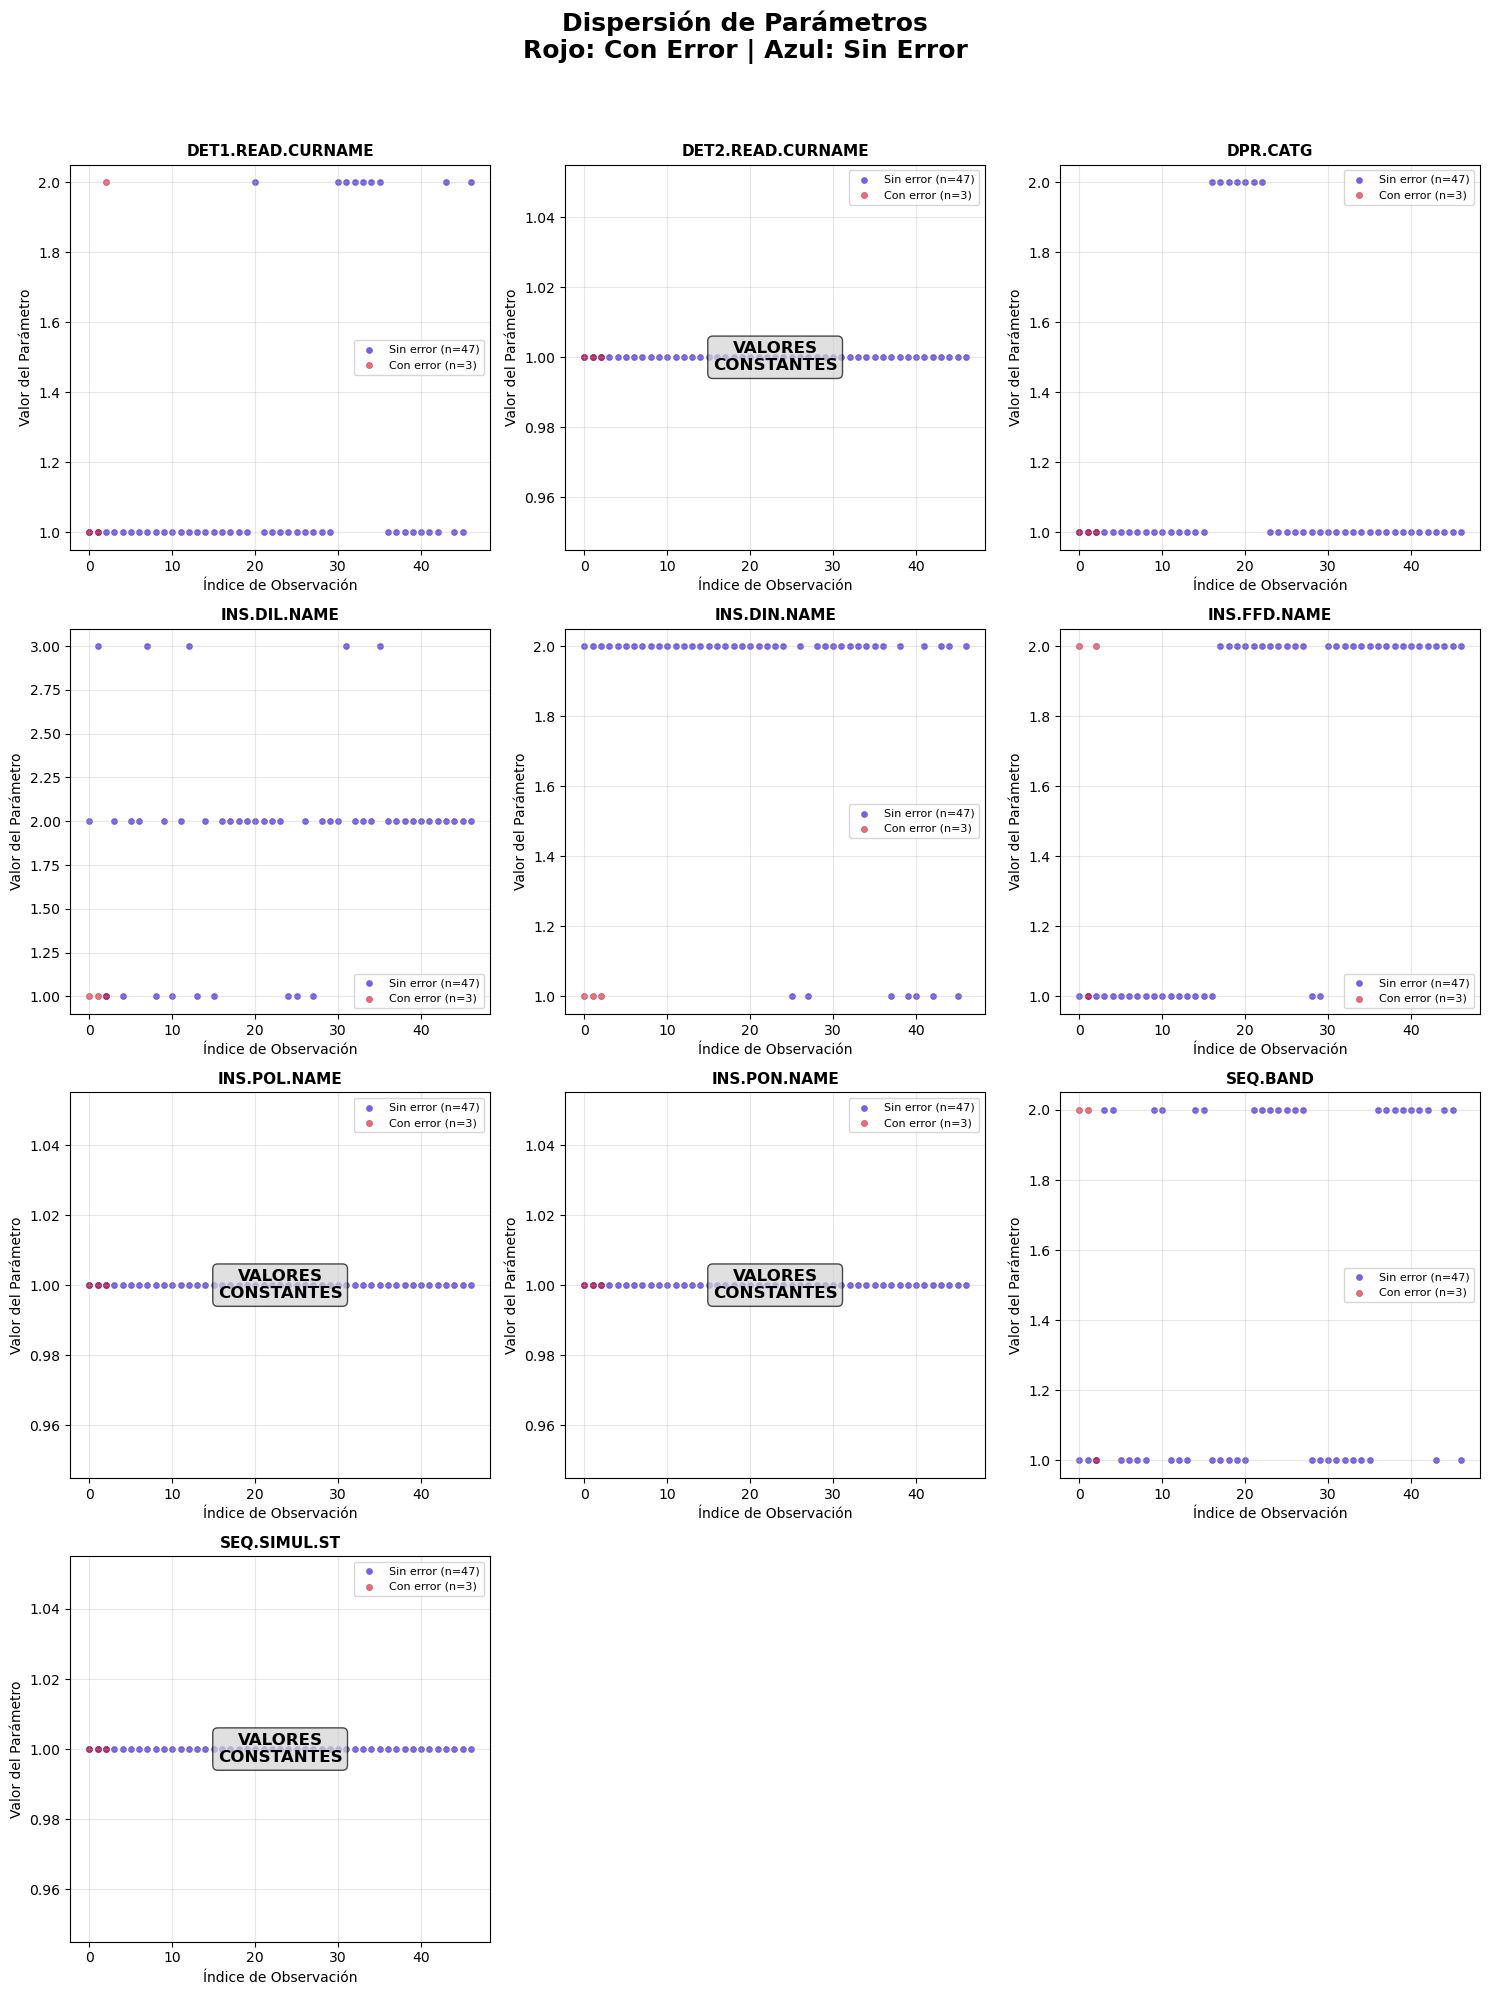


Graficando: params_strval_MATISSE_gen_cal_transfunc.csv
Creando gráficos para 21 parámetros...
Observaciones sin error: 240
Observaciones con error: 1


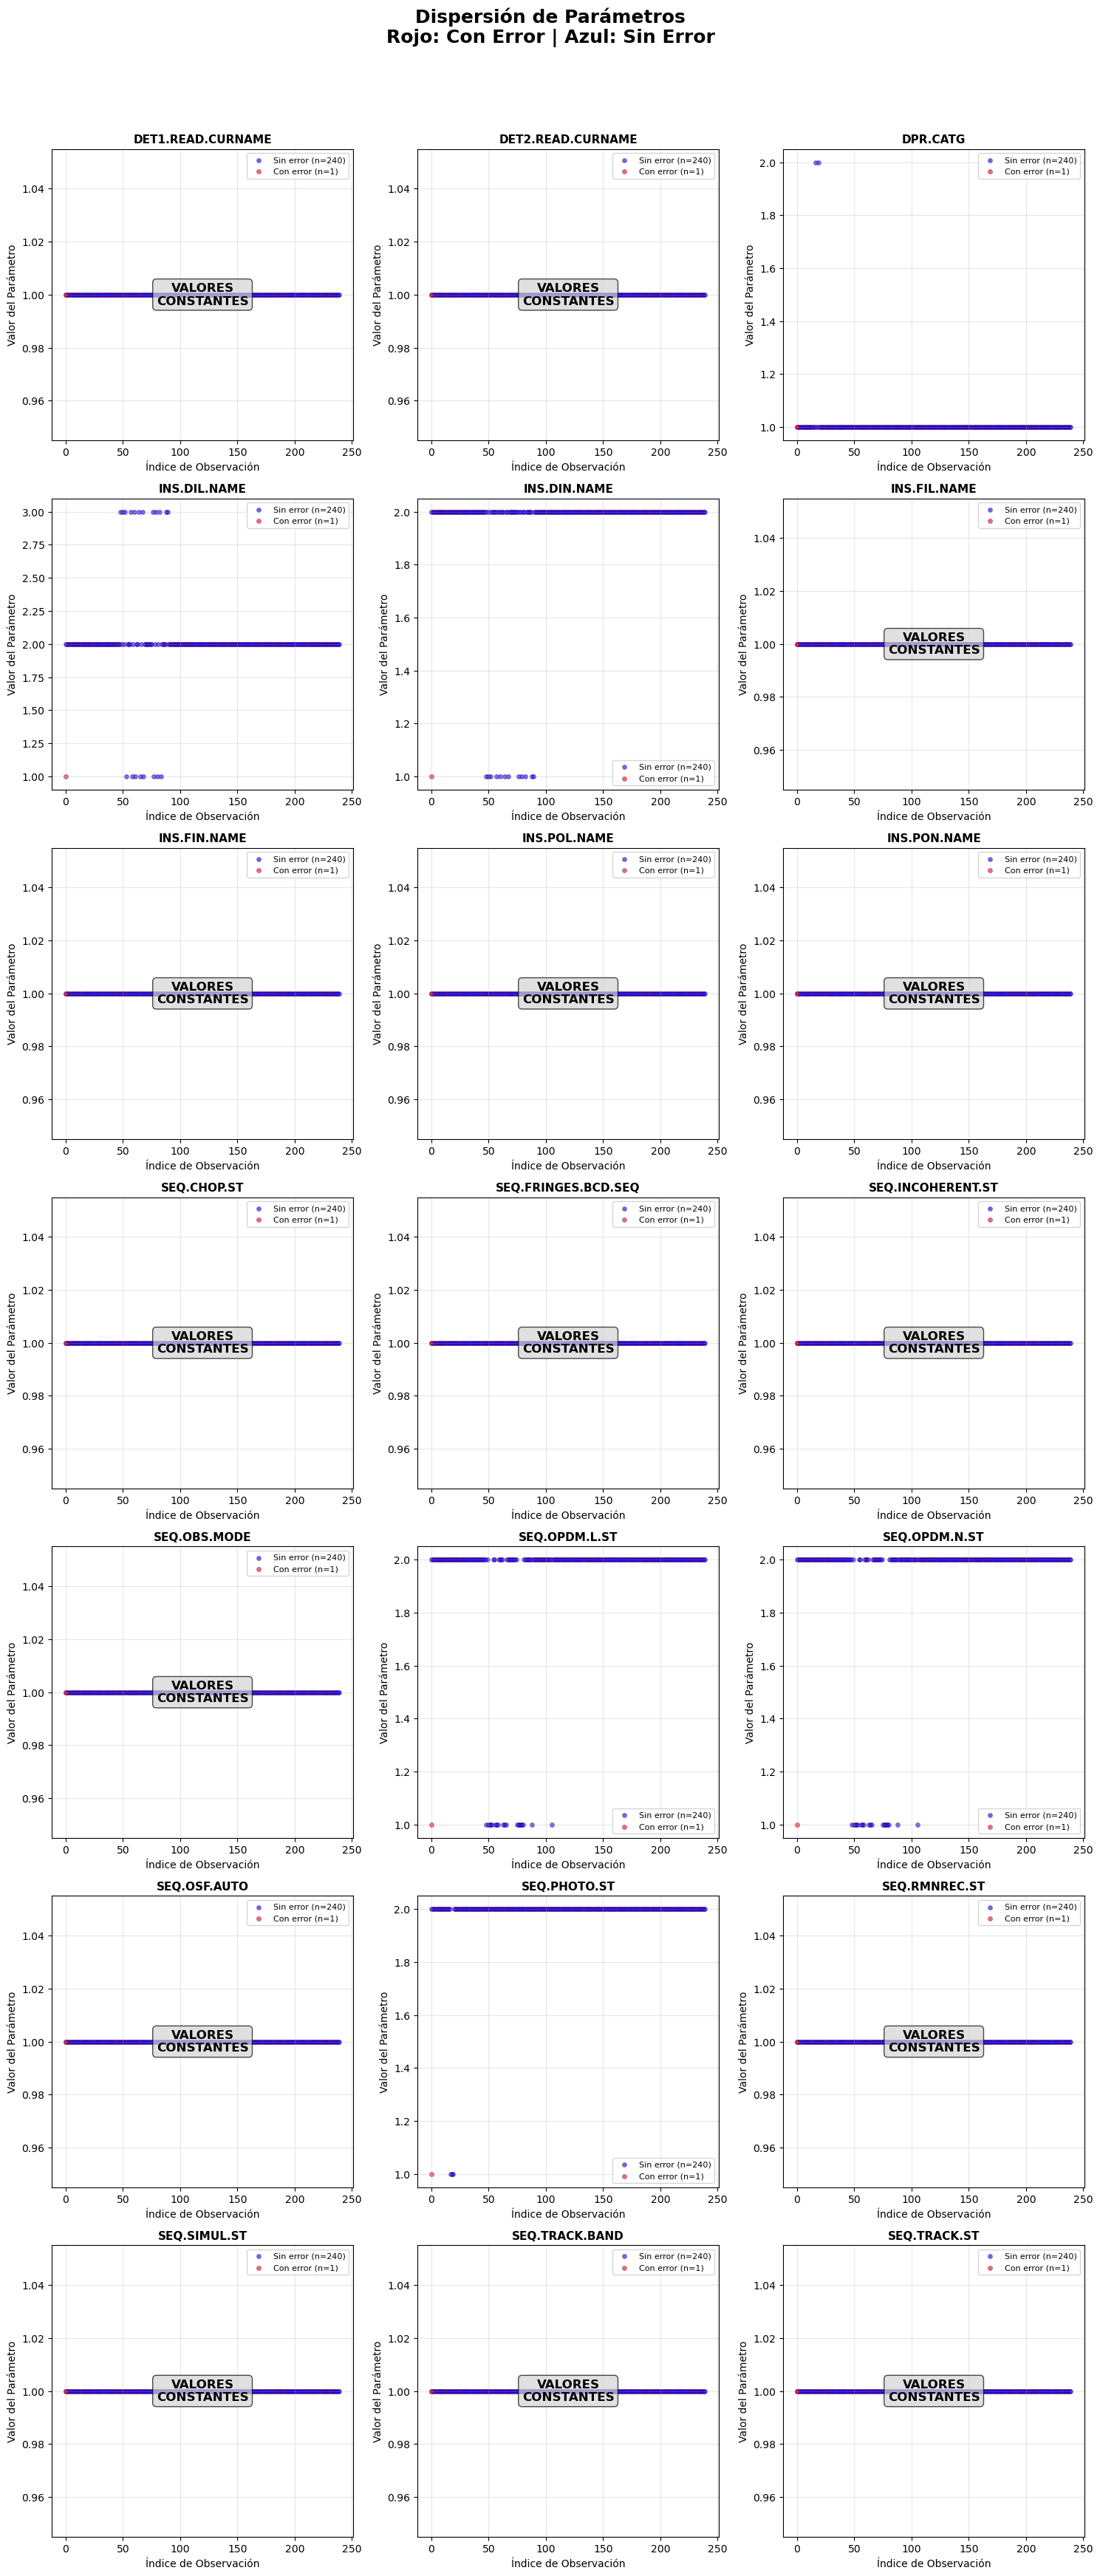


Graficando: params_strval_MATISSE_gen_tec_ali.csv
Creando gráficos para 8 parámetros...
Observaciones sin error: 116
Observaciones con error: 67


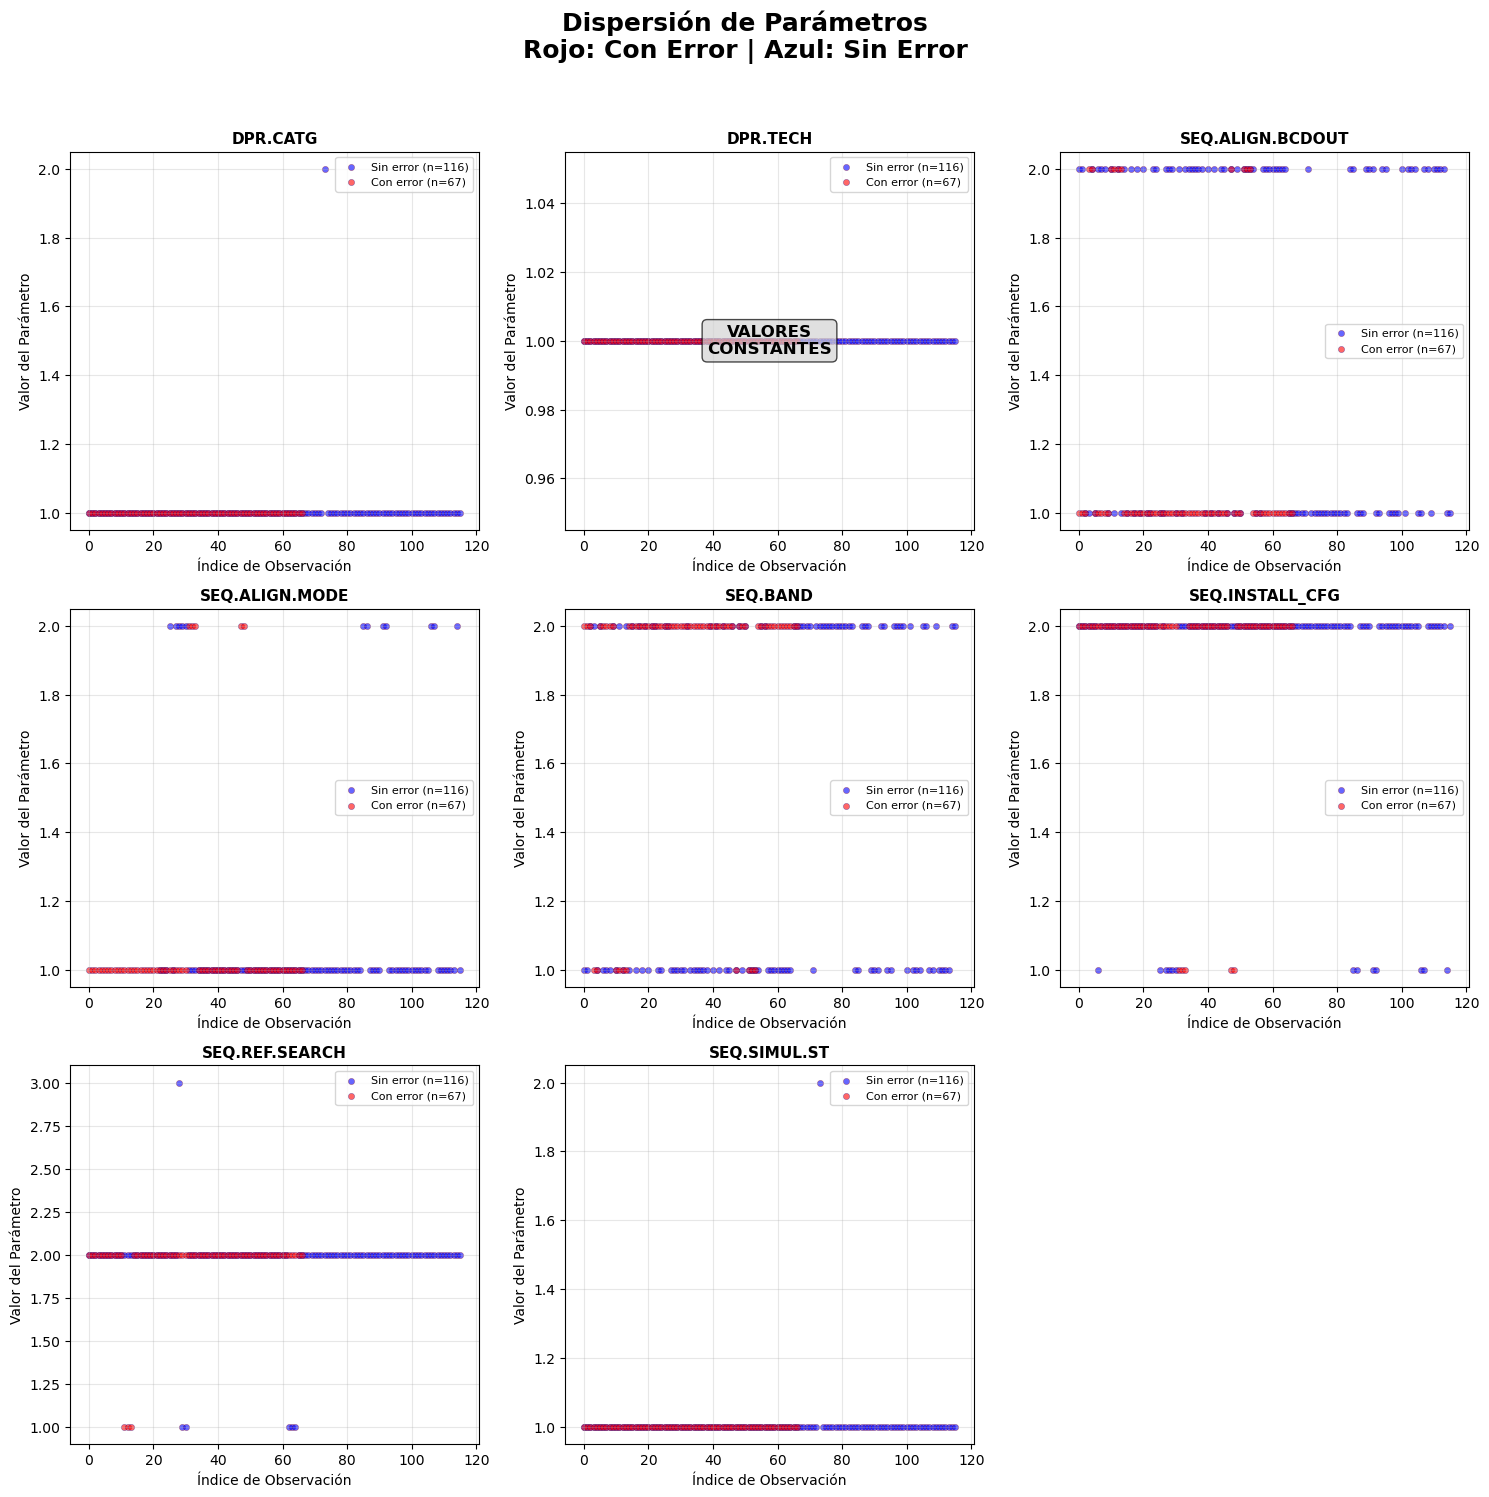


Graficando: params_strval_MATISSE_gen_tec_check_fringes.csv
Creando gráficos para 14 parámetros...
Observaciones sin error: 173
Observaciones con error: 10


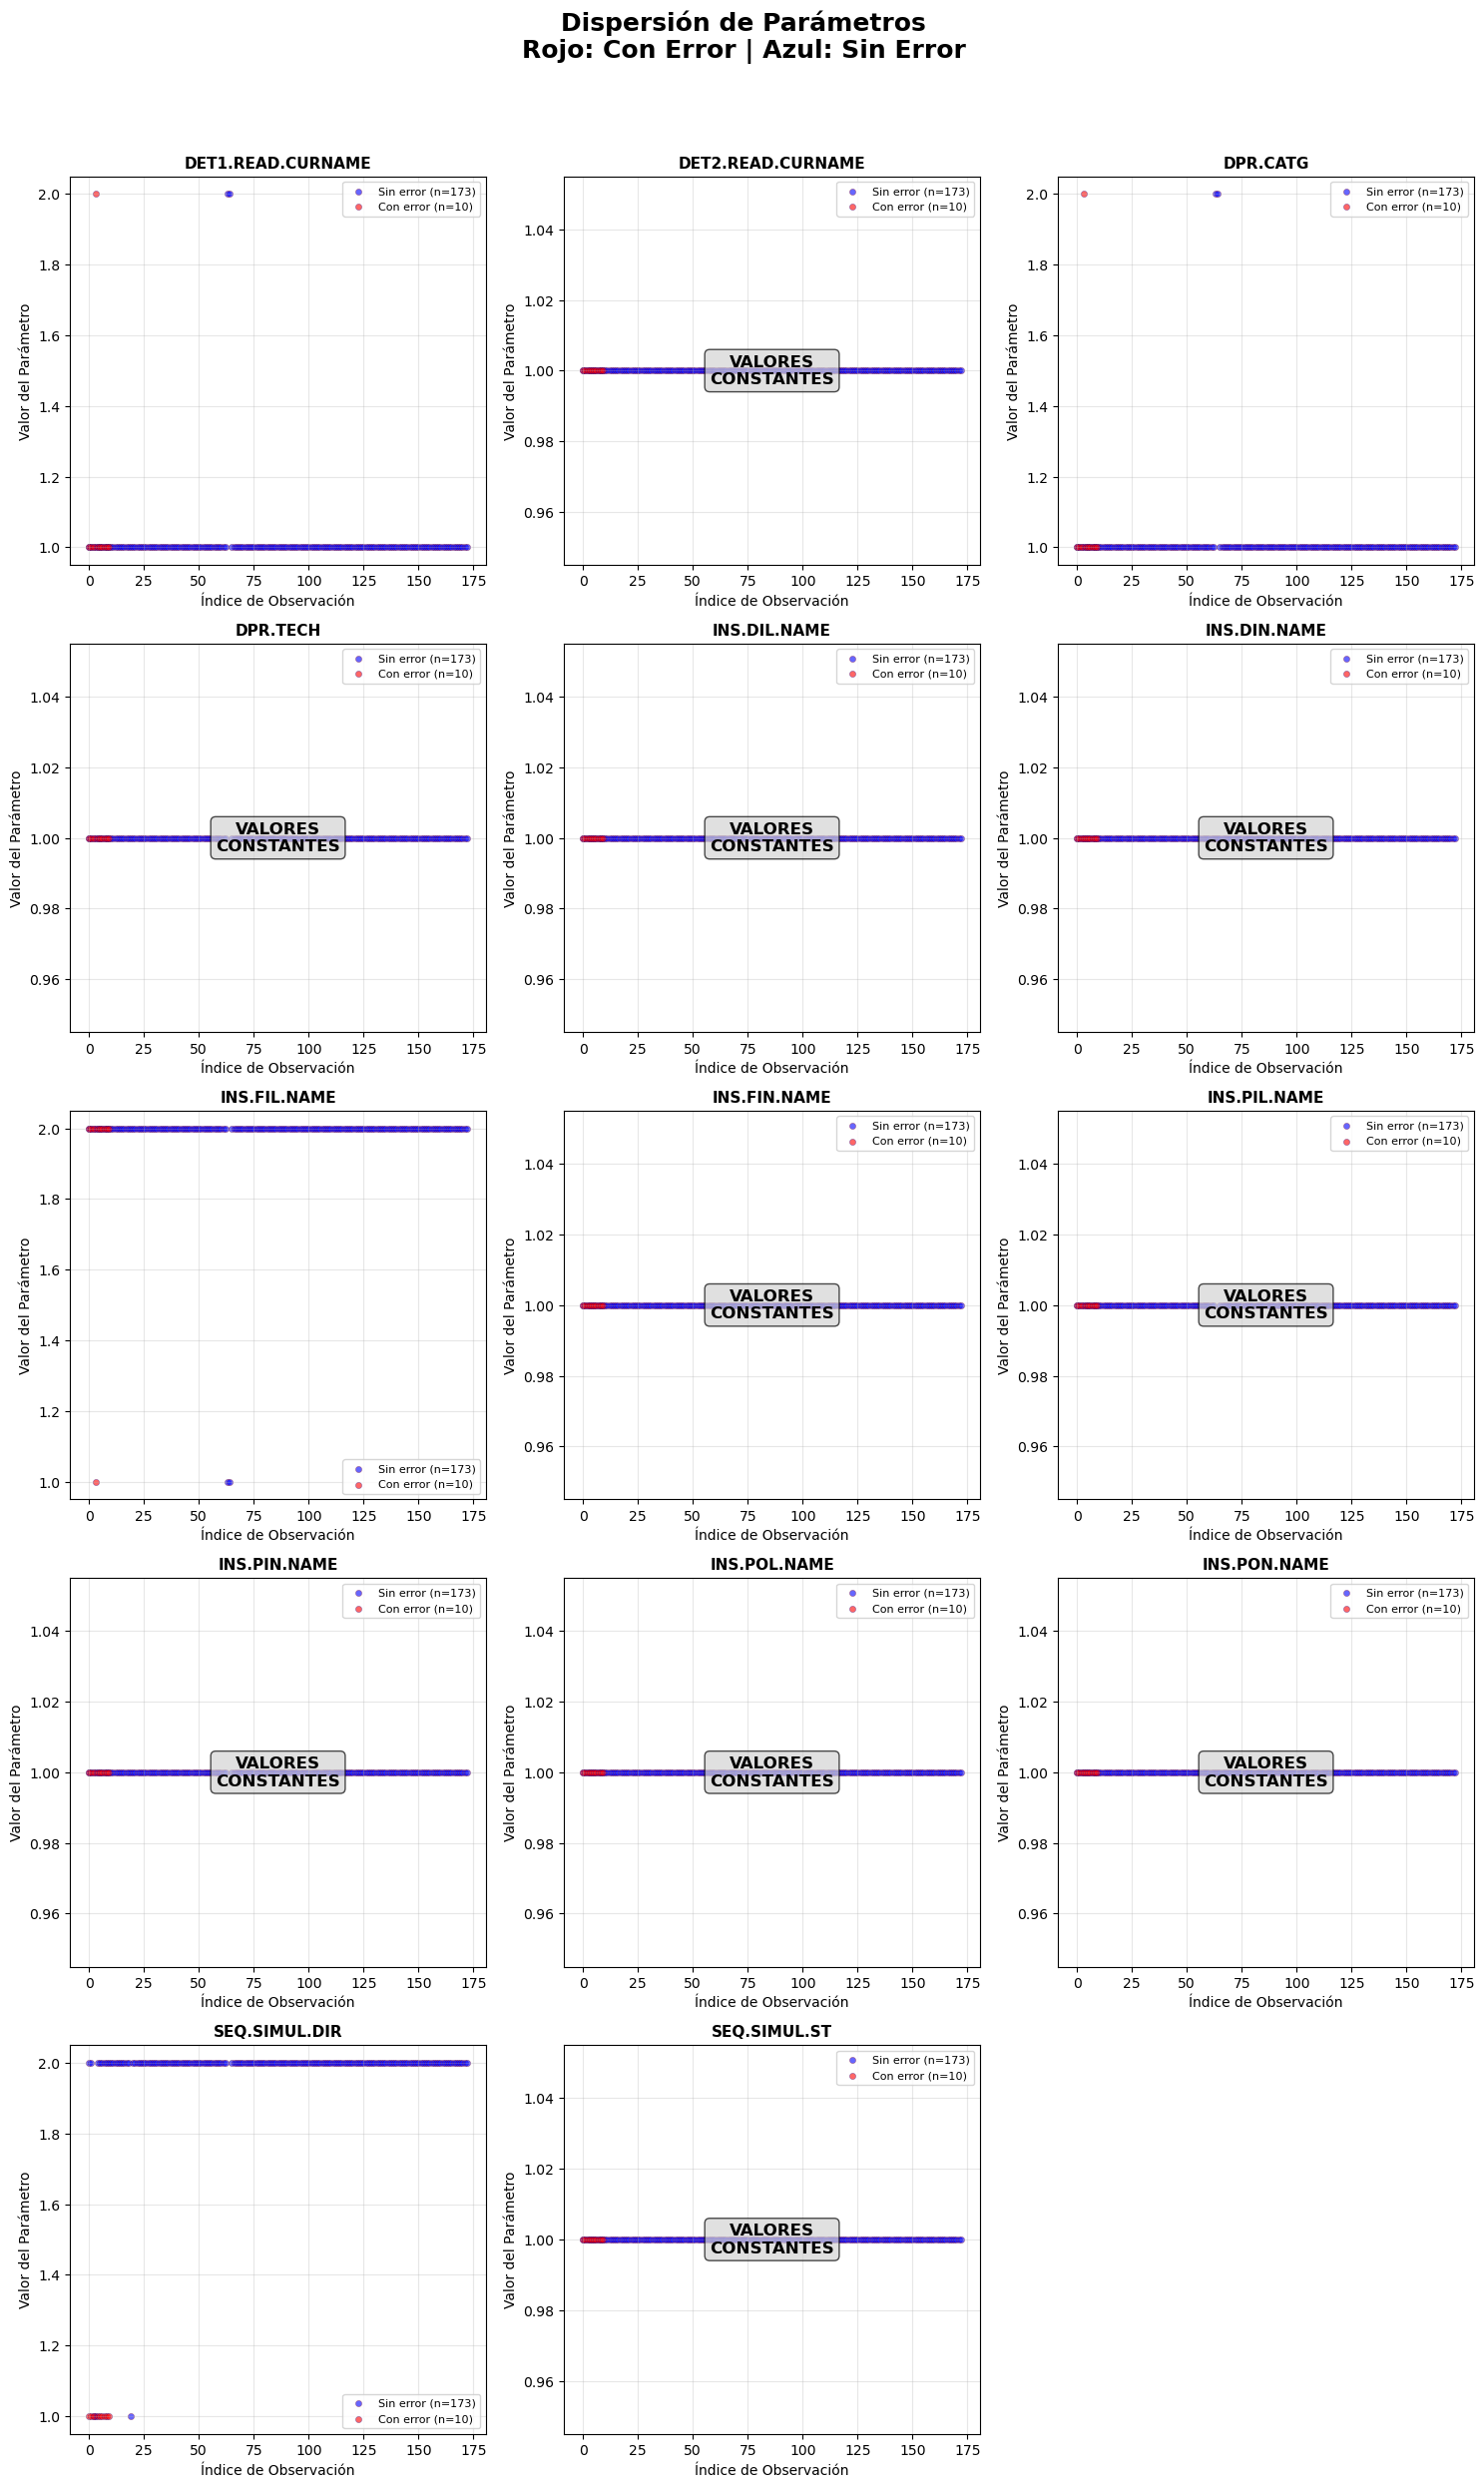


Graficando: params_strval_MATISSE_gen_tec_opd.csv
Creando gráficos para 18 parámetros...
Observaciones sin error: 1030
Observaciones con error: 18


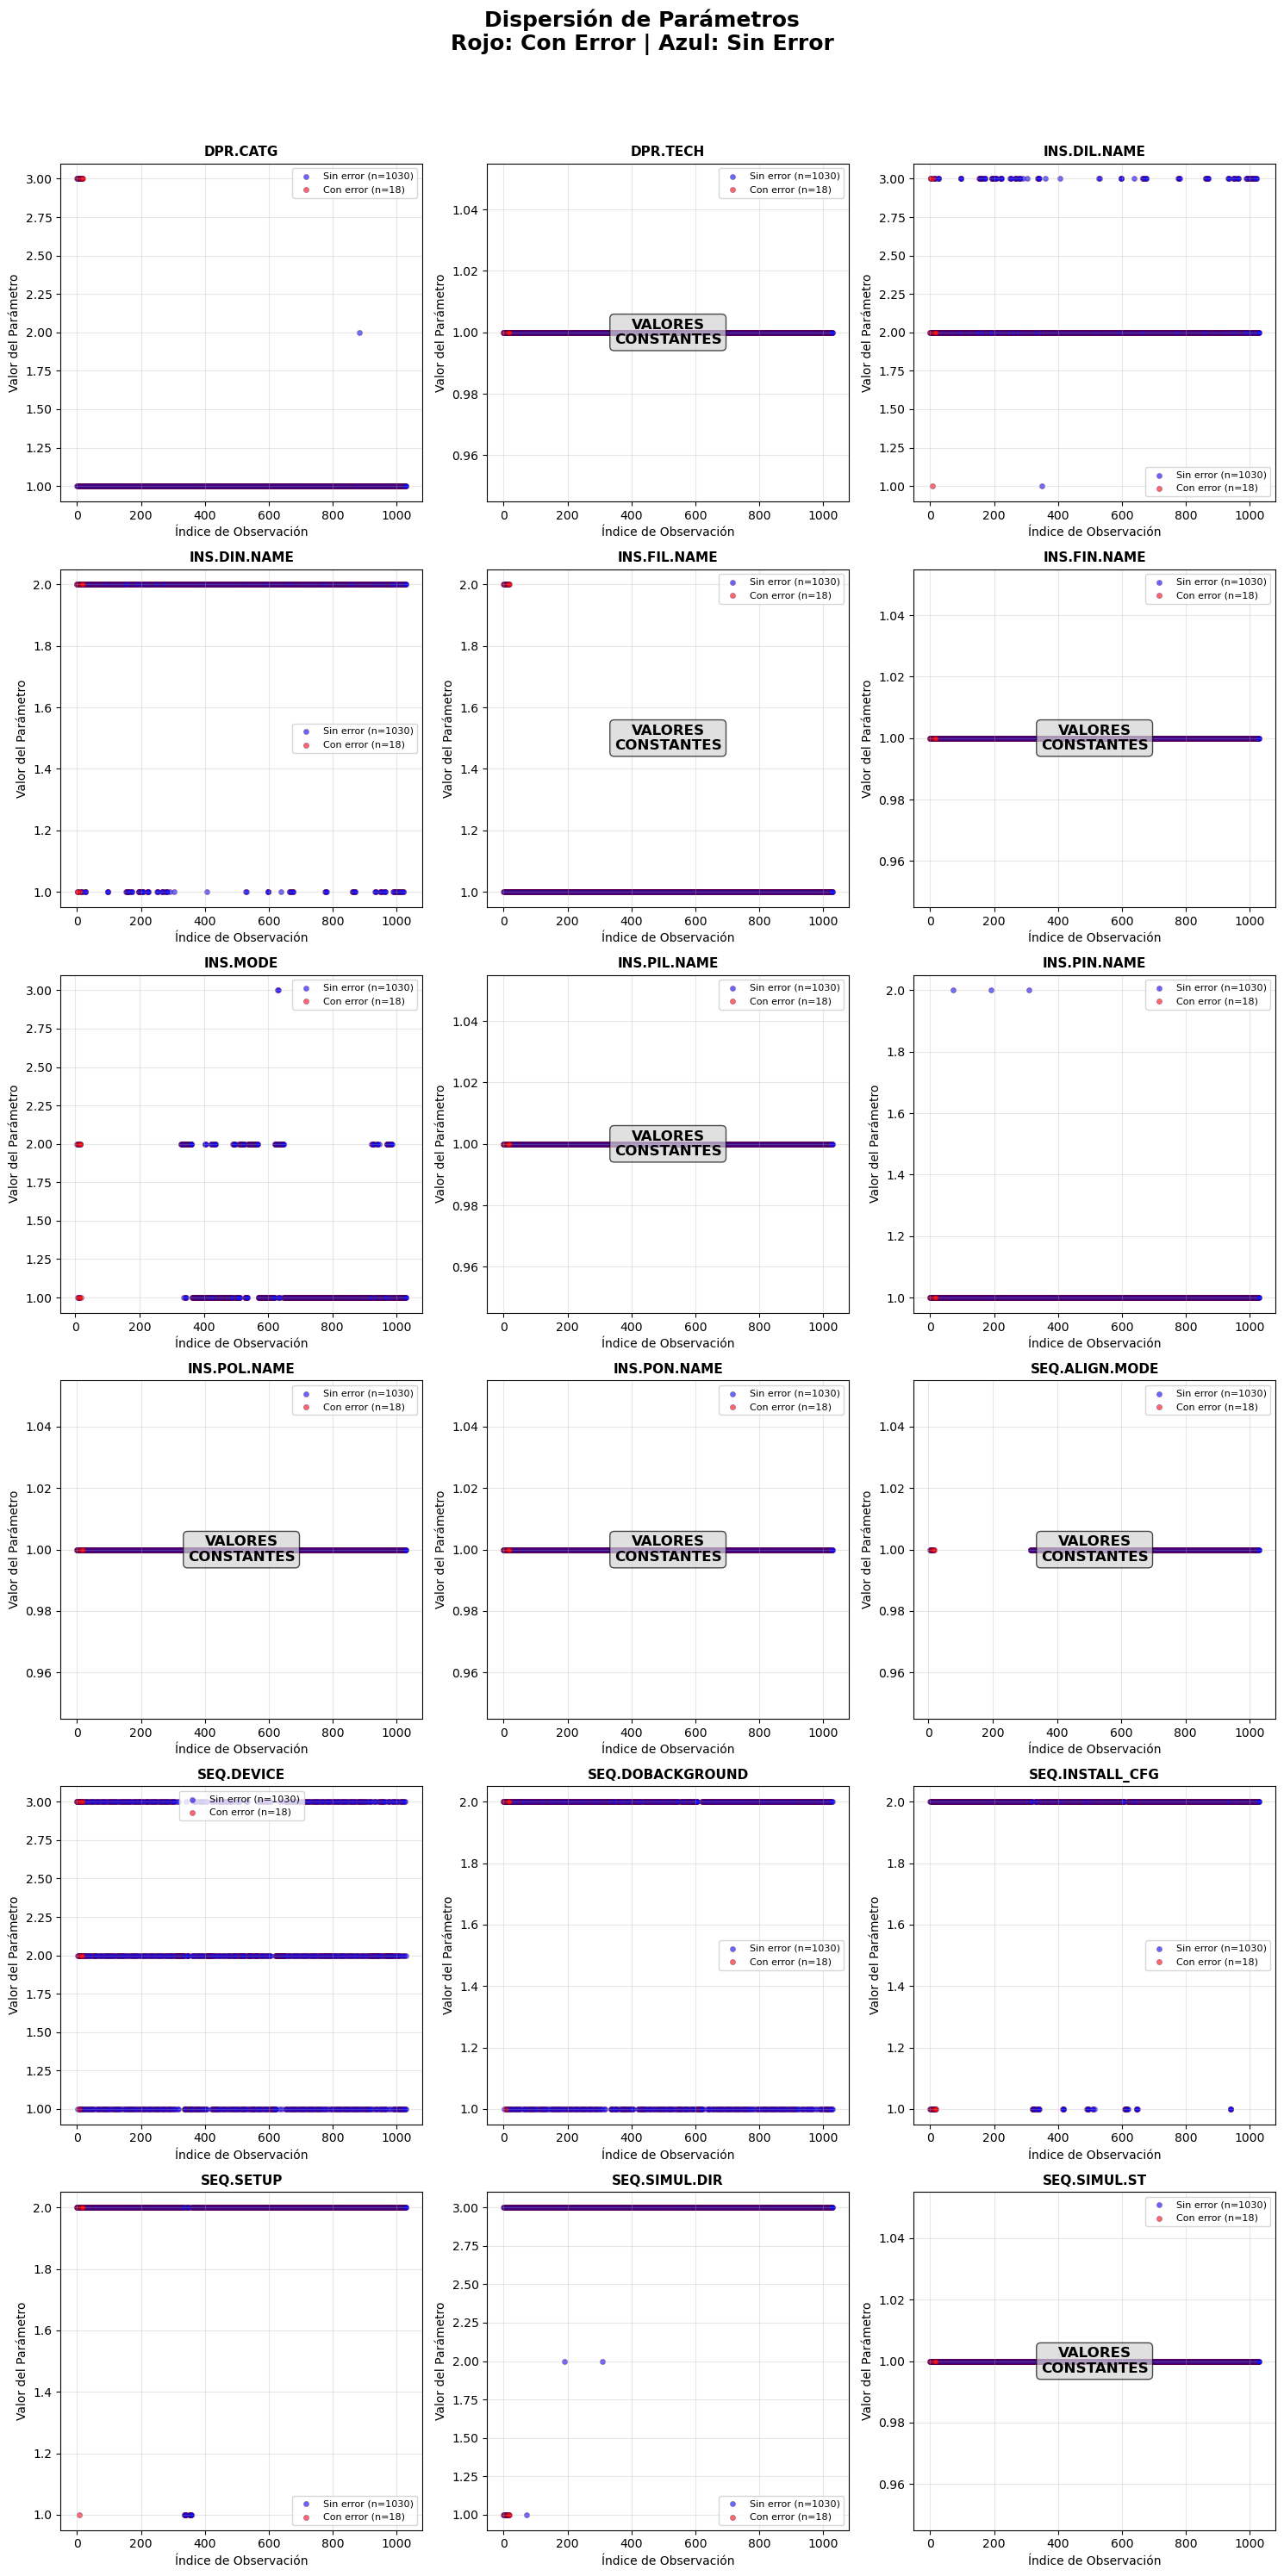


Graficando: params_strval_MATISSE_gen_tec_piezos.csv
Creando gráficos para 16 parámetros...
Observaciones sin error: 11
Observaciones con error: 2


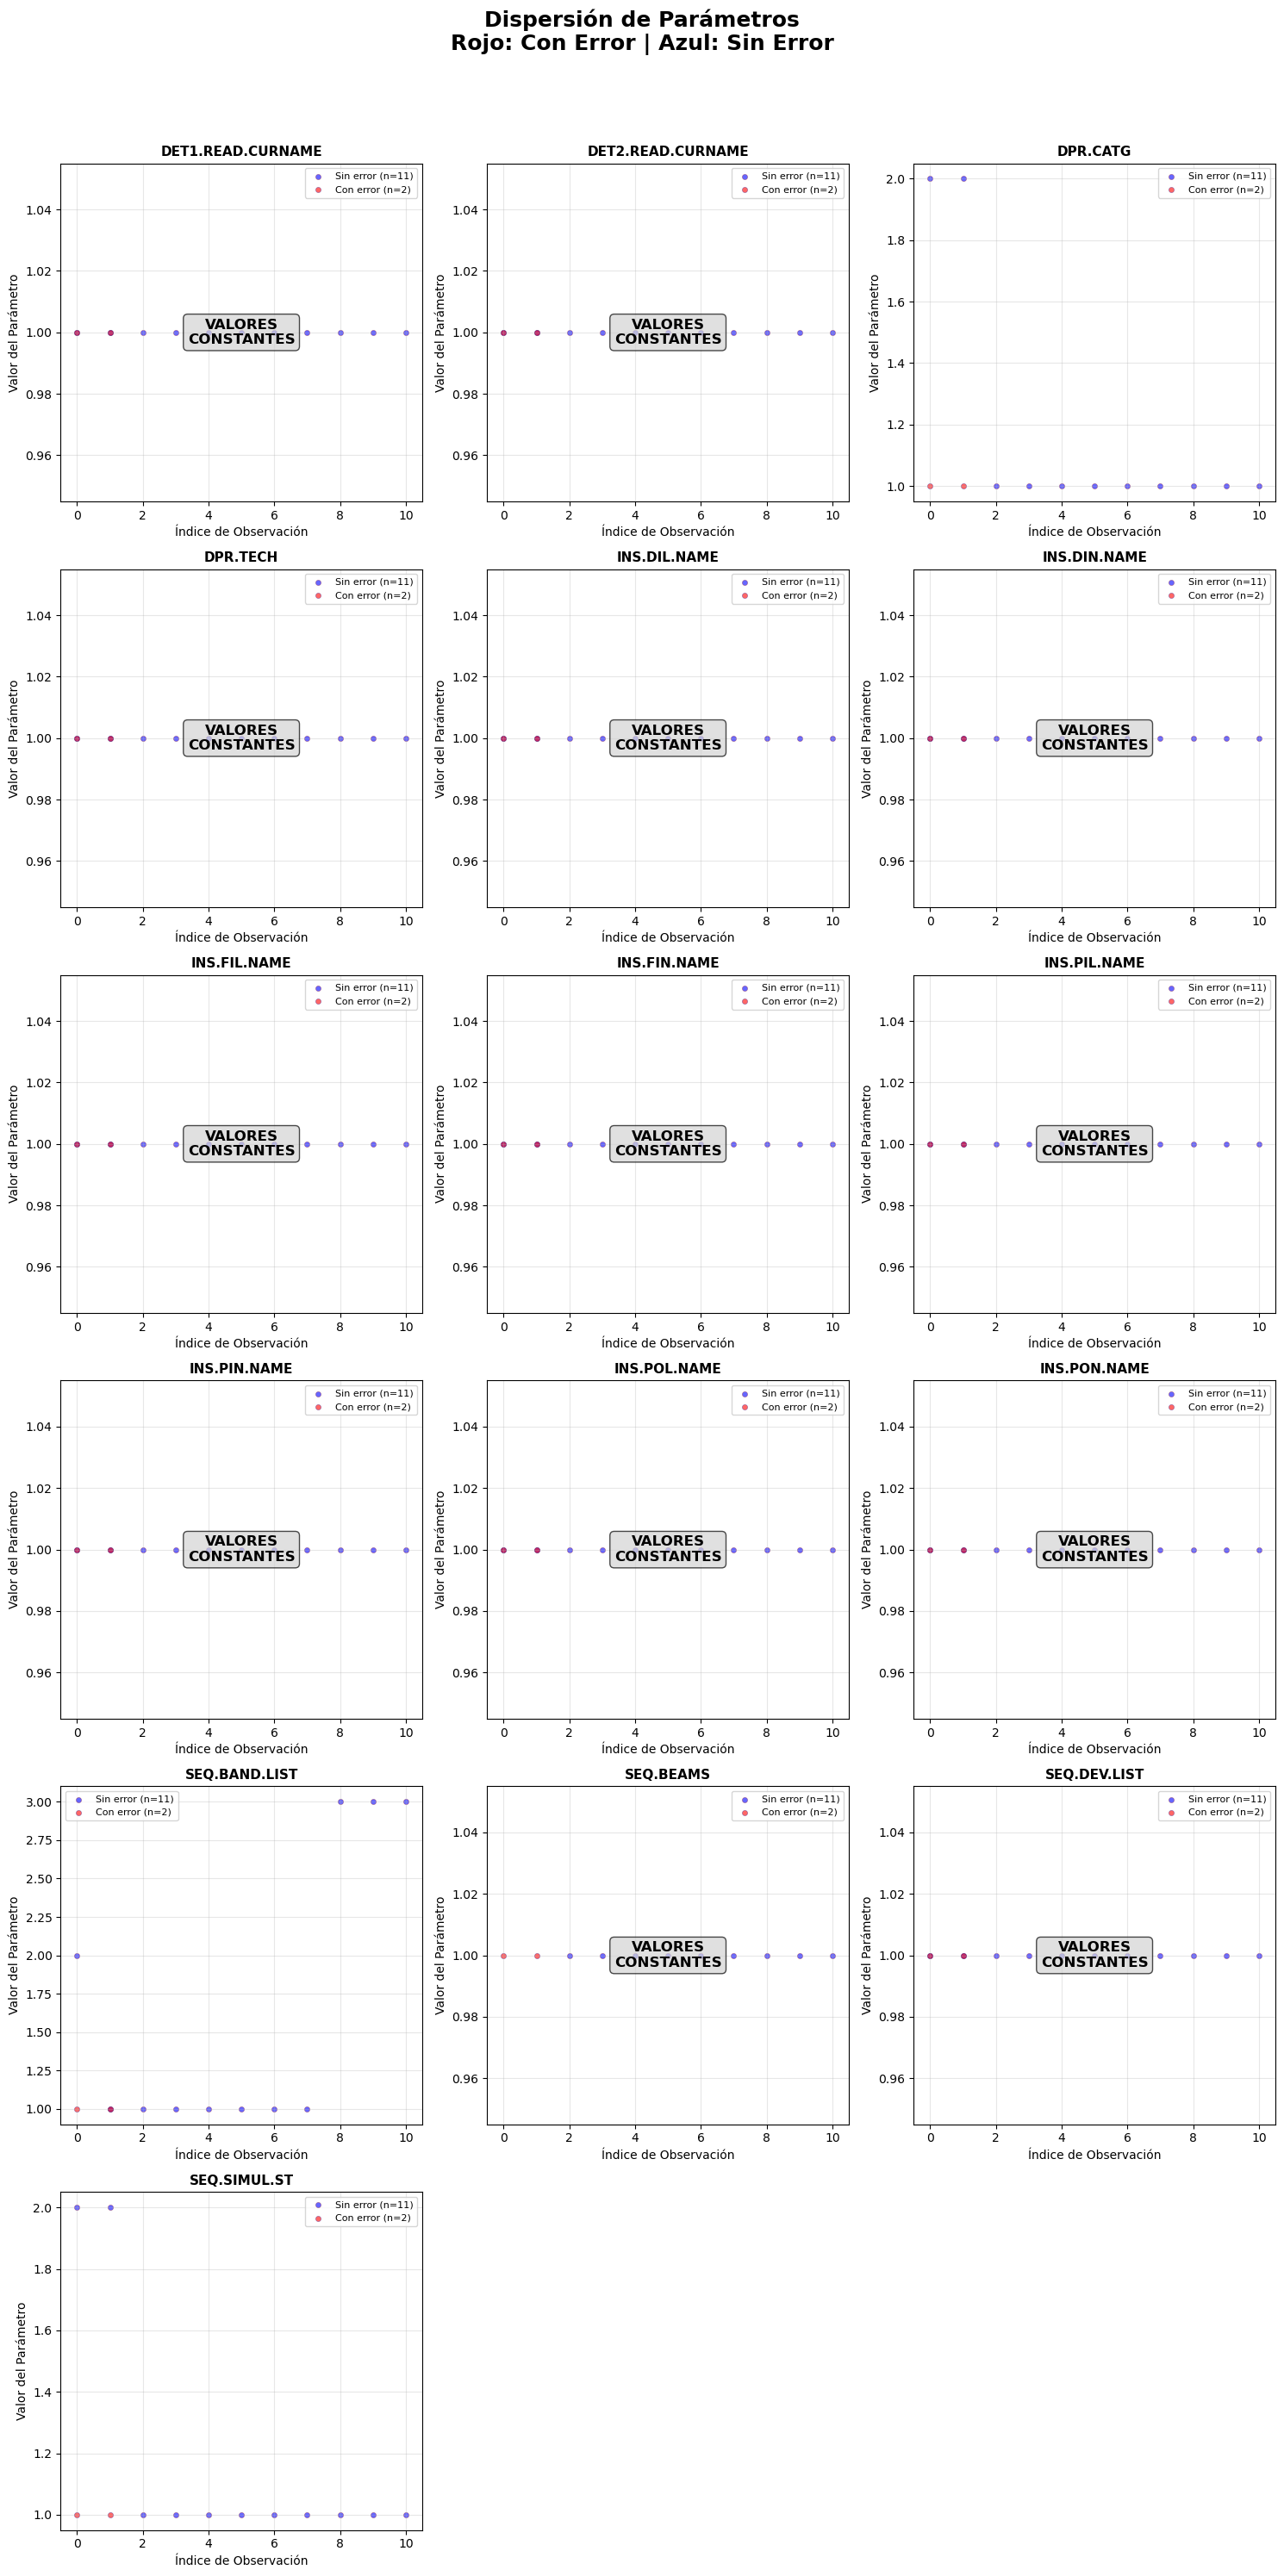


Graficando: params_strval_MATISSE_hyb_obs.csv
Creando gráficos para 24 parámetros...
Observaciones sin error: 1557
Observaciones con error: 42


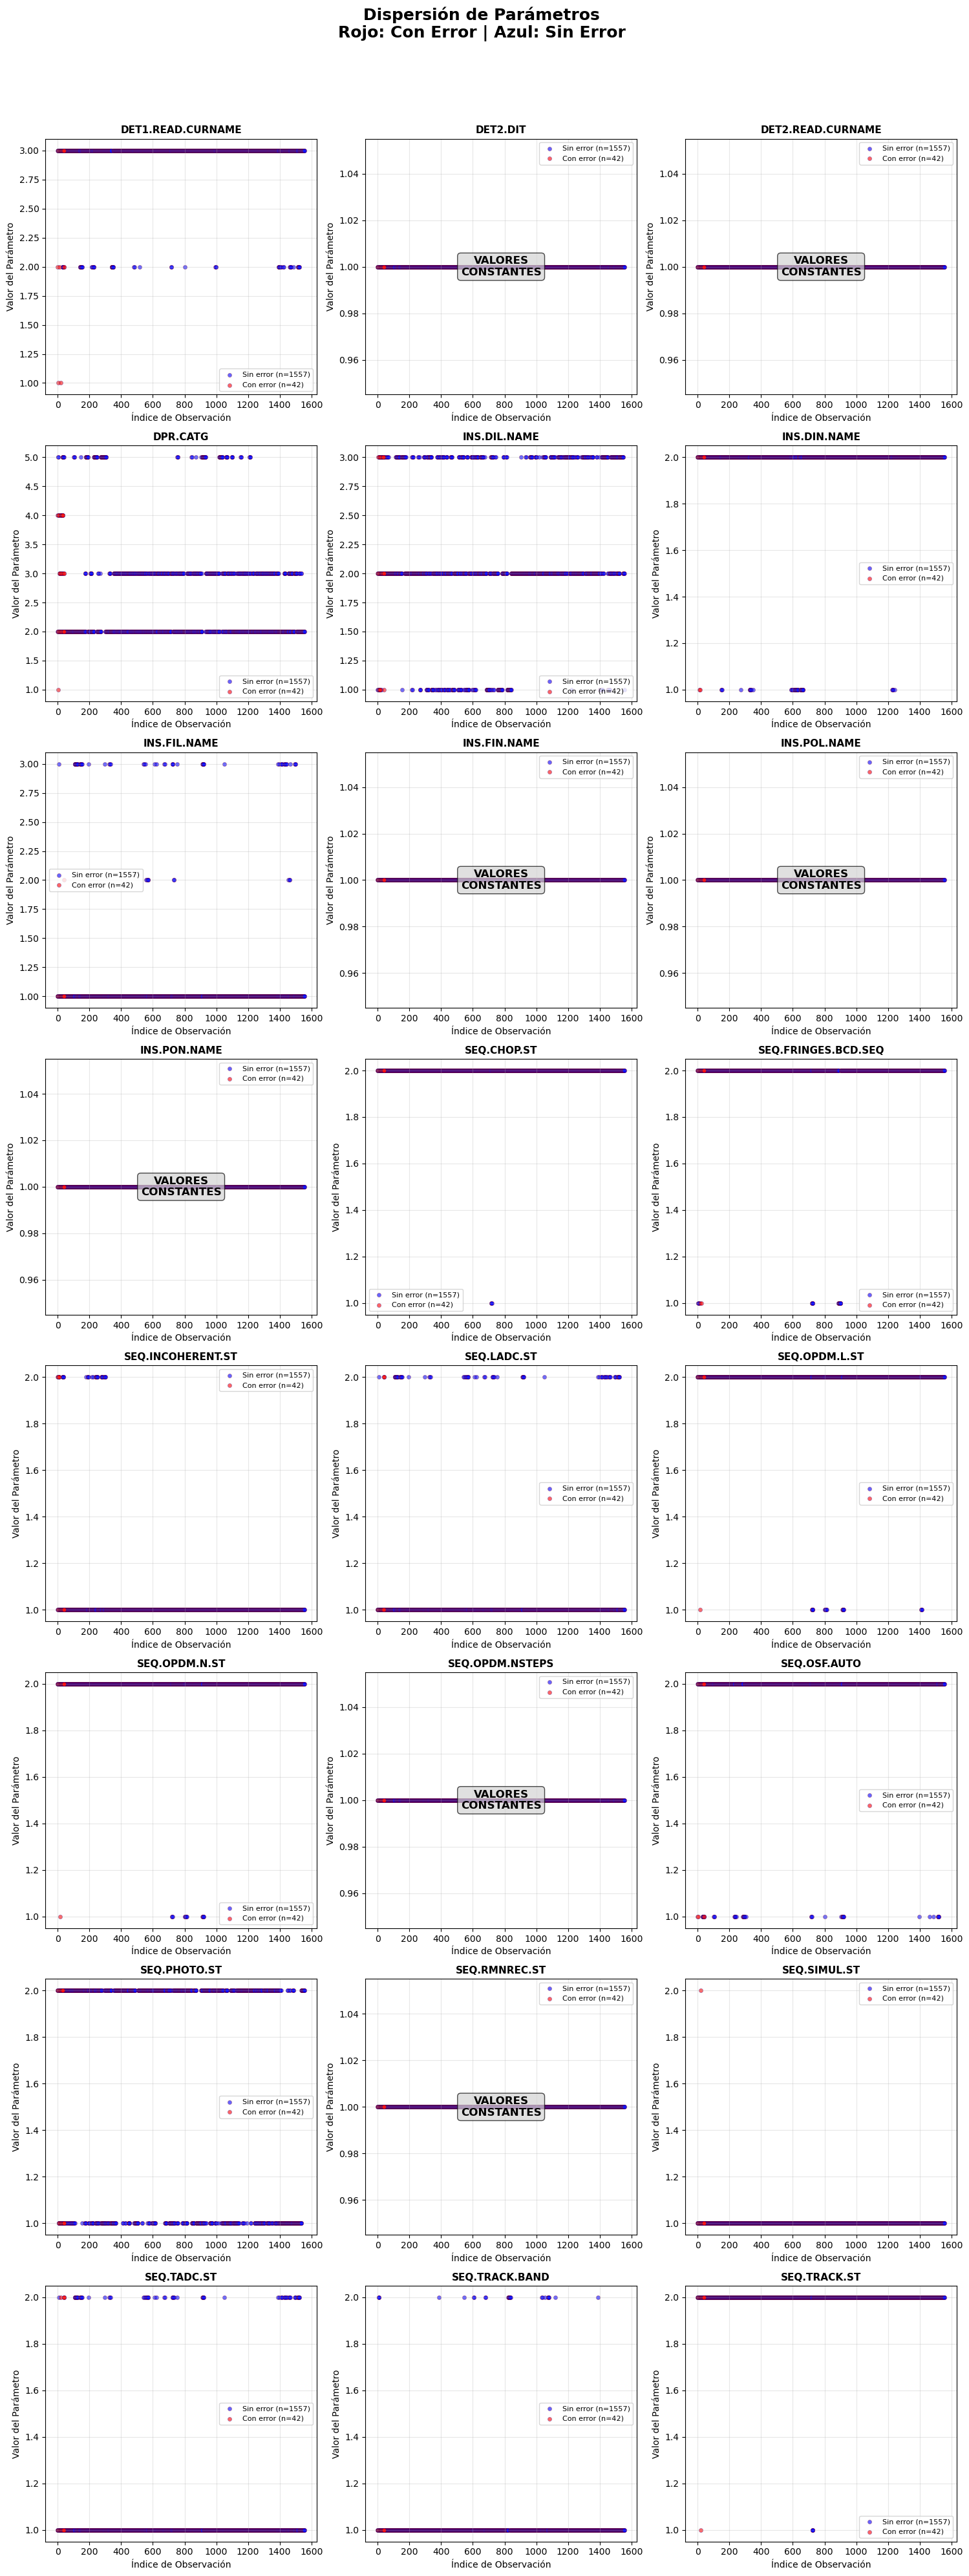


Graficando: params_strval_MATISSE_img_acq.csv
Creando gráficos para 30 parámetros...
Observaciones sin error: 1425
Observaciones con error: 38


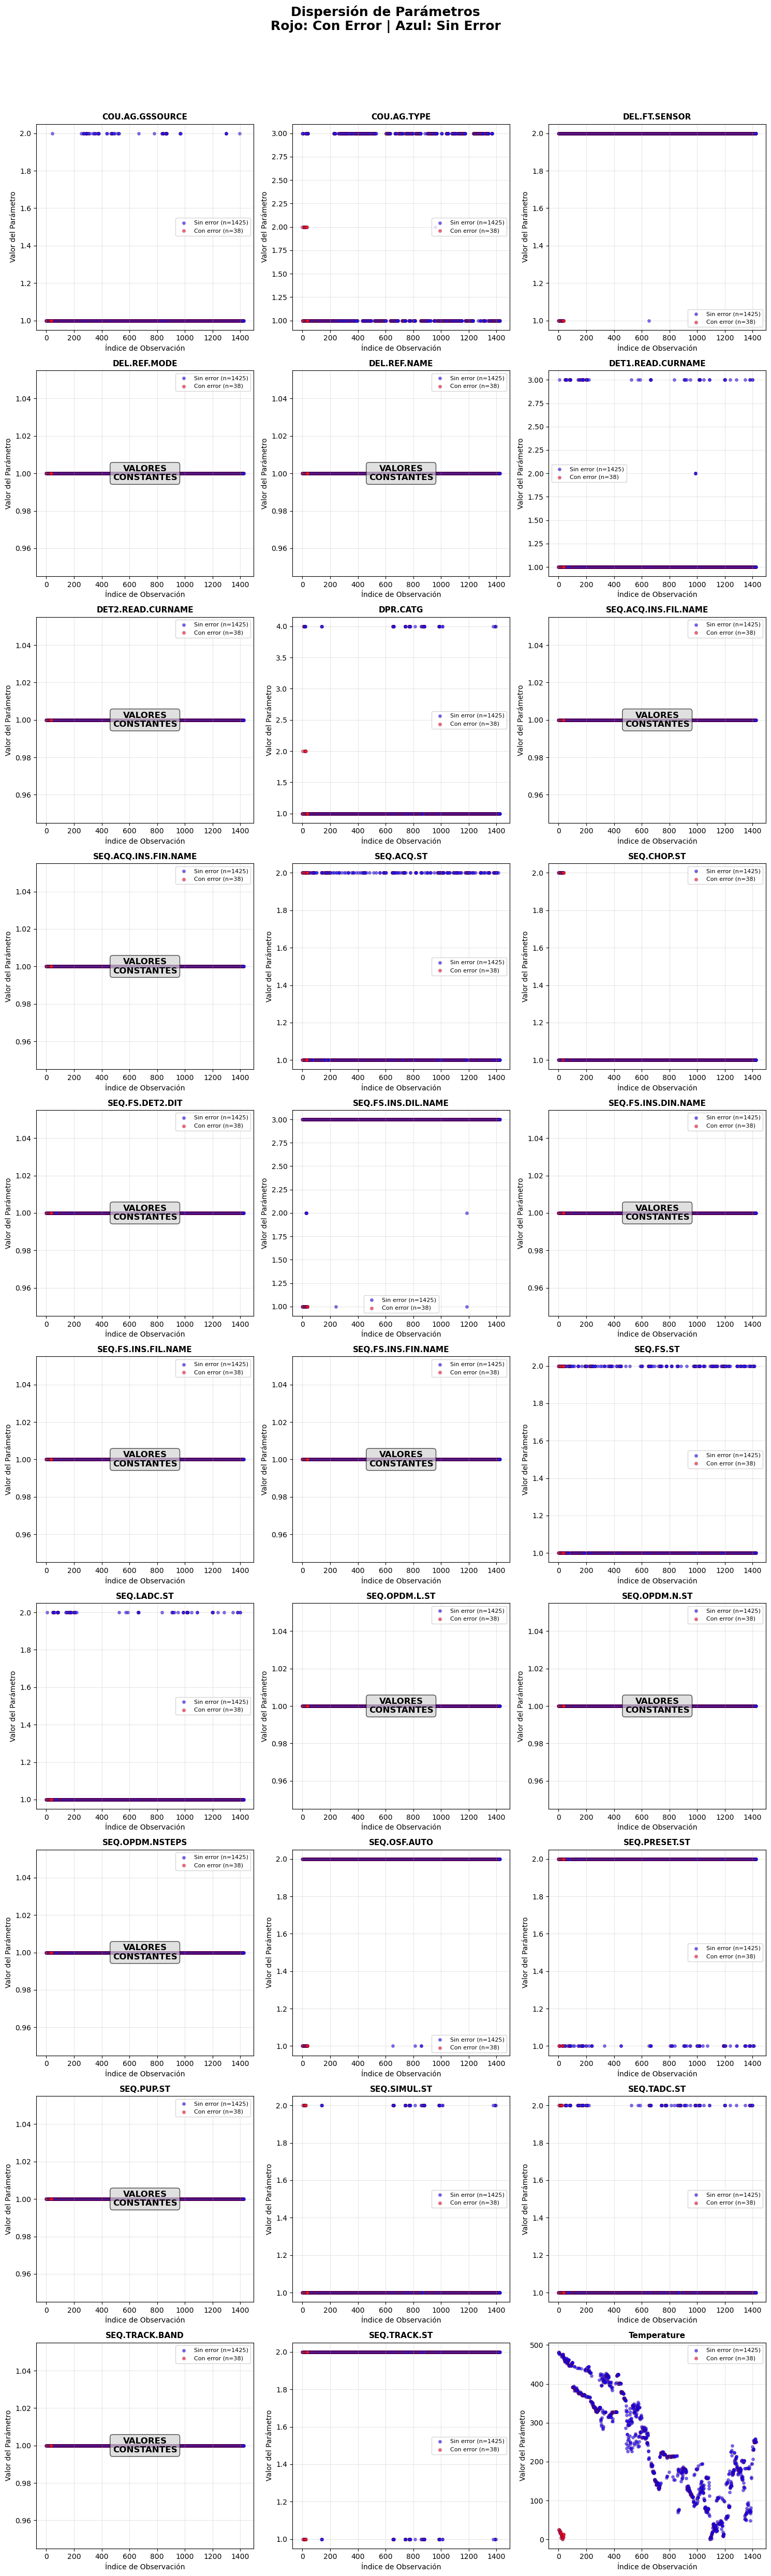


Graficando: params_strval_MATISSE_img_acq_ft.csv
Creando gráficos para 25 parámetros...
Observaciones sin error: 149
Observaciones con error: 21


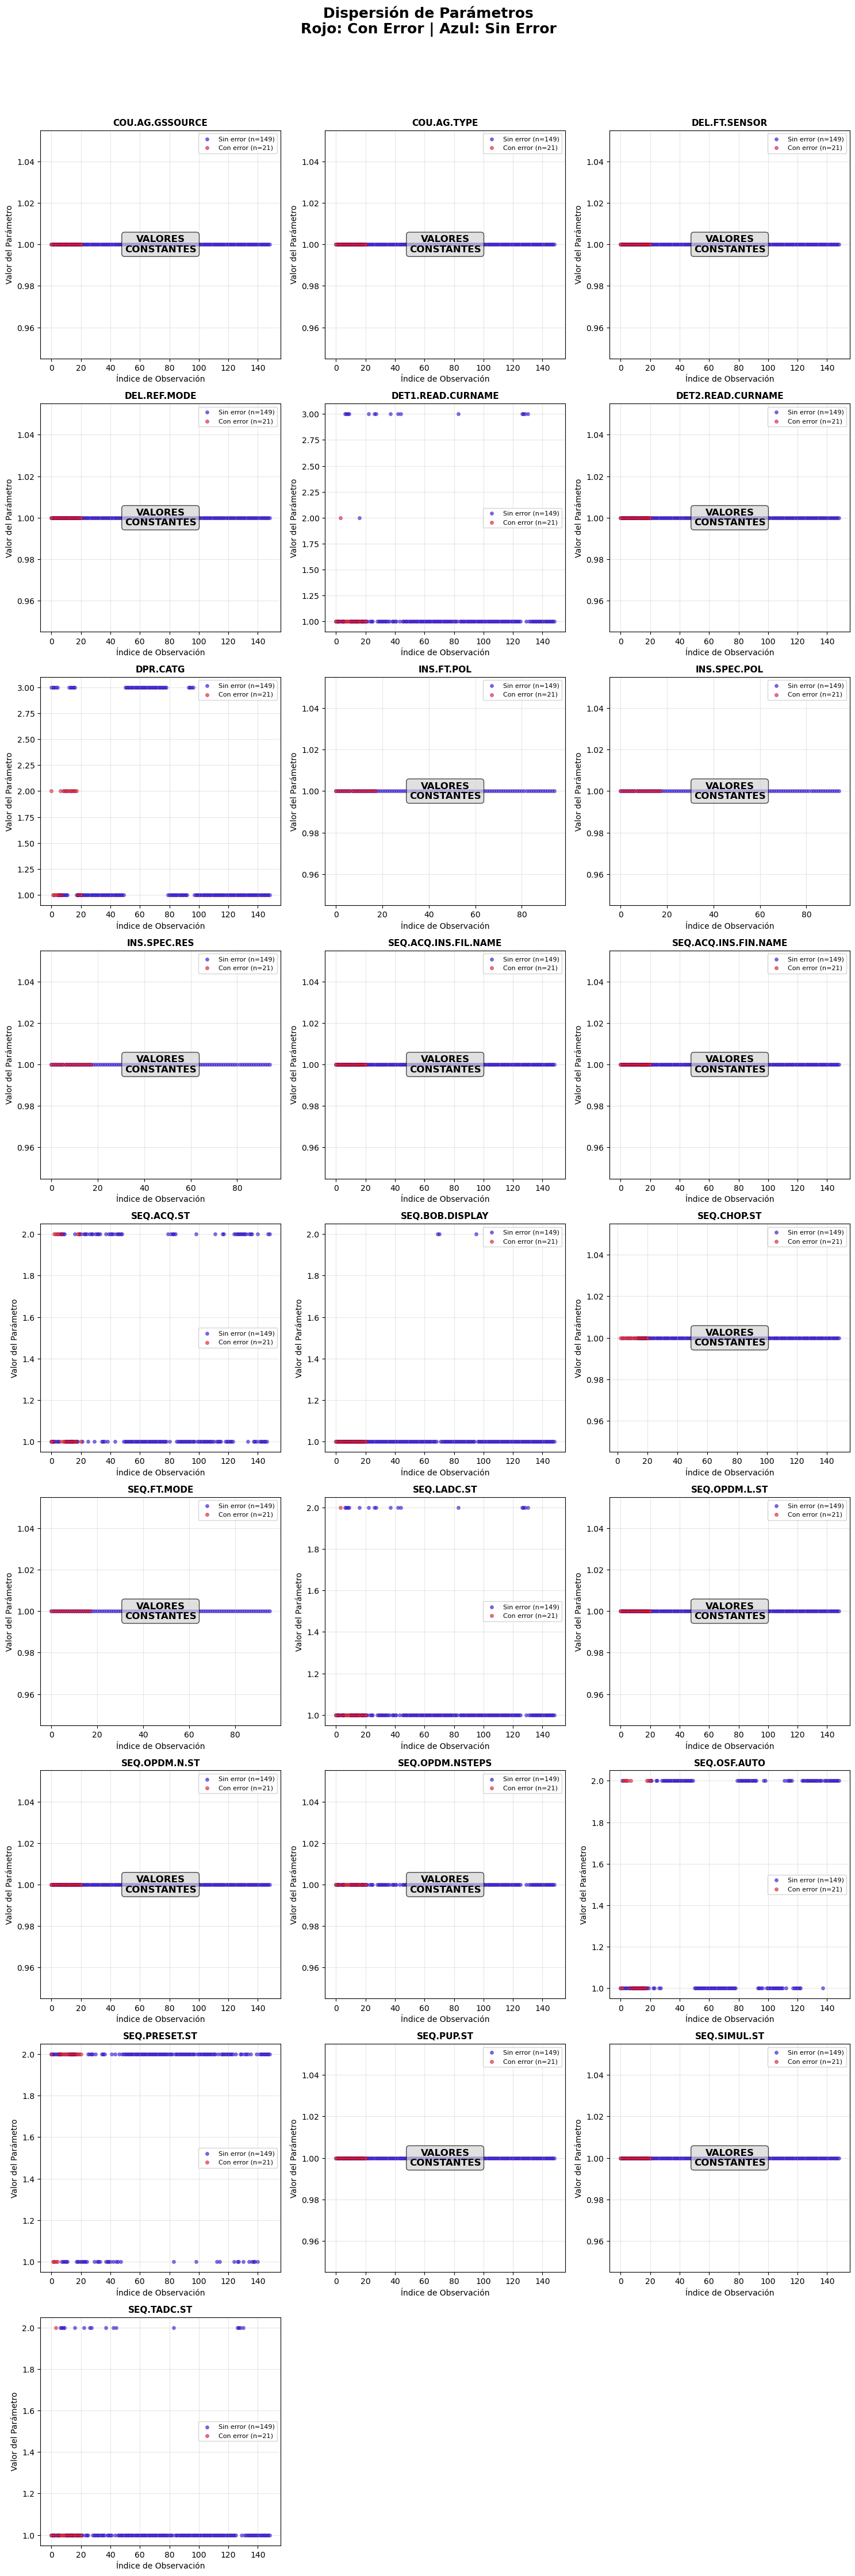


Graficando: params_strval_errseverity.csv
Creando gráficos para 10 parámetros...
Observaciones sin error: 4
Observaciones con error: 26


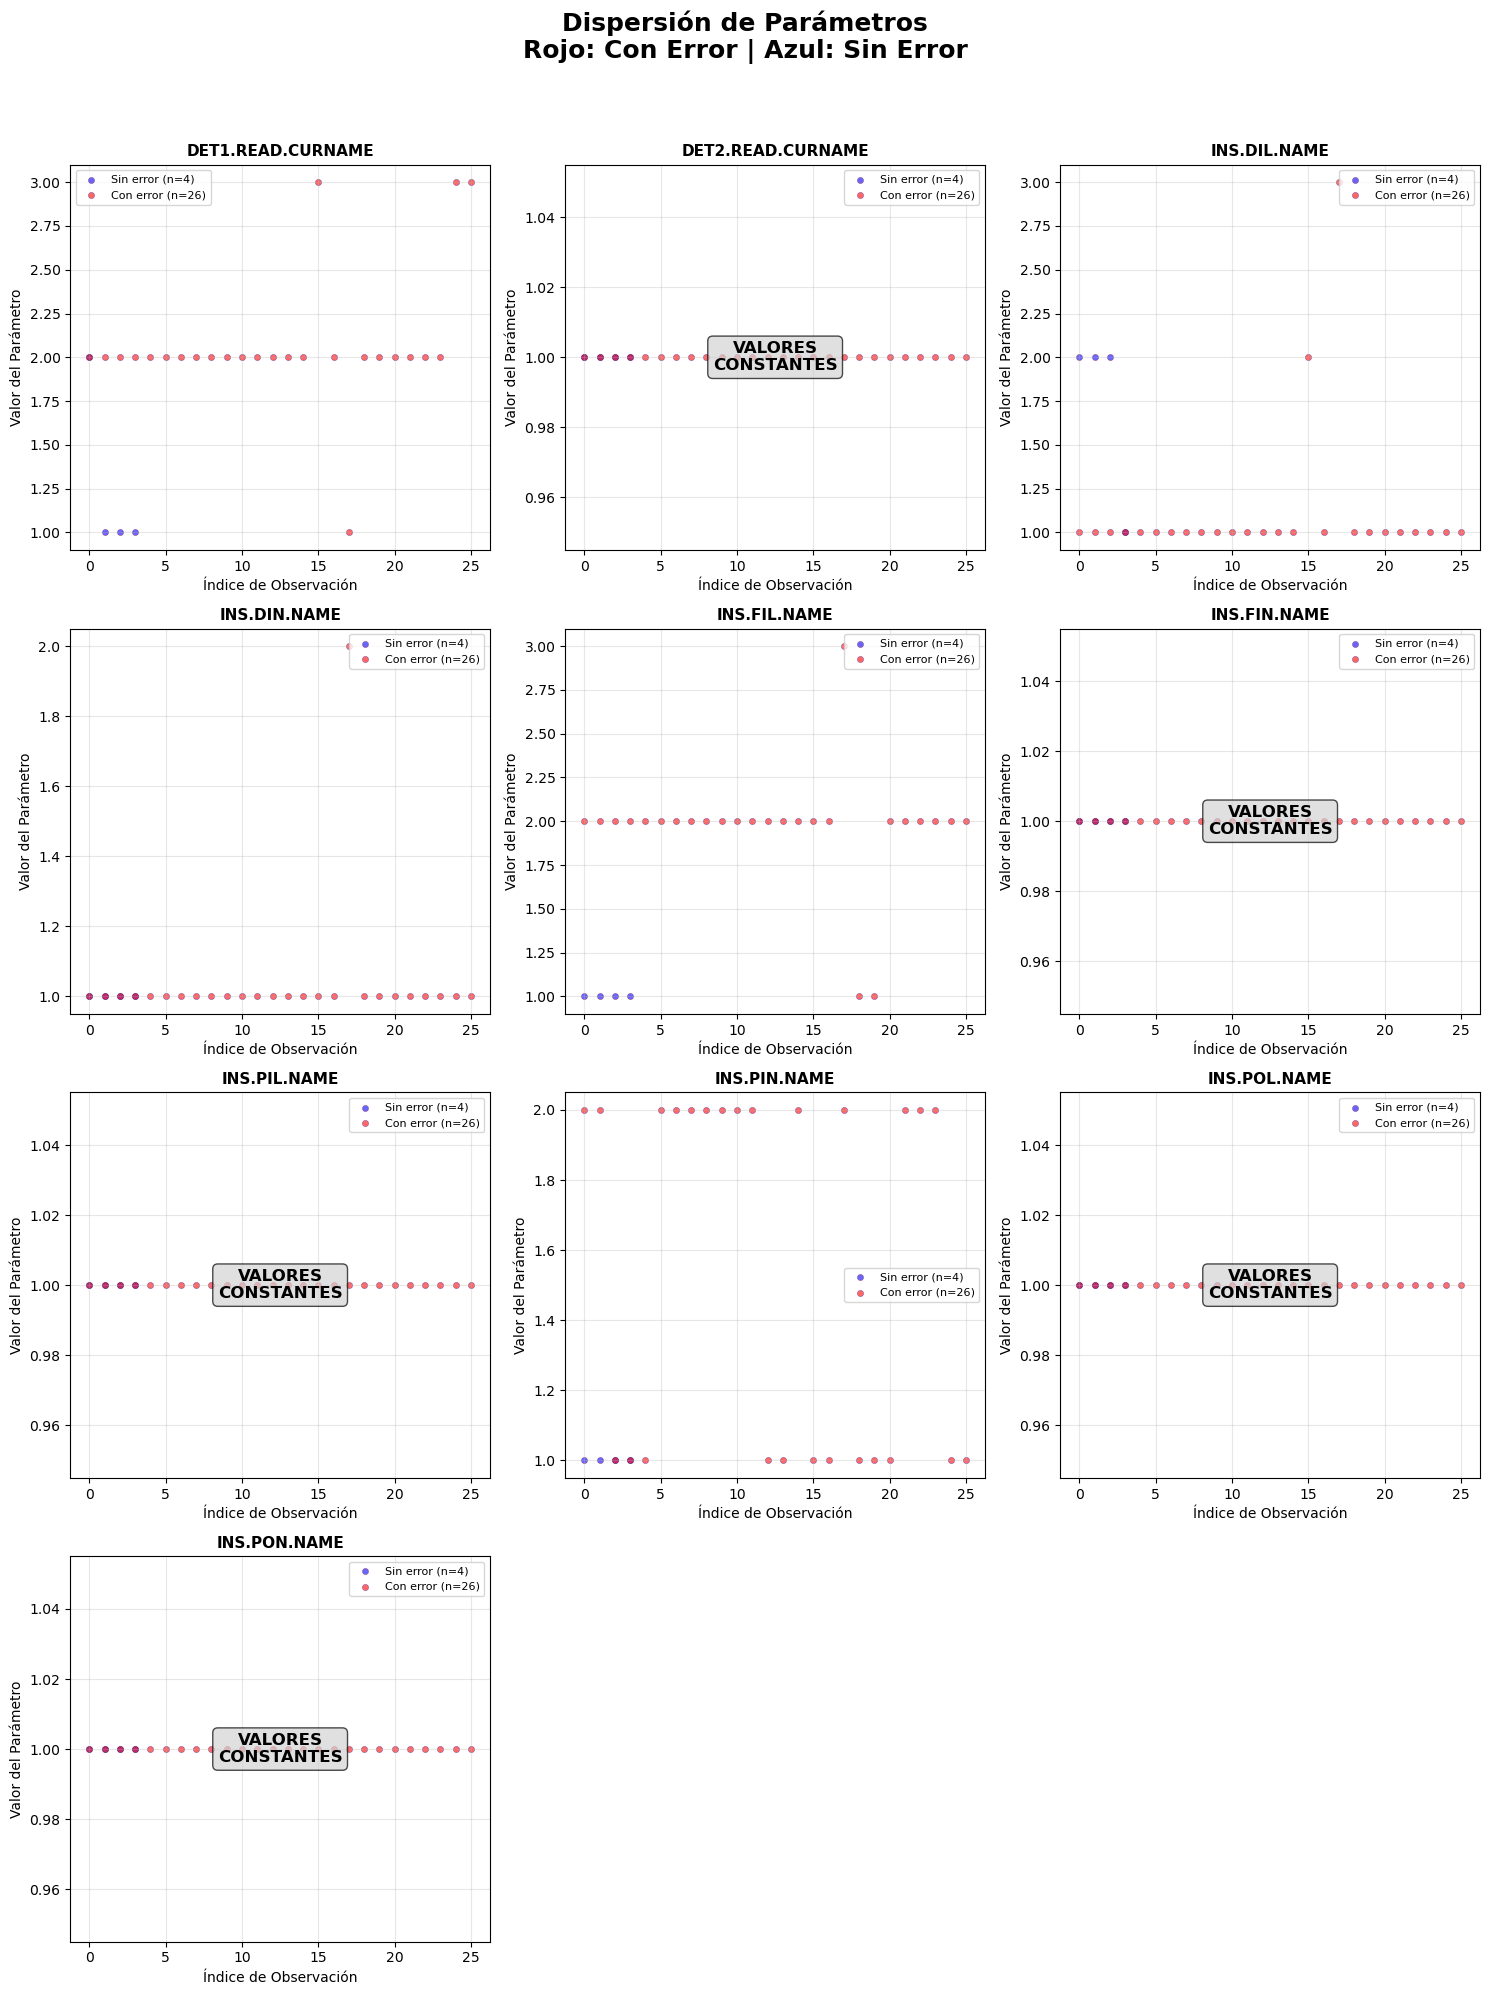

In [ ]:
import os
dir_sin_error = "params_tpl_strval_codificados"
dir_con_error = "params_por_tpl_Error_strval_codificados"

archivos_comunes = set(os.listdir(dir_sin_error)) & set(os.listdir(dir_con_error))

for archivo in sorted(archivos_comunes):
    path_sin = os.path.join(dir_sin_error, archivo)
    path_con = os.path.join(dir_con_error, archivo)

    print(f"\nGraficando: {archivo}")
    df_sin_error = pd.read_csv(path_sin, index_col=0)
    df_con_error = pd.read_csv(path_con, index_col=0)
    
    threshold = 0.5
    df_con_error = df_con_error.loc[:, df_con_error.isna().mean() < threshold]
    df_con_error = df_con_error.loc[df_con_error.isna().mean(axis=1) < threshold, :]
    df_sin_error = df_sin_error.loc[:, df_sin_error.isna().mean() < threshold]
    df_sin_error = df_sin_error.loc[df_sin_error.isna().mean(axis=1) < threshold, :]

    if not df_sin_error.empty and not df_con_error.empty:
        graficos_dispersion(df_sin_error, df_con_error)
    else:
        print(" DataFrame vacío. Se omite.")



Comparando params_strval_MATISSE_gen_cal_bias.csv
Creando gráficos para 8 parámetros NO constantes...
Parámetros constantes (omitidos): ['INS.SFL.NAME', 'SEQ.DET.TRIG.ST', 'INS.SFN.NAME']
Observaciones sin error: 715
Observaciones con error: 9


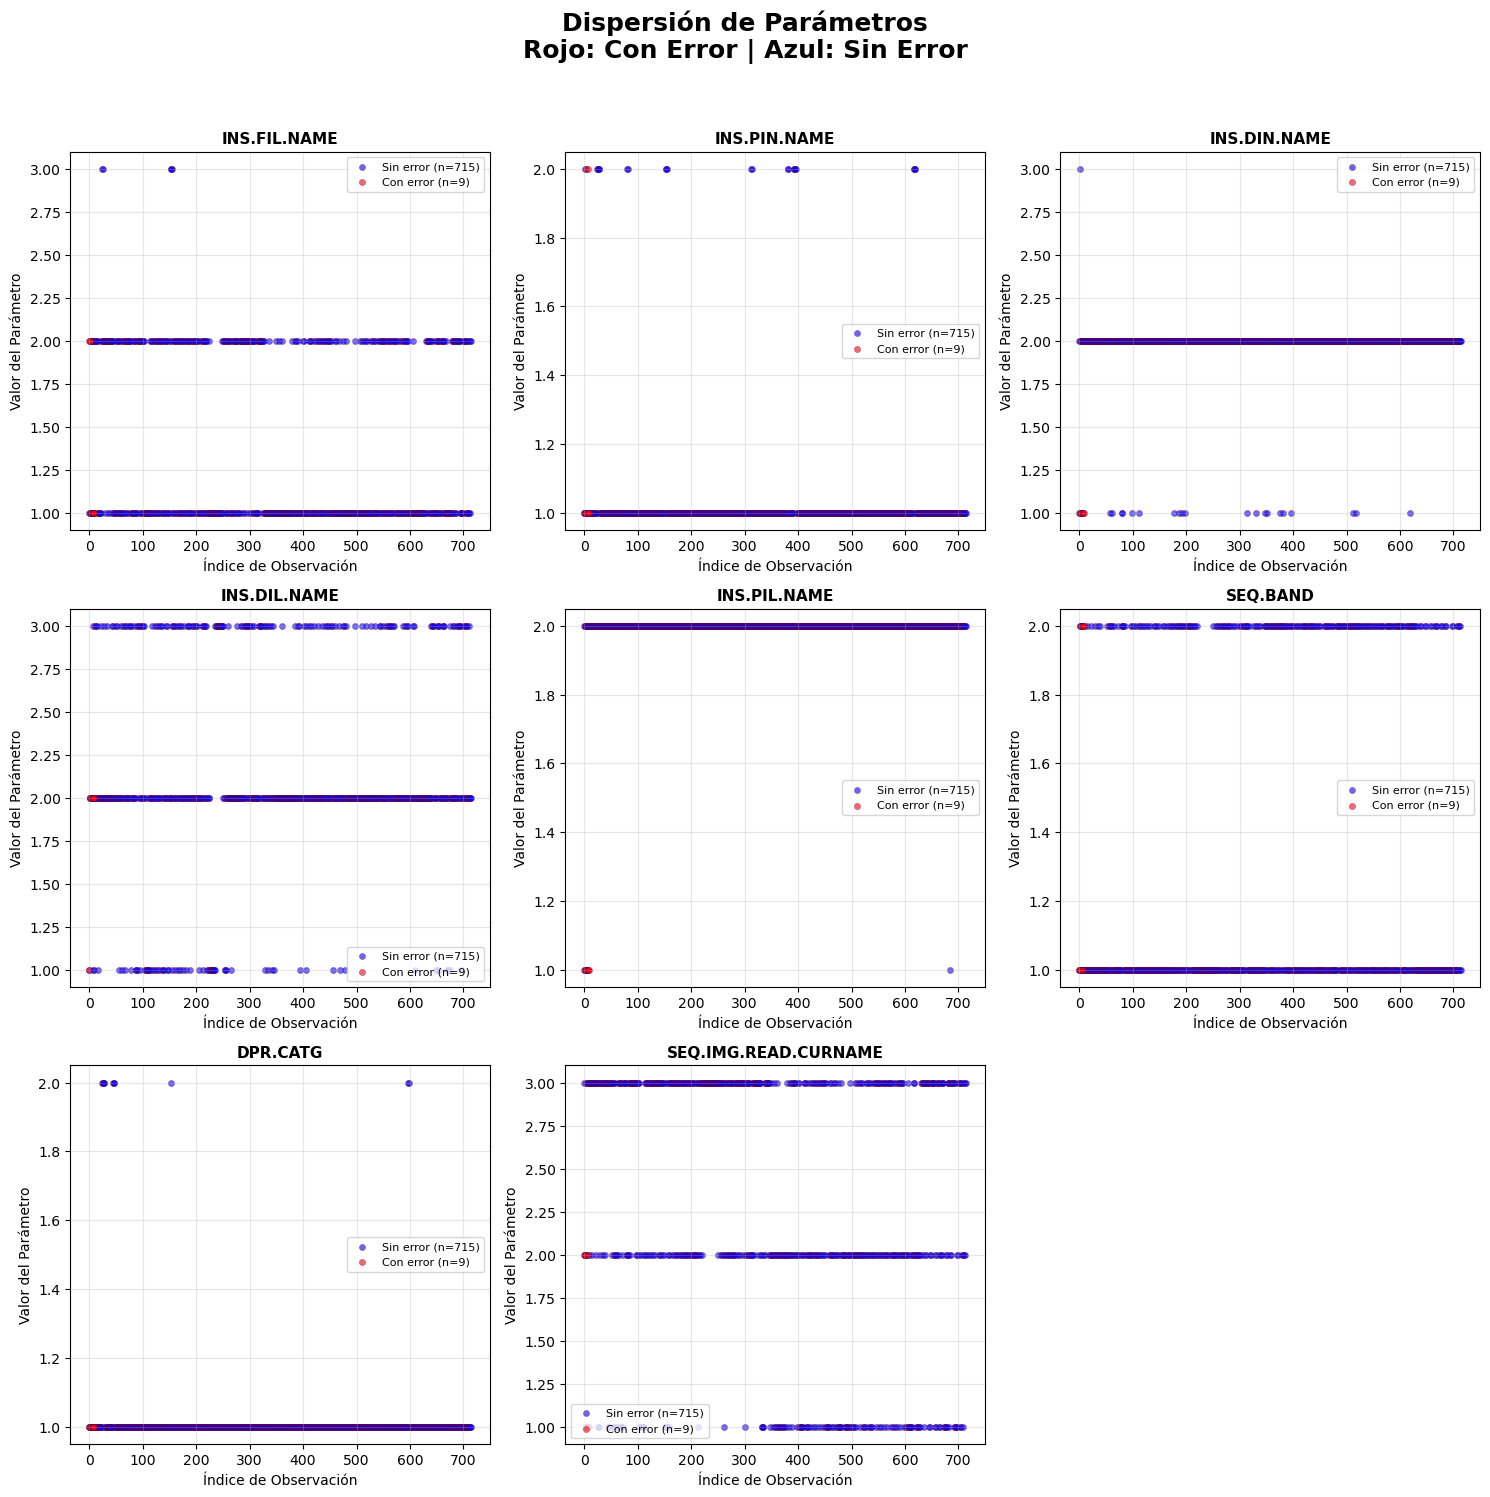


Comparando params_strval_MATISSE_gen_cal_det_aq.csv
Creando gráficos para 5 parámetros NO constantes...
Parámetros constantes (omitidos): ['SEQ.DARK.INS.PIN.NAME', 'SEQ.FLAT.INS.FIN.NAME', 'SEQ.FLAT.INS.PON.NAME', 'SEQ.DARK.INS.PON.NAME', 'DPR.TECH', 'SEQ.FLAT.INS.PIN.NAME', 'SEQ.DARK.INS.FIN.NAME']
Observaciones sin error: 7
Observaciones con error: 15


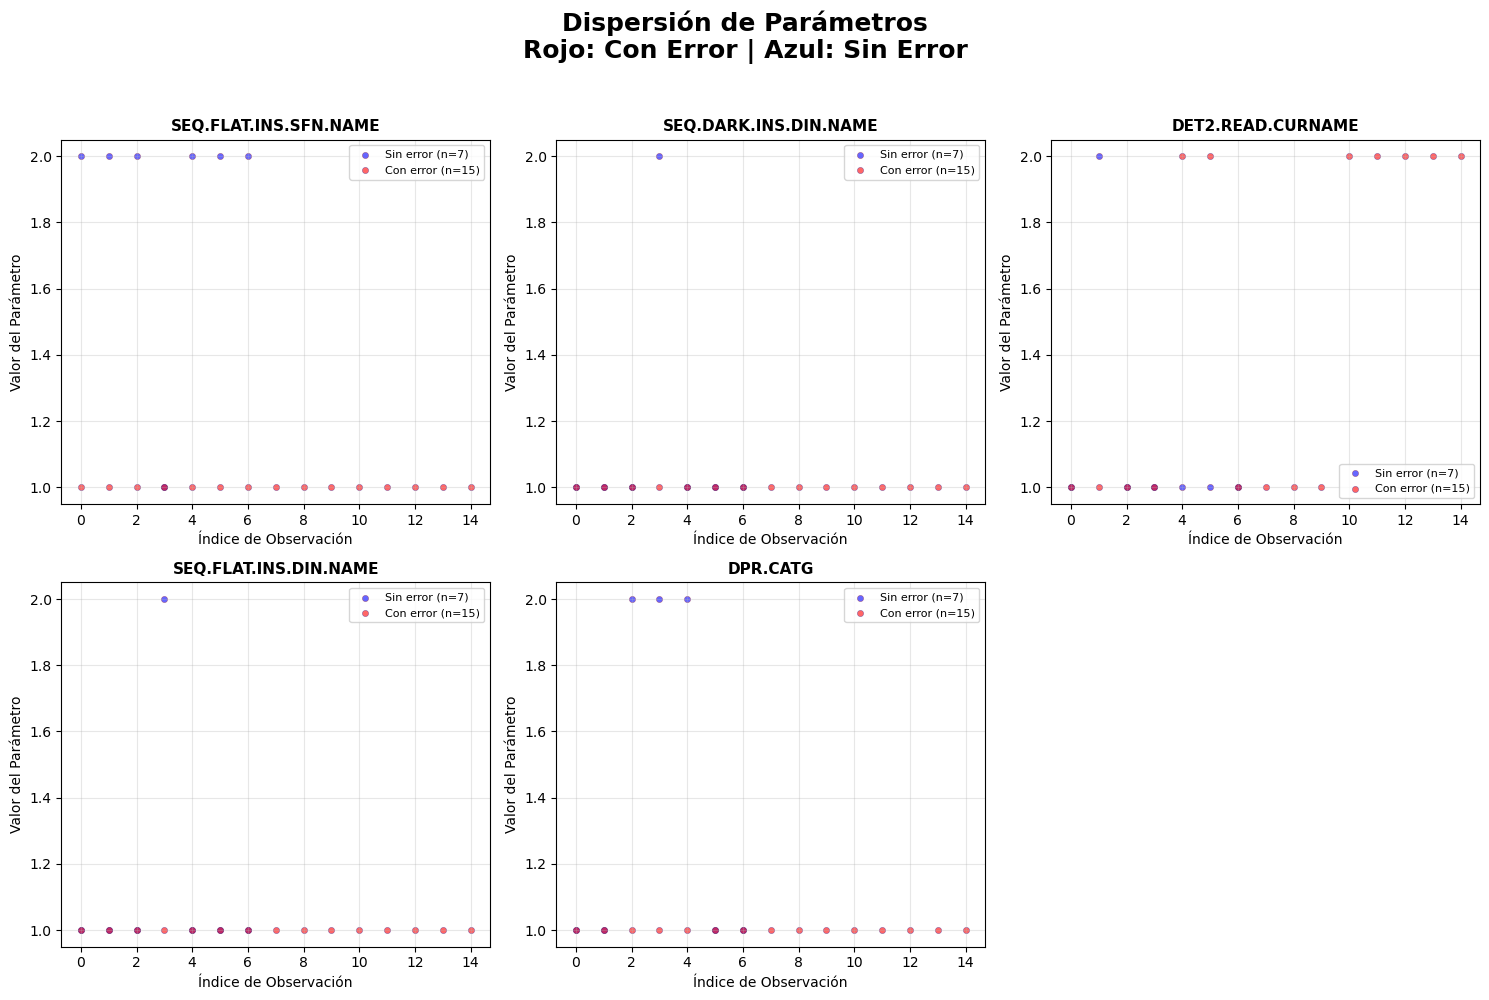


Comparando params_strval_MATISSE_gen_cal_det_h2.csv
Creando gráficos para 4 parámetros NO constantes...
Parámetros constantes (omitidos): ['SEQ.DARK.INS.POL.NAME', 'SEQ.FLAT.INS.SFL.NAME', 'SEQ.DARK.INS.PIL.NAME', 'DPR.TECH', 'SEQ.FLAT.INS.POL.NAME', 'SEQ.DARK.INS.DIL.NAME', 'SEQ.FLAT.INS.PIL.NAME', 'SEQ.DARK.INS.FIL.NAME']
Observaciones sin error: 18
Observaciones con error: 3


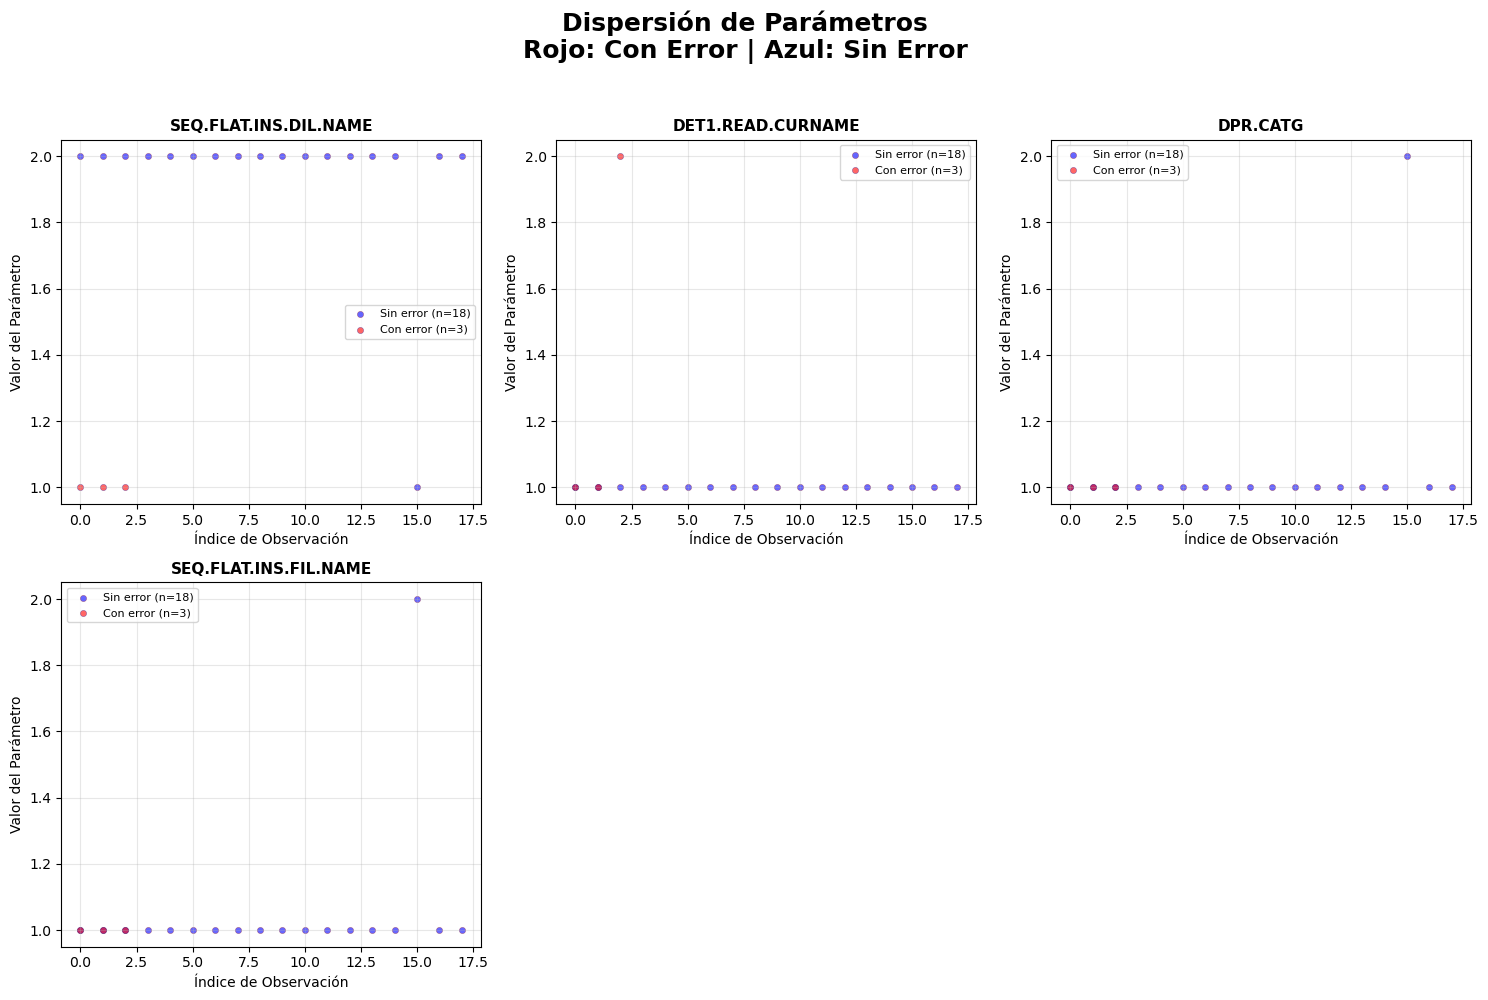


Comparando params_strval_MATISSE_gen_cal_imbasic.csv
Creando gráficos para 1 parámetros NO constantes...
Parámetros constantes (omitidos): ['INS.FIL.NAME', 'INS.DIN.NAME', 'DET1.WIN.MTRH.LIST', 'DET2.READ.CURNAME', 'INS.DIL.NAME', 'INS.FIN.NAME', 'INS.PIL.NAME', 'INS.PON.NAME', 'DET2.WIN.MTRH.LIST', 'DPR.TYPE', 'DET1.READ.CURNAME', 'DPR.CATG', 'DET2.WIN.MTRS.LIST', 'DET1.WIN.MTRS.LIST', 'INS.POL.NAME', 'INS.PIN.NAME']
Observaciones sin error: 393
Observaciones con error: 6


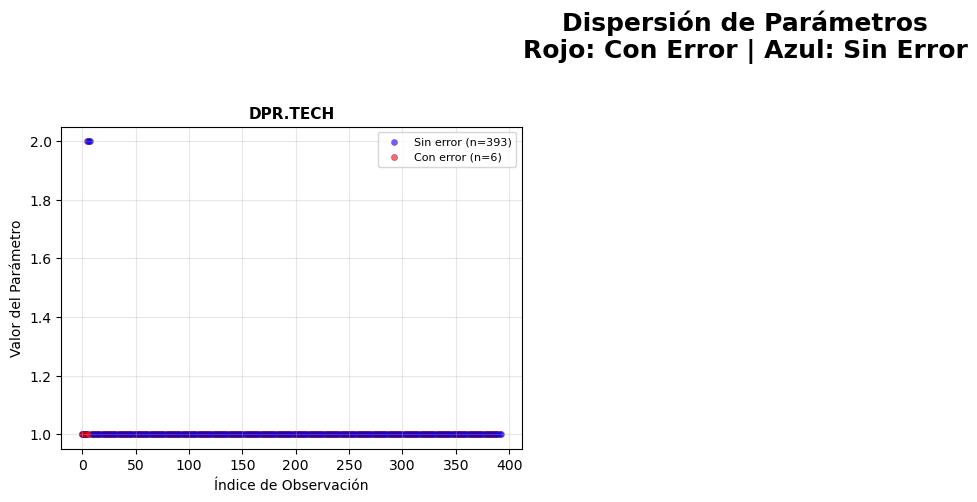


Comparando params_strval_MATISSE_gen_cal_kappa.csv
Creando gráficos para 3 parámetros NO constantes...
Parámetros constantes (omitidos): ['INS.DIN.NAME', 'DET2.READ.CURNAME', 'INS.FIN.NAME', 'INS.PON.NAME', 'INS.SFL.NAME', 'DPR.TECH', 'SEQ.BAND', 'DPR.CATG', 'SEQ.SIMUL.ST', 'INS.SFN.NAME', 'INS.POL.NAME']
Observaciones sin error: 54
Observaciones con error: 2


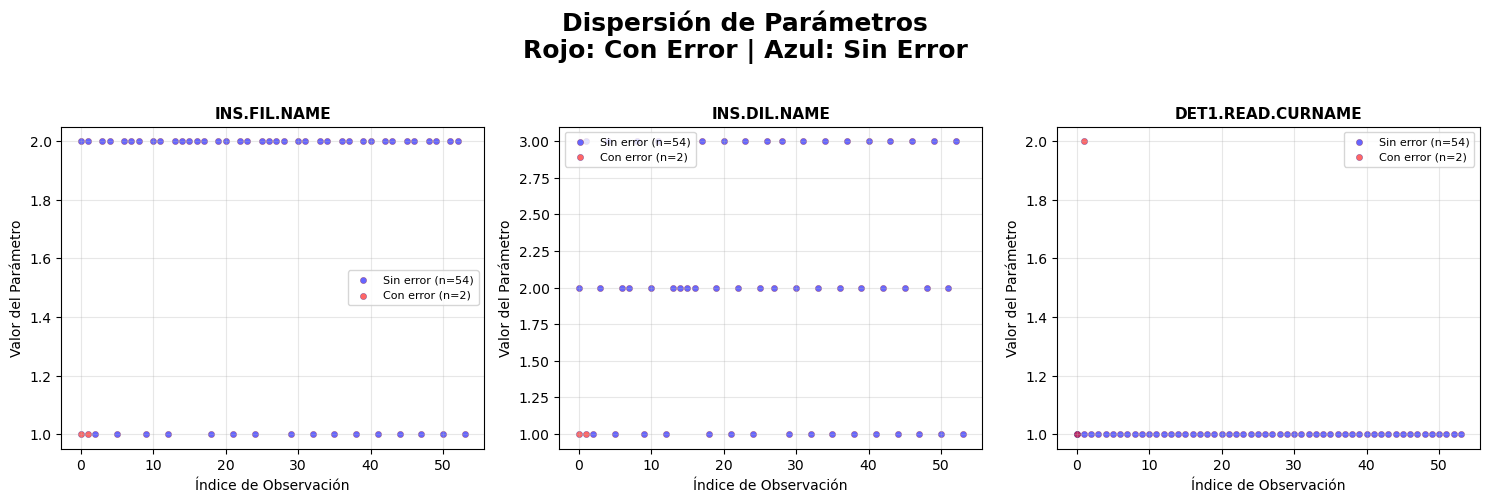


Comparando params_strval_MATISSE_gen_cal_shift.csv
Creando gráficos para 6 parámetros NO constantes...
Parámetros constantes (omitidos): ['INS.PON.NAME', 'DET2.READ.CURNAME', 'SEQ.SIMUL.ST', 'INS.POL.NAME']
Observaciones sin error: 47
Observaciones con error: 3


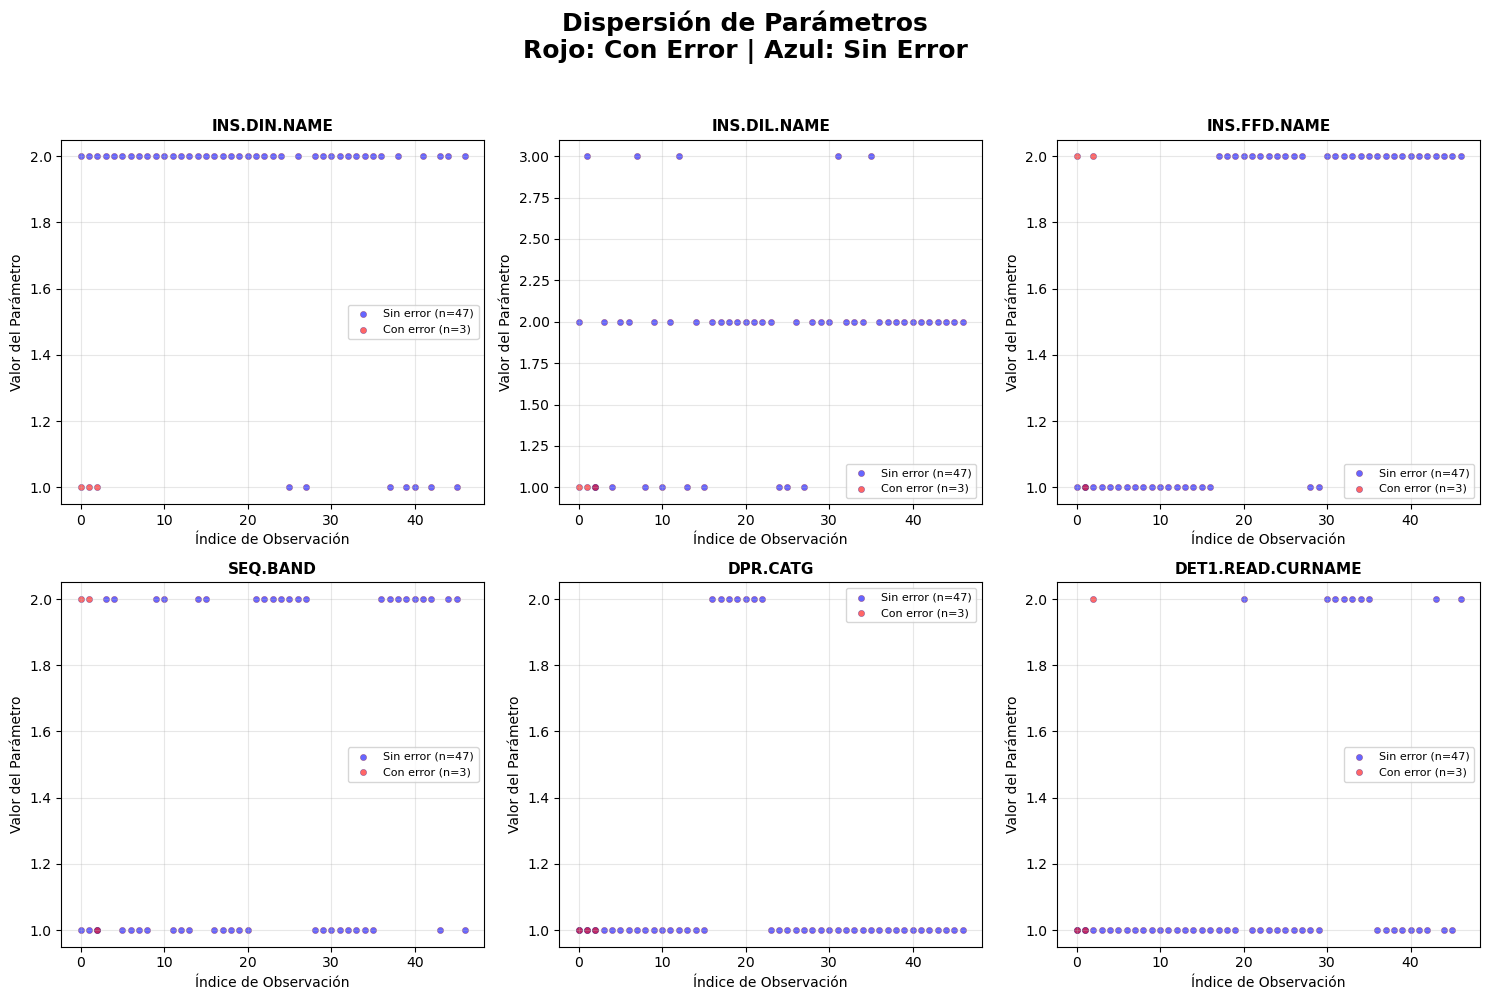


Comparando params_strval_MATISSE_gen_cal_transfunc.csv
Creando gráficos para 21 parámetros NO constantes...
Parámetros constantes (omitidos): []
Observaciones sin error: 240
Observaciones con error: 1


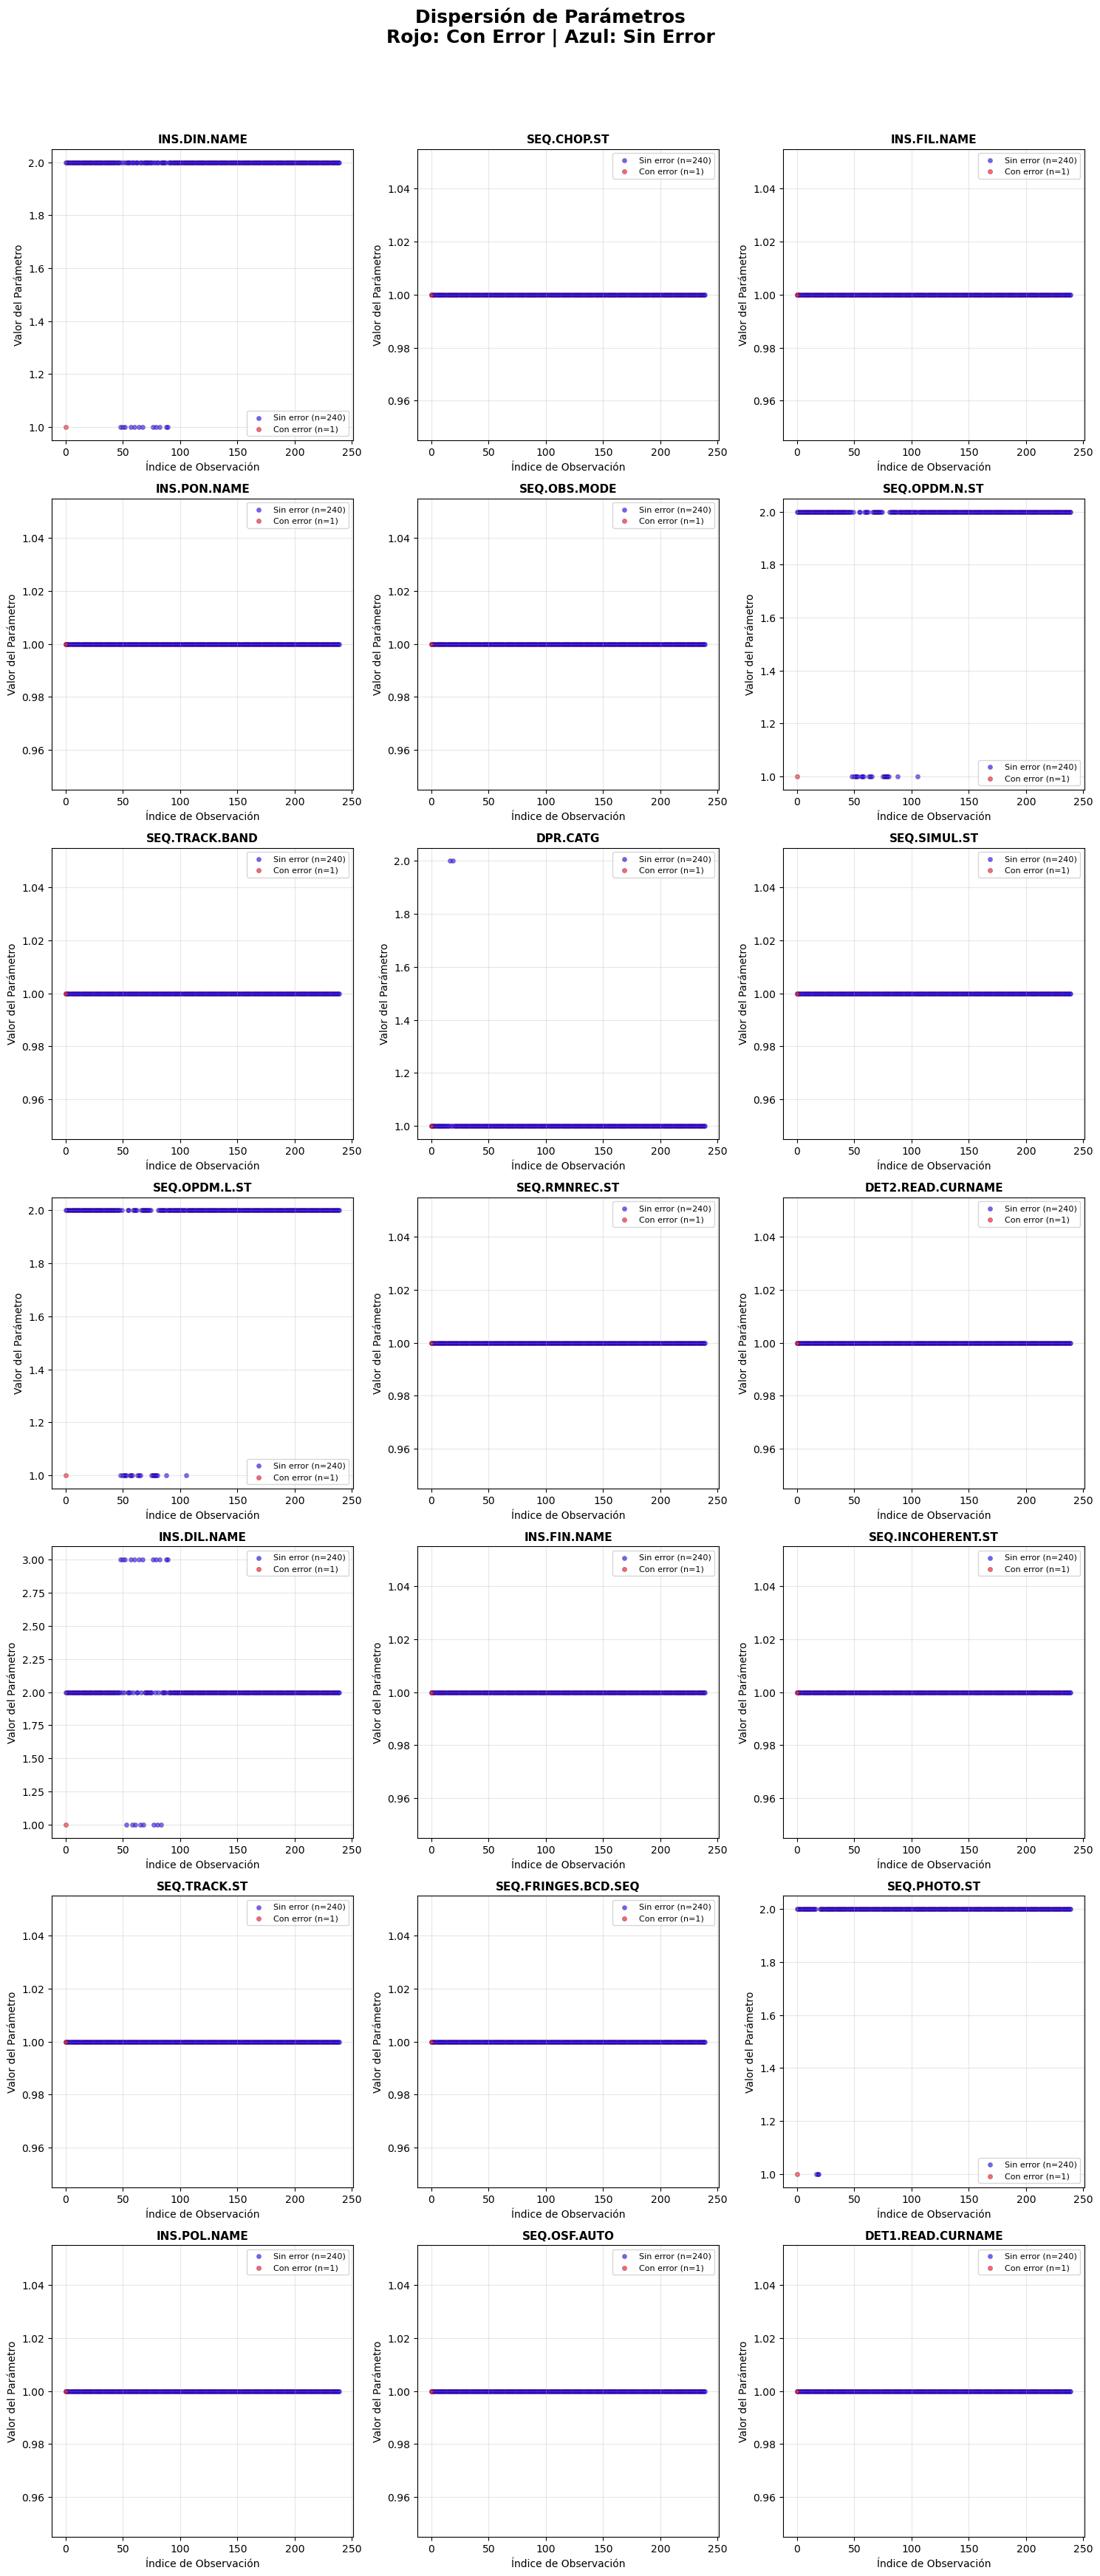


Comparando params_strval_MATISSE_gen_tec_ali.csv
Creando gráficos para 7 parámetros NO constantes...
Parámetros constantes (omitidos): ['DPR.TECH']
Observaciones sin error: 116
Observaciones con error: 67


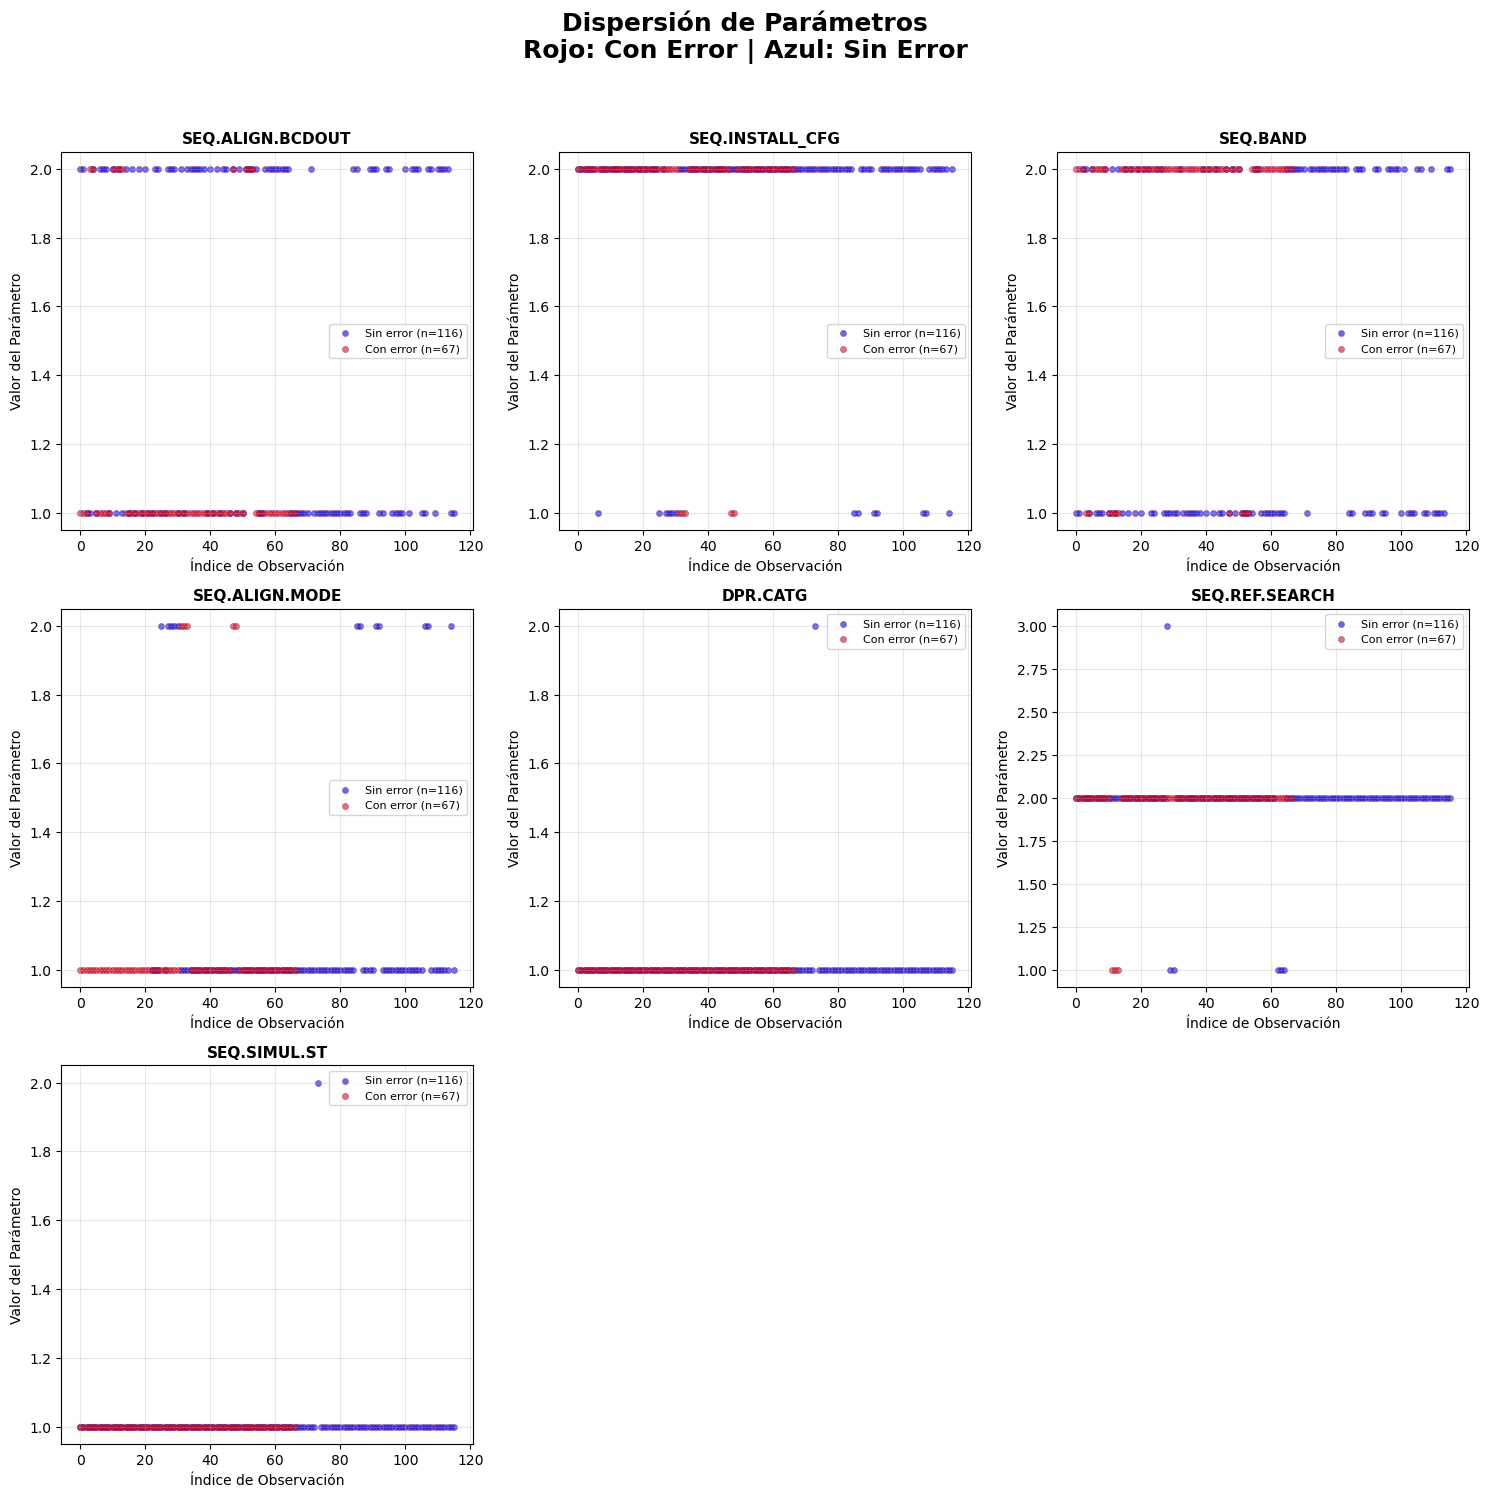


Comparando params_strval_MATISSE_gen_tec_check_fringes.csv
Creando gráficos para 4 parámetros NO constantes...
Parámetros constantes (omitidos): ['INS.DIN.NAME', 'DET2.READ.CURNAME', 'INS.DIL.NAME', 'INS.FIN.NAME', 'INS.PIL.NAME', 'INS.PON.NAME', 'DPR.TECH', 'SEQ.SIMUL.ST', 'INS.POL.NAME', 'INS.PIN.NAME']
Observaciones sin error: 173
Observaciones con error: 10


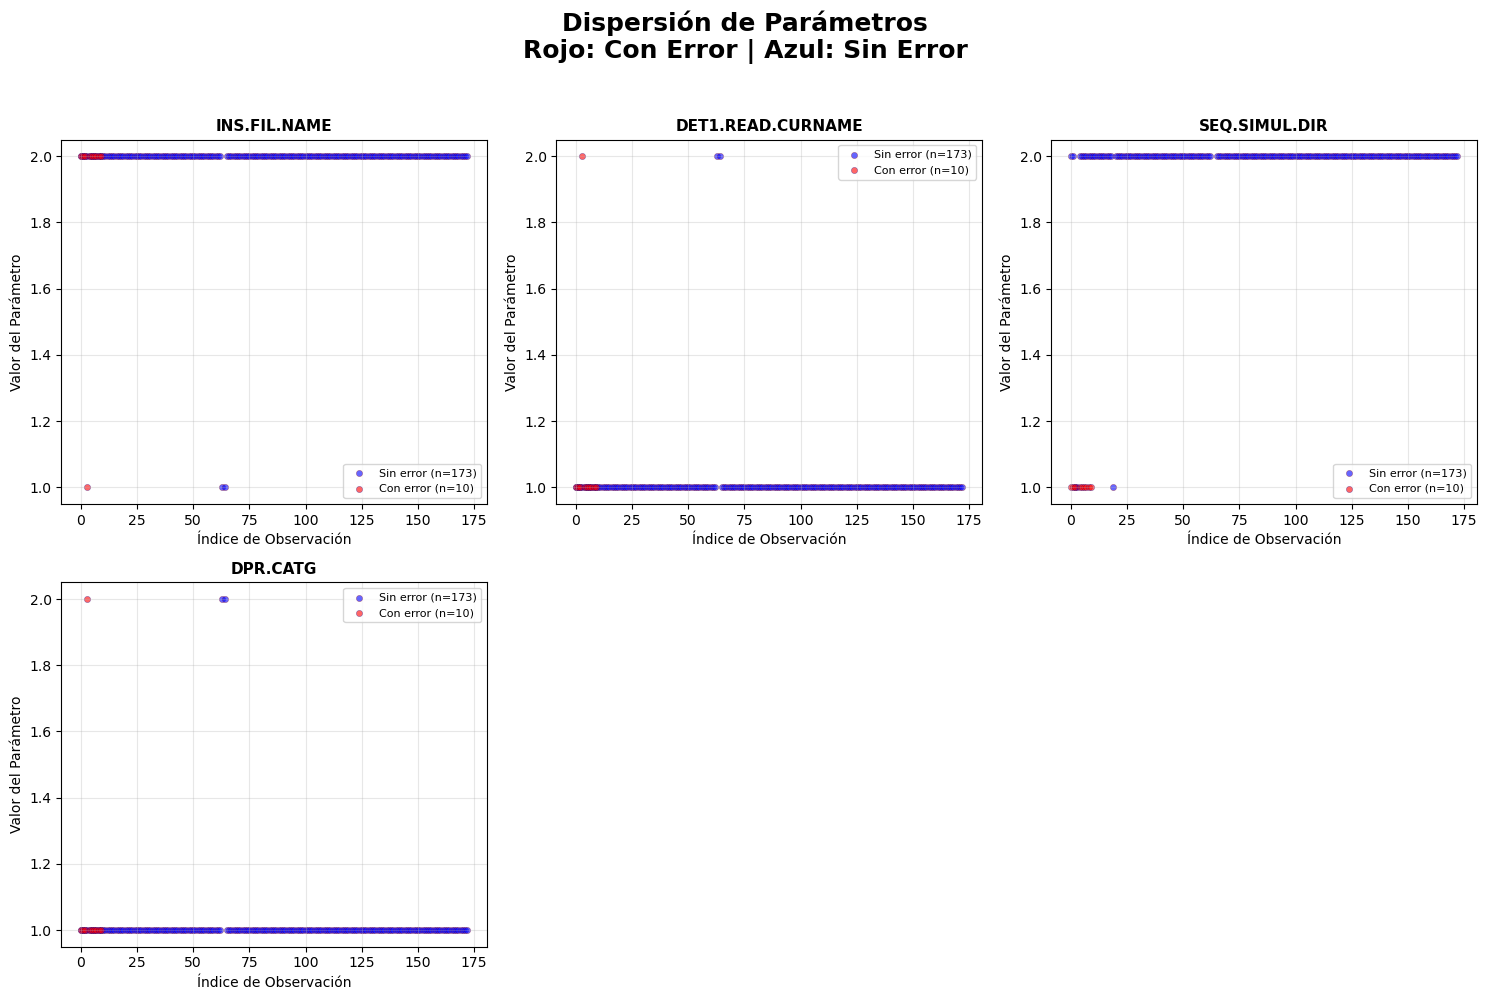


Comparando params_strval_MATISSE_gen_tec_opd.csv
Creando gráficos para 10 parámetros NO constantes...
Parámetros constantes (omitidos): ['INS.FIL.NAME', 'INS.PON.NAME', 'INS.FIN.NAME', 'INS.PIL.NAME', 'DPR.TECH', 'SEQ.ALIGN.MODE', 'SEQ.SIMUL.ST', 'INS.POL.NAME']
Observaciones sin error: 1030
Observaciones con error: 18


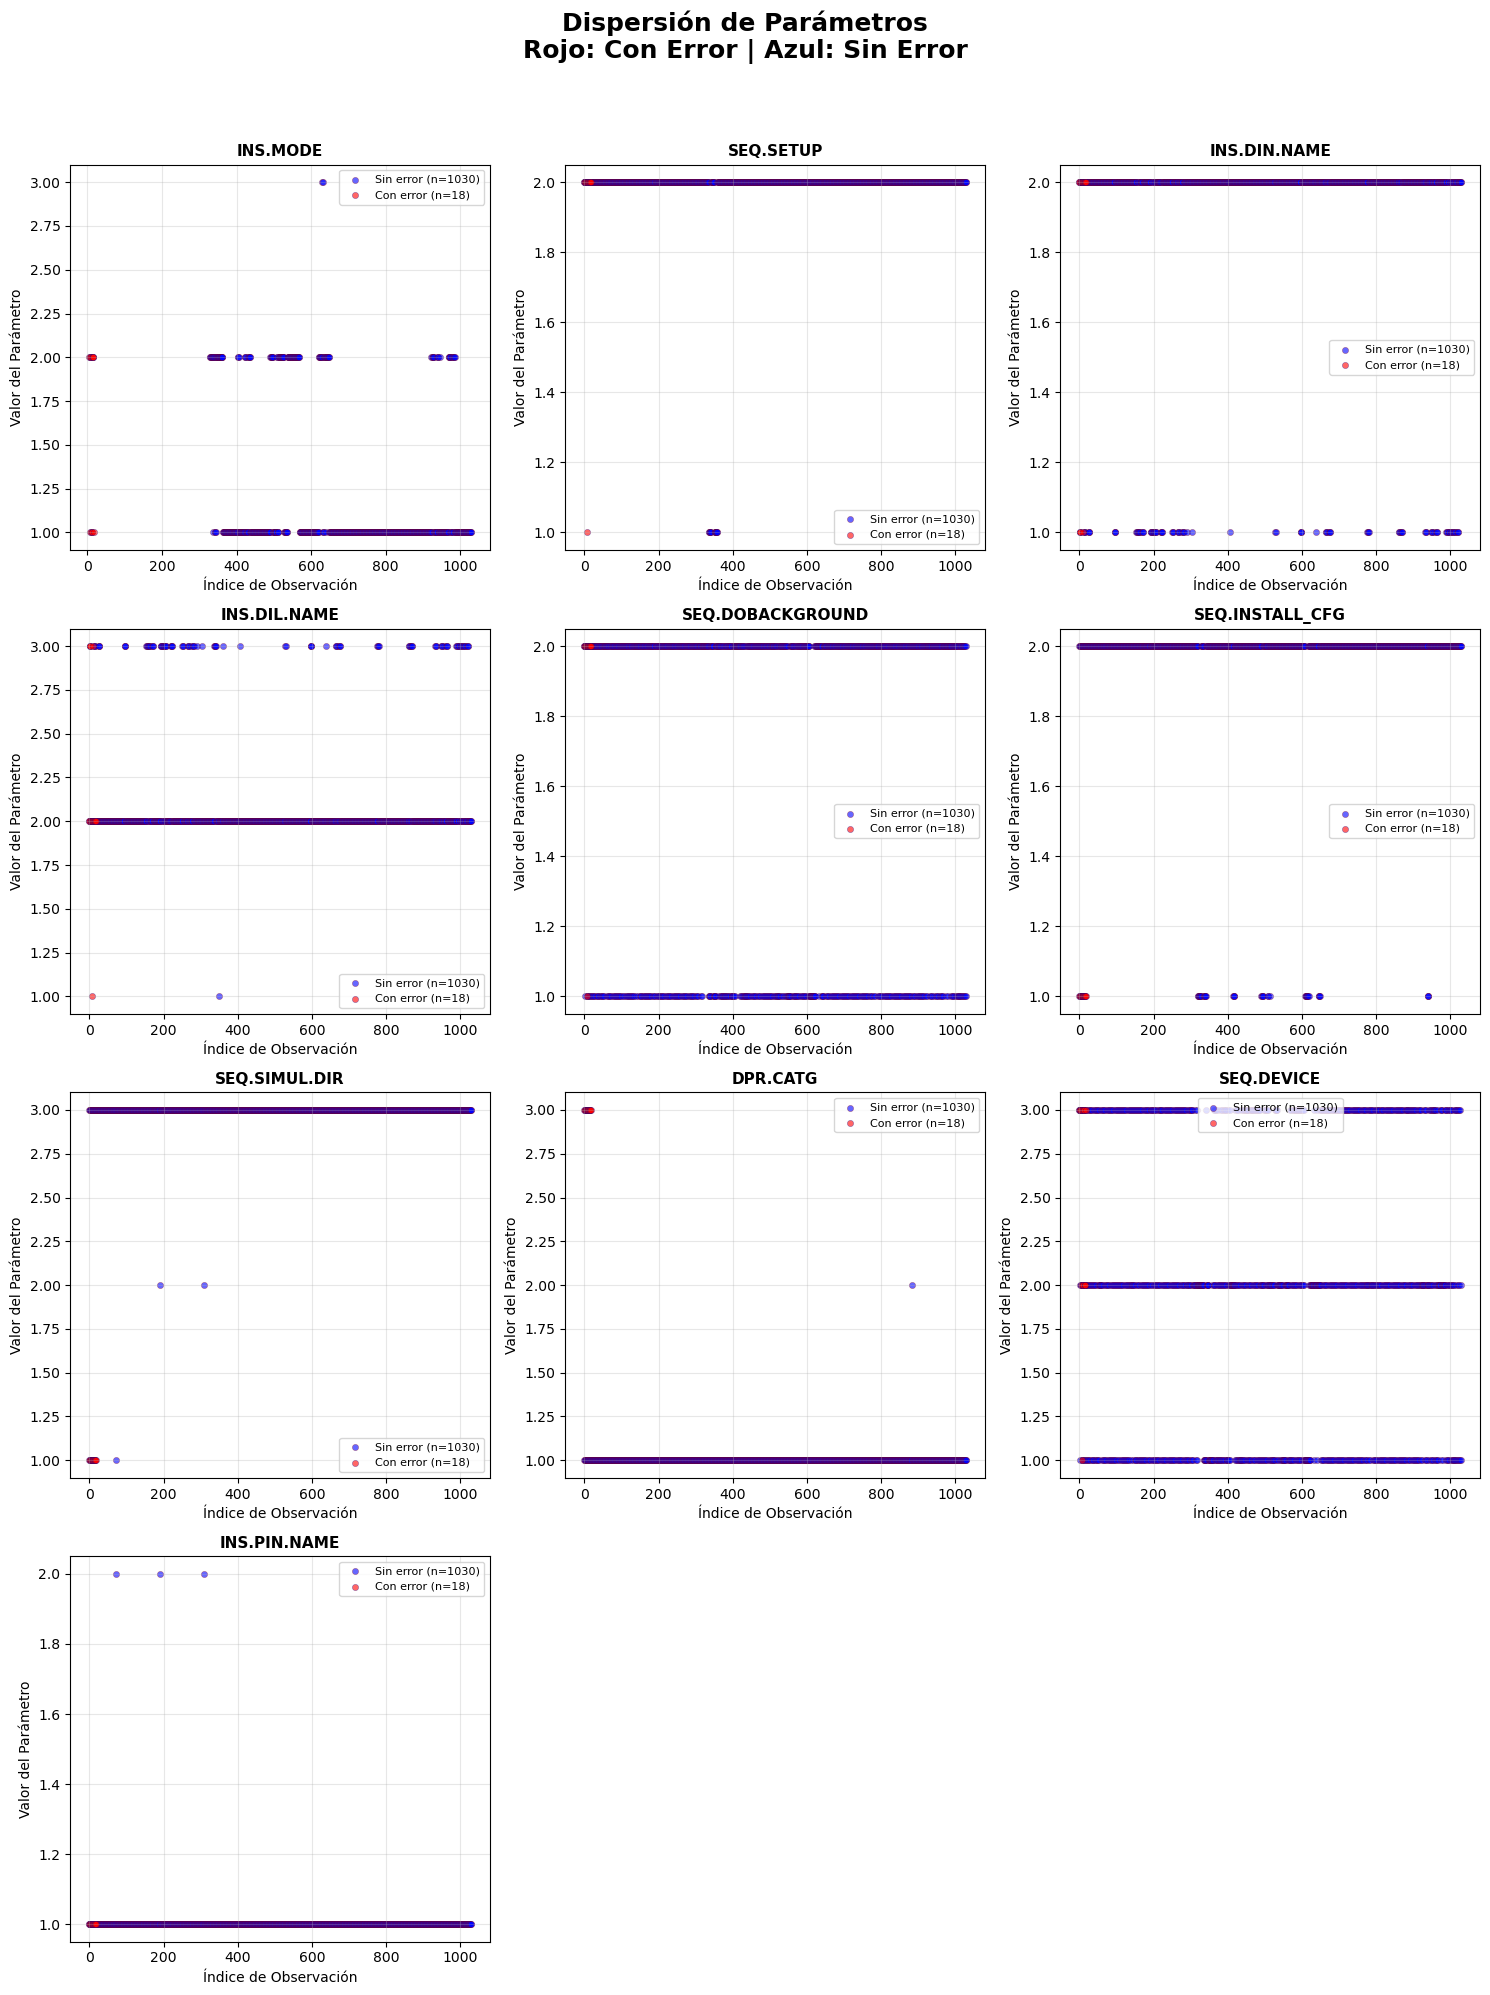


Comparando params_strval_MATISSE_gen_tec_piezos.csv
Creando gráficos para 3 parámetros NO constantes...
Parámetros constantes (omitidos): ['INS.FIL.NAME', 'INS.PIN.NAME', 'INS.DIN.NAME', 'DET2.READ.CURNAME', 'INS.DIL.NAME', 'INS.FIN.NAME', 'INS.PIL.NAME', 'INS.PON.NAME', 'DET1.READ.CURNAME', 'DPR.TECH', 'SEQ.BEAMS', 'INS.POL.NAME', 'SEQ.DEV.LIST']
Observaciones sin error: 11
Observaciones con error: 2


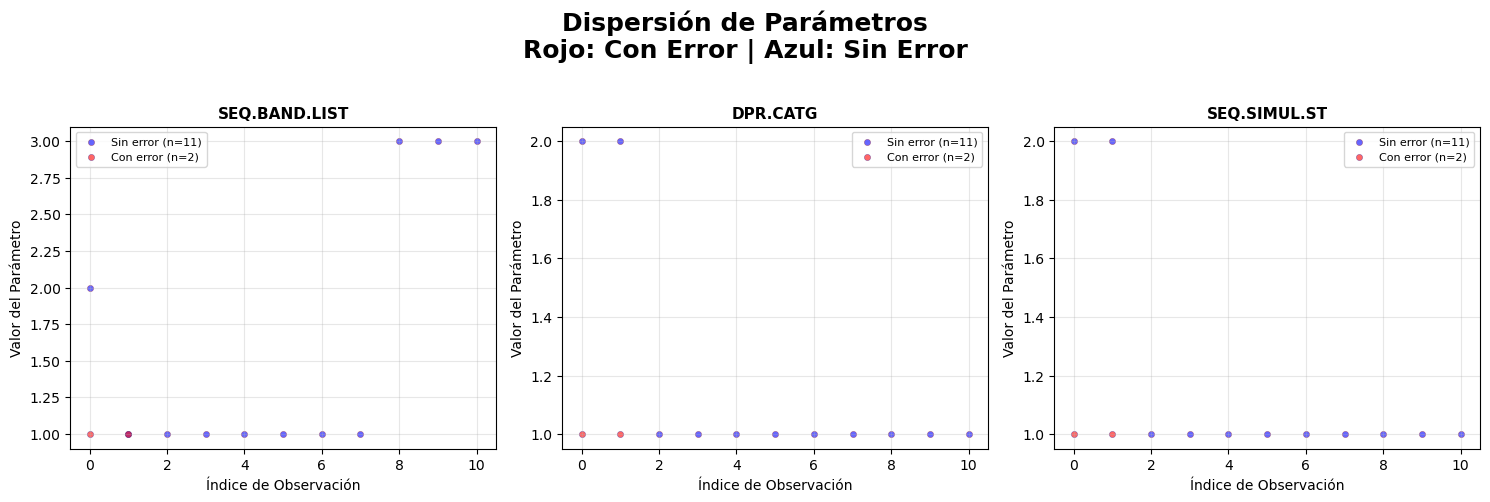


Comparando params_strval_MATISSE_hyb_obs.csv
Creando gráficos para 17 parámetros NO constantes...
Parámetros constantes (omitidos): ['SEQ.OPDM.NSTEPS', 'DET2.DIT', 'INS.PON.NAME', 'SEQ.RMNREC.ST', 'DET2.READ.CURNAME', 'INS.FIN.NAME', 'INS.POL.NAME']
Observaciones sin error: 1557
Observaciones con error: 42


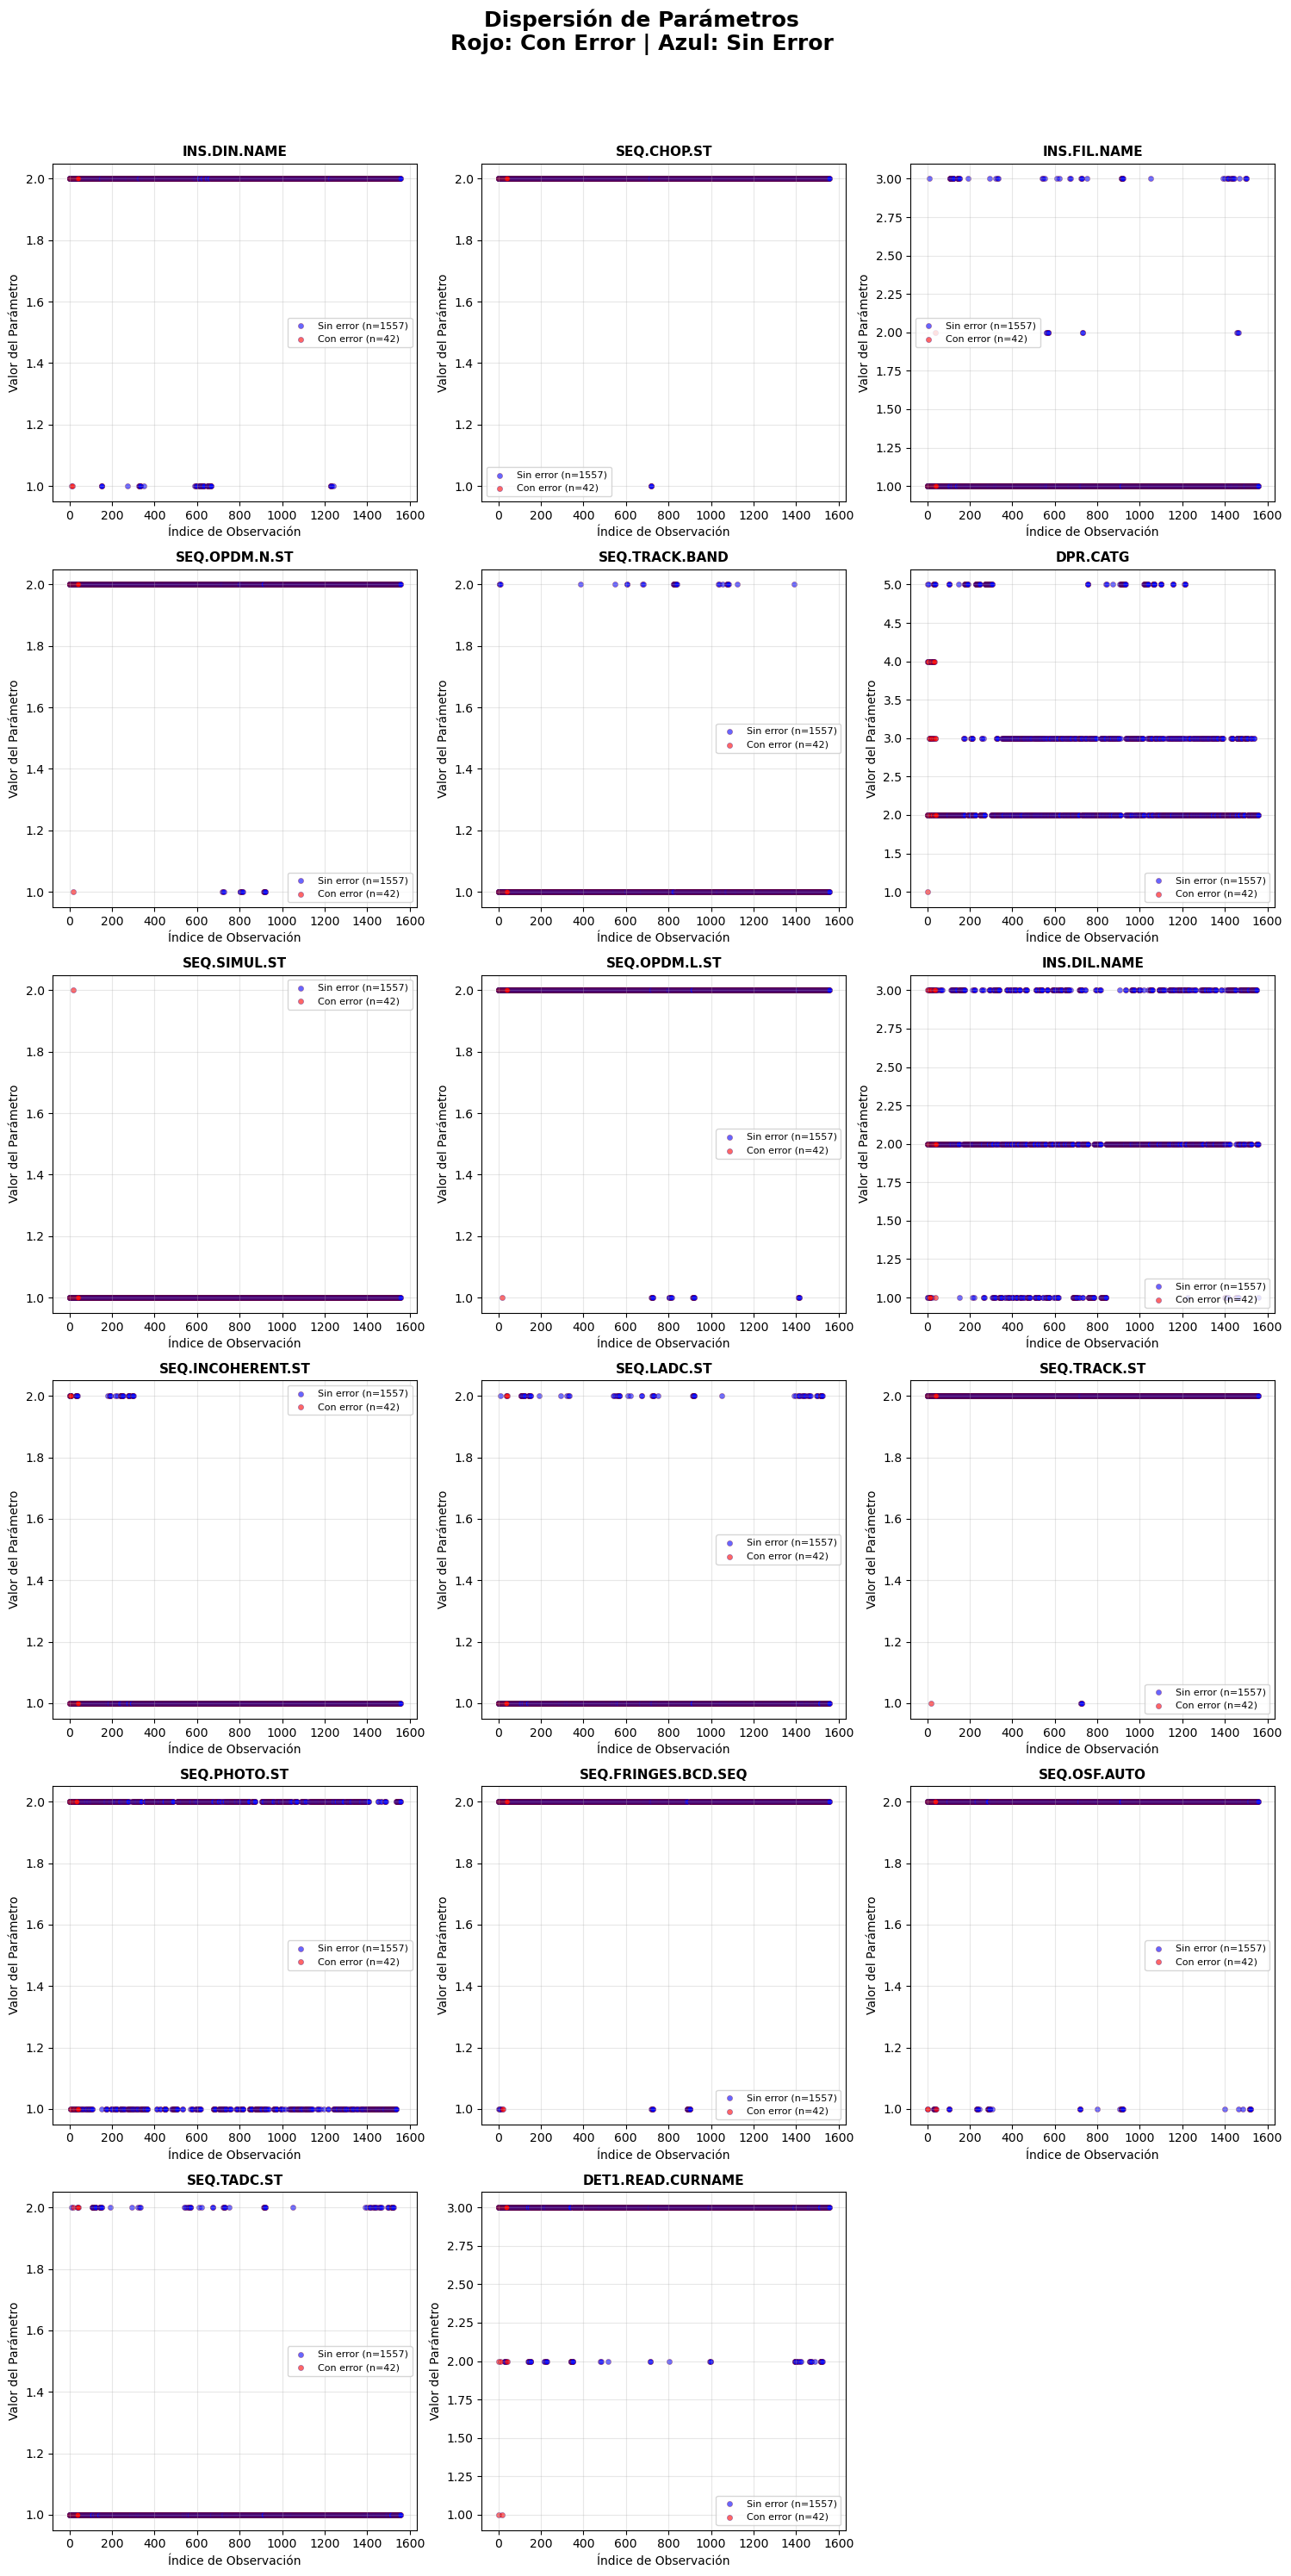


Comparando params_strval_MATISSE_img_acq.csv
Creando gráficos para 16 parámetros NO constantes...
Parámetros constantes (omitidos): ['SEQ.FS.INS.FIL.NAME', 'SEQ.OPDM.NSTEPS', 'SEQ.FS.INS.DIN.NAME', 'SEQ.FS.INS.FIN.NAME', 'SEQ.OPDM.N.ST', 'SEQ.TRACK.BAND', 'SEQ.OPDM.L.ST', 'DET2.READ.CURNAME', 'DEL.REF.NAME', 'SEQ.FS.DET2.DIT', 'SEQ.ACQ.INS.FIL.NAME', 'DEL.REF.MODE', 'SEQ.PUP.ST', 'SEQ.ACQ.INS.FIN.NAME']
Observaciones sin error: 1425
Observaciones con error: 38


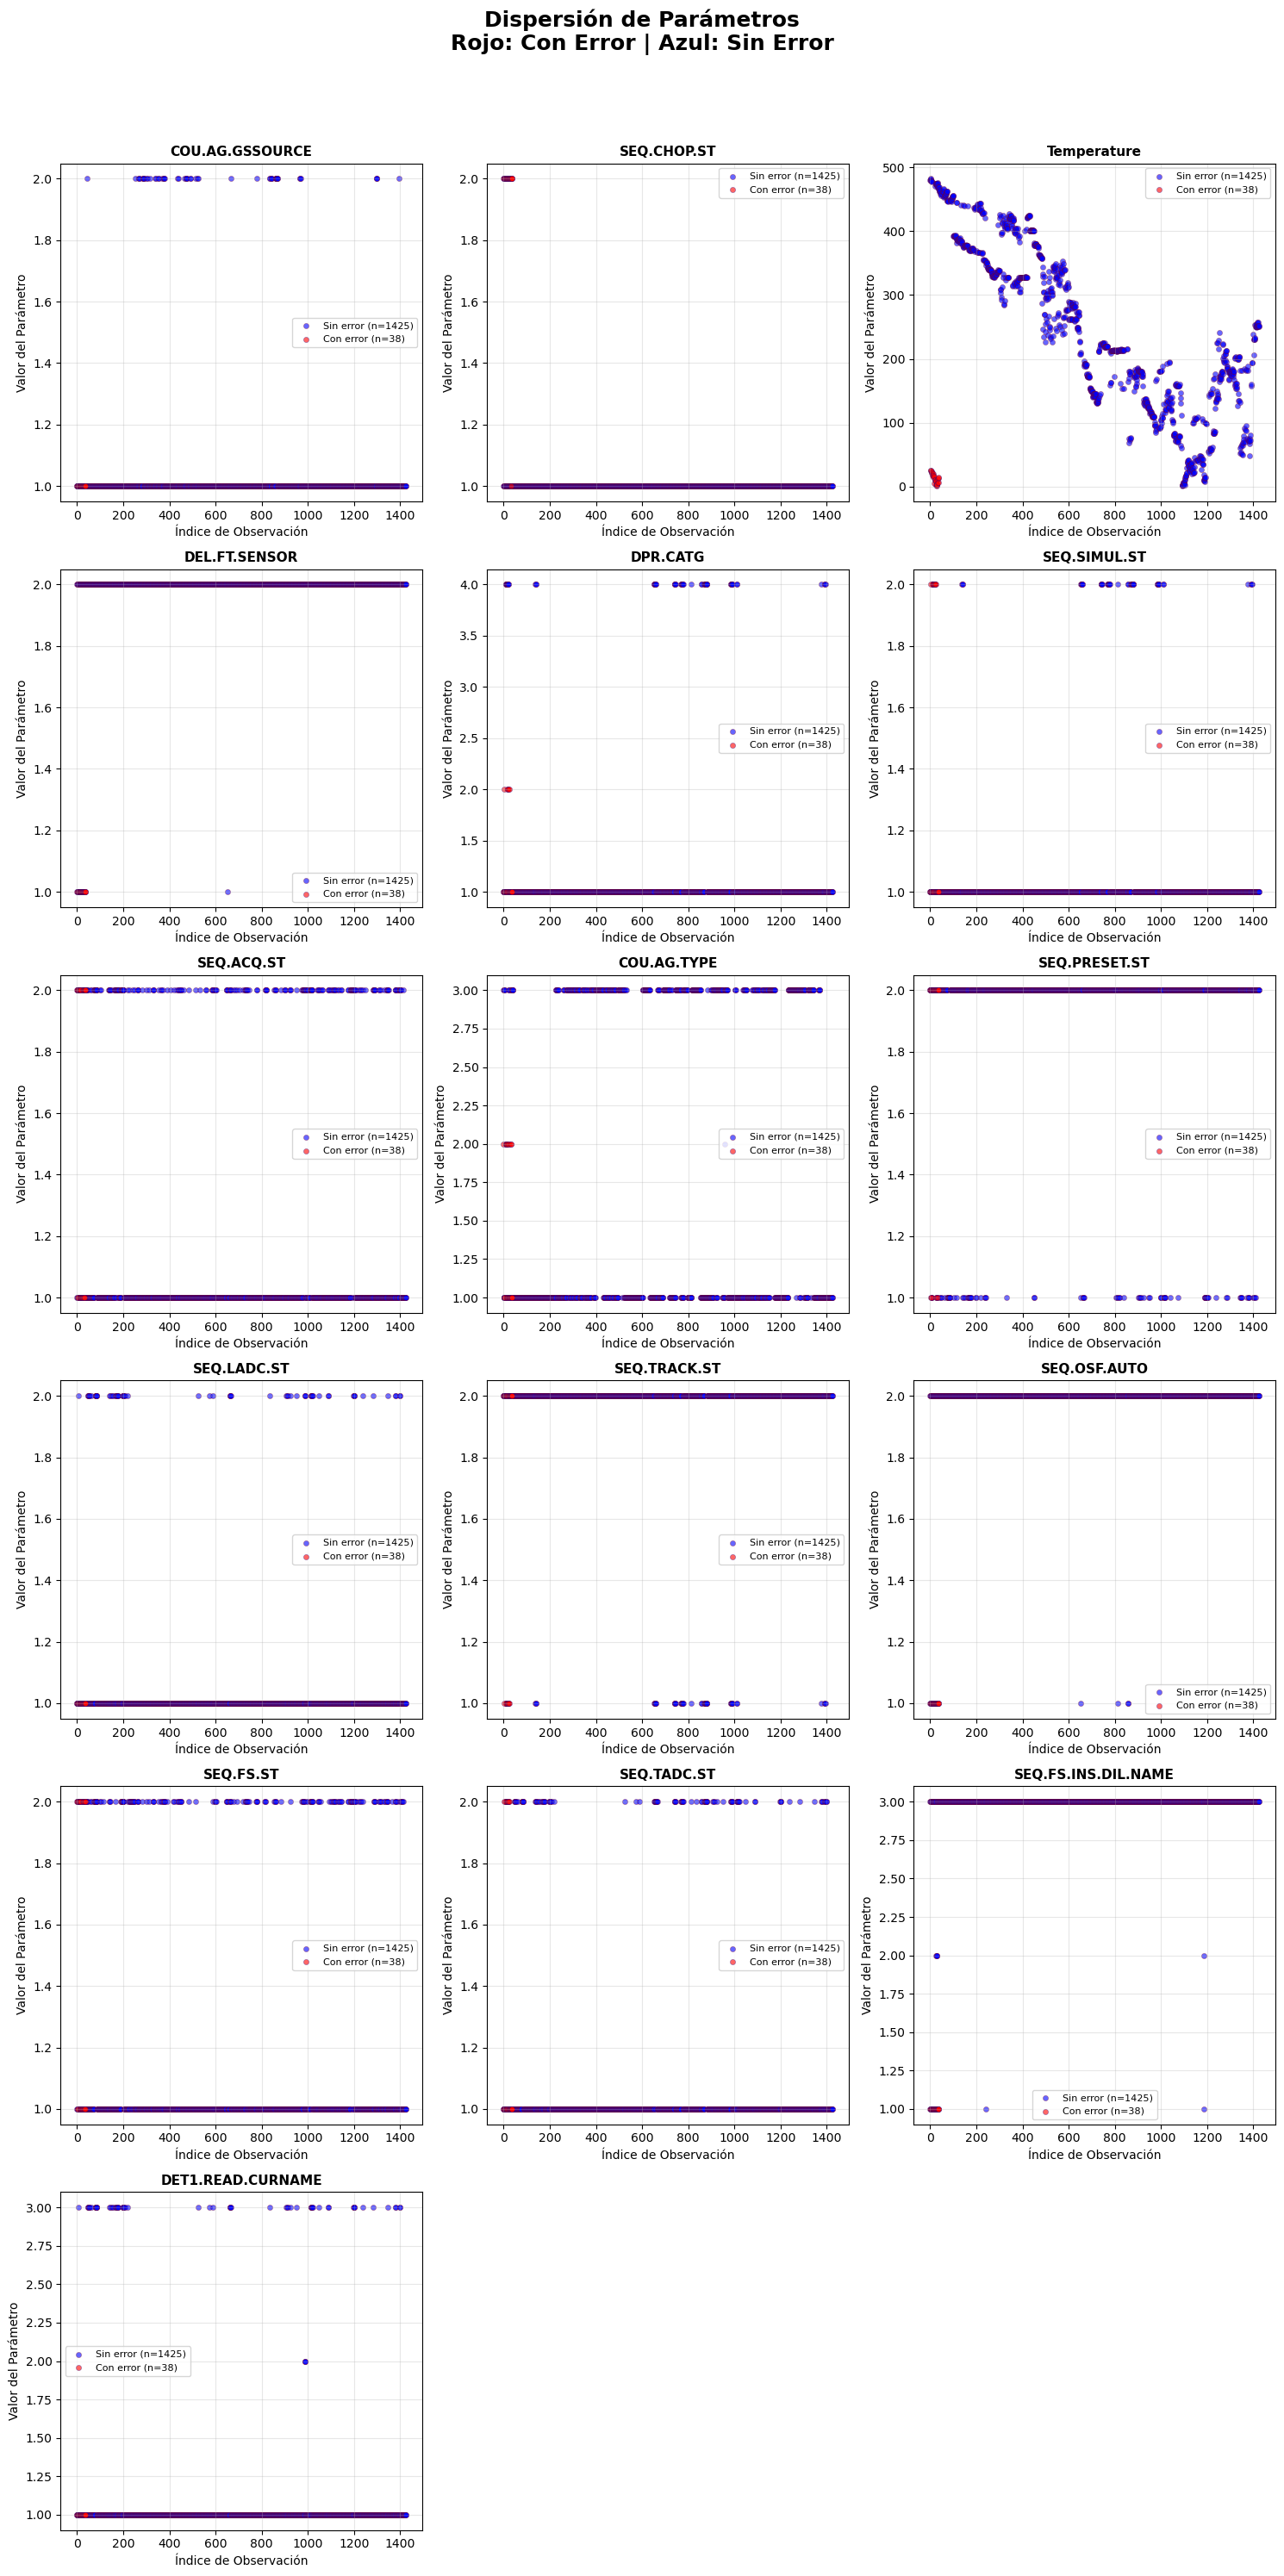


Comparando params_strval_MATISSE_img_acq_ft.csv
Creando gráficos para 8 parámetros NO constantes...
Parámetros constantes (omitidos): ['COU.AG.GSSOURCE', 'SEQ.OPDM.NSTEPS', 'SEQ.CHOP.ST', 'DEL.FT.SENSOR', 'SEQ.OPDM.N.ST', 'INS.SPEC.RES', 'SEQ.SIMUL.ST', 'SEQ.OPDM.L.ST', 'COU.AG.TYPE', 'DET2.READ.CURNAME', 'SEQ.FT.MODE', 'SEQ.ACQ.INS.FIL.NAME', 'DEL.REF.MODE', 'INS.SPEC.POL', 'INS.FT.POL', 'SEQ.PUP.ST', 'SEQ.ACQ.INS.FIN.NAME']
Observaciones sin error: 149
Observaciones con error: 21


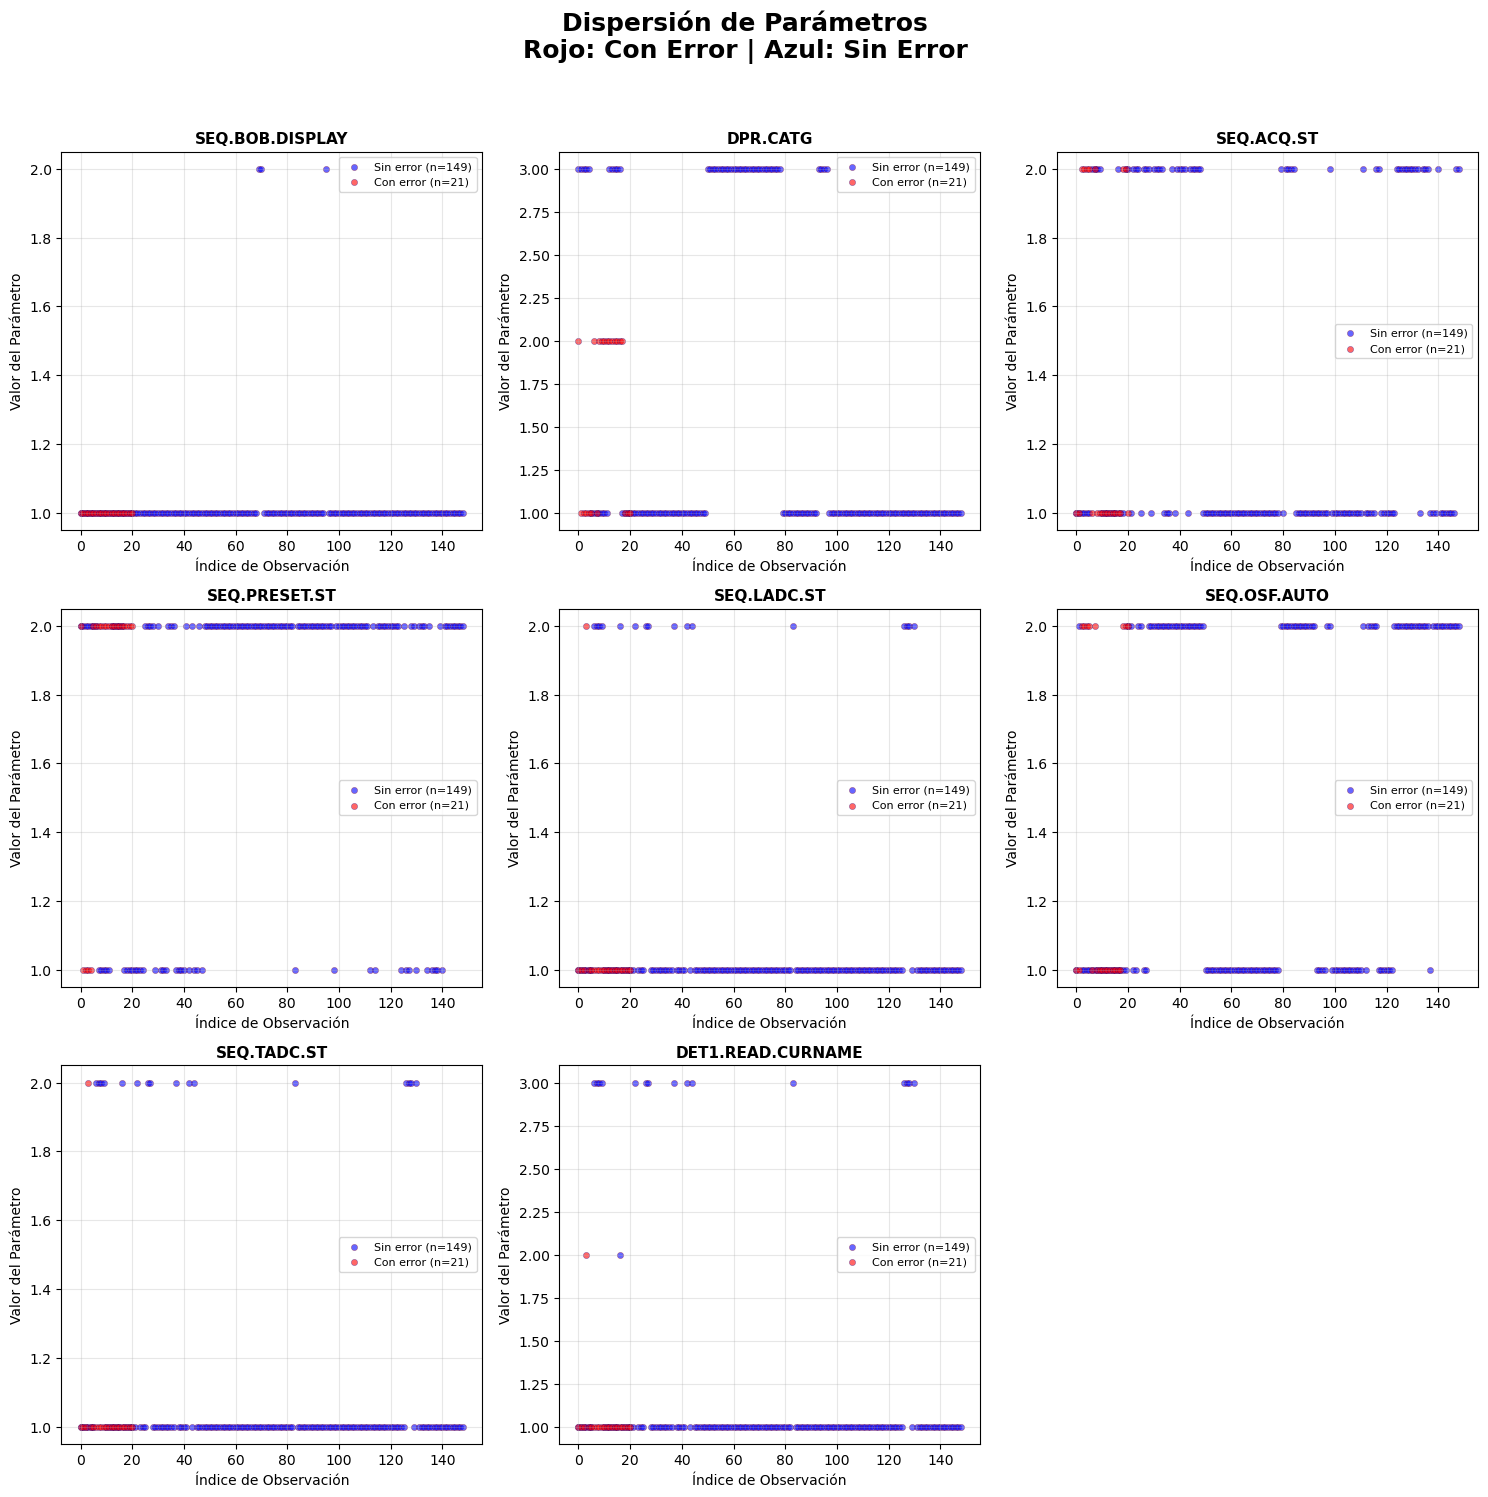


Comparando params_strval_errseverity.csv
Creando gráficos para 5 parámetros NO constantes...
Parámetros constantes (omitidos): ['DET2.READ.CURNAME', 'INS.FIN.NAME', 'INS.PIL.NAME', 'INS.PON.NAME', 'INS.POL.NAME']
Observaciones sin error: 4
Observaciones con error: 26


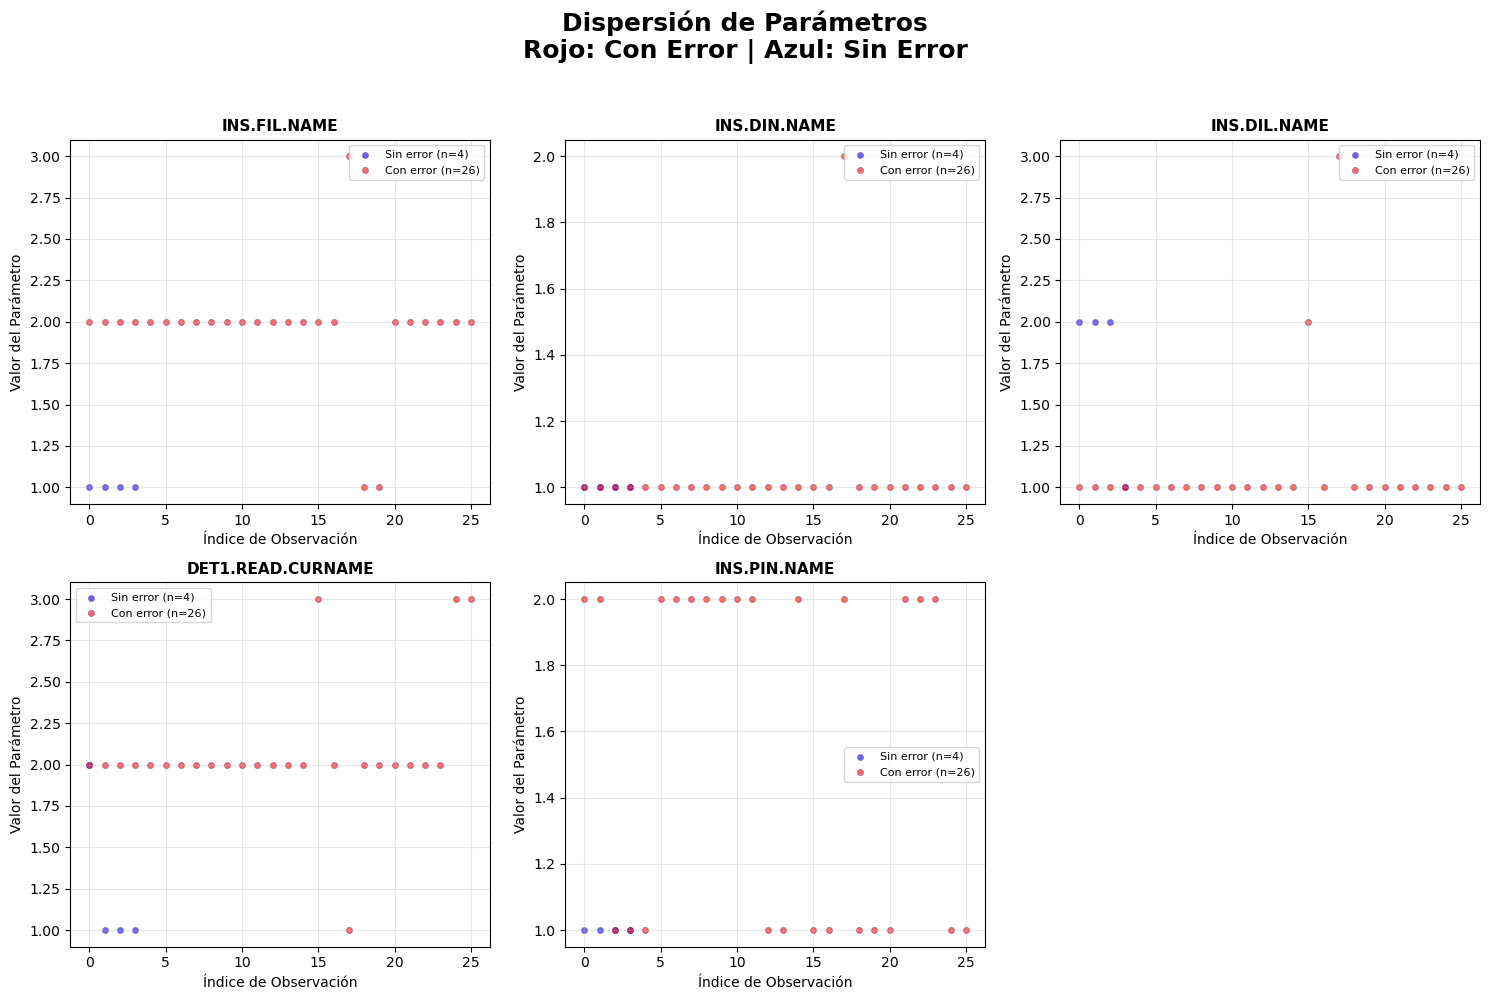


Archivos procesados: 15
params_strval_MATISSE_gen_cal_bias.csv: N/A constantes
params_strval_MATISSE_gen_cal_det_aq.csv: N/A constantes
params_strval_MATISSE_gen_cal_det_h2.csv: N/A constantes
params_strval_MATISSE_gen_cal_imbasic.csv: N/A constantes
params_strval_MATISSE_gen_cal_kappa.csv: N/A constantes
params_strval_MATISSE_gen_cal_shift.csv: N/A constantes
params_strval_MATISSE_gen_cal_transfunc.csv: N/A constantes
params_strval_MATISSE_gen_tec_ali.csv: N/A constantes
params_strval_MATISSE_gen_tec_check_fringes.csv: N/A constantes
params_strval_MATISSE_gen_tec_opd.csv: N/A constantes
params_strval_MATISSE_gen_tec_piezos.csv: N/A constantes
params_strval_MATISSE_hyb_obs.csv: N/A constantes
params_strval_MATISSE_img_acq.csv: N/A constantes
params_strval_MATISSE_img_acq_ft.csv: N/A constantes
params_strval_errseverity.csv: N/A constantes


In [ ]:
import os
import pandas as pd

dir_sin_error = "params_tpl_strval_codificados"
dir_con_error = "params_por_tpl_Error_strval_codificados"

todos_constantes = {}

archivos_comunes = set(os.listdir(dir_sin_error)) & set(os.listdir(dir_con_error))

for filename in sorted(archivos_comunes):
    if filename.endswith(".csv"):
        path_sin = os.path.join(dir_sin_error, filename)
        path_con = os.path.join(dir_con_error, filename)
        
        print(f"\nComparando {filename}")
        df_sin_error = pd.read_csv(path_sin, index_col=0)
        df_con_error = pd.read_csv(path_con, index_col=0)
        
        threshold = 0.5
        df_con_error = df_con_error.loc[:, df_con_error.isna().mean() < threshold]
        df_con_error = df_con_error.loc[df_con_error.isna().mean(axis=1) < threshold, :]
        df_sin_error = df_sin_error.loc[:, df_sin_error.isna().mean() < threshold]
        df_sin_error = df_sin_error.loc[df_sin_error.isna().mean(axis=1) < threshold, :]
        
        if not df_sin_error.empty and not df_con_error.empty:
            columns = list(set(df_sin_error.columns) & set(df_con_error.columns))
            
            if columns:  
                df_sin_error = df_sin_error[columns]
                df_con_error = df_con_error[columns]
                constantes = graficos_dispersion_por_columna(df_sin_error, df_con_error)
                todos_constantes[filename] = constantes
            else:
                print(f" No hay columnas comunes después de la limpieza para {filename}")
        else:
            print(f" DataFrame vacío después de la limpieza para {filename}. Se omite.")

